# Adversarial examples - Blind spot in representation spaces
### Author: Pietro Gori

As for all TP, answer all questions and fill the code where you see **XXXXXXXXX**

**Deadline**: please verify on the Moodle/Ecampus/web site the deadline

### Student: HO Quang Phuoc, MVA, ENS Paris-Saclay

In [1]:
import numpy as np
import random

# pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset, TensorDataset

# torchvision
from torchvision import models,transforms
import torchvision.datasets as Data

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline

import time

In this practical session, you will produce adversarial examples using two strategies to analyse the quality and smoothness of a representation space. We will use the Mnist dataset and a simple network (with 97% accuracy on test though...) so that you can train and test on your own laptop. Same conclusions can be drawn by using larger architectures and more complex datasets (You can try if you want).

Let's start with the first method. Please read first the article [1], in particular from Sectioon 4.

`[1] Szegedy, Christian, Zaremba, Wojciech, Sutskever, Ilya, Bruna, Joan, Erhan, Dumitru, Goodfellow, Ian J.,
and Fergus, Rob. Intriguing properties of neural networks. ICLR, 2014`

We first check if you are using a computer with GPU, CUDA (Nvidia) or MPS (MacBook), or only CPU.

In [2]:
print("Using torch", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print(x)
    print("MPS (MacBook) device found.")
    print("Number of MPS cards: ", torch.mps.device_count())
    print(
        "Total MPS memory {0:.2f} GB".format(
            torch.mps.recommended_max_memory() / pow(10, 9)
        )
    )
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print(x)
    print("CUDA device found.")
    print(
        "Number of GPU cards: ",
        torch.cuda.device_count(),
        "\nWhich card GPU?",
        torch.cuda.get_device_name(0),
    )
    print(
        "Total GPU memory {1:.2f} GB. Free GPU memory {0:.2f} GB".format(
            torch.cuda.mem_get_info()[0] / pow(10, 9),
            torch.cuda.mem_get_info()[1] / pow(10, 9),
        )
    )
else:
    device = torch.device("cpu")
    x = torch.ones(1, device=device)
    print(x)
    print("No MPS or CUDA has been found. PyTorch will use CPU.")

Using torch 2.5.1+cu121
tensor([1.], device='cuda:0')
CUDA device found.
Number of GPU cards:  2 
Which card GPU? Tesla T4
Total GPU memory 15.83 GB. Free GPU memory 15.70 GB


Here we fix the different seeds to make your algorithm reproducible and we set the hyper-parameters for the classification model we are going to train. You can modify them if you want, but I suggest you keep them like that for now and modify them only AFTER having trained for a first time the model.

In [3]:
# to make the results reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)
torch.mps.manual_seed(10)
random.seed(10)


# Parameters for training model
weight_decay = 0.0001
num_epochs = 10
batch_size = 256  # adapted to the Google Colab GPU
learning_rate = 0.001
loss_model = nn.CrossEntropyLoss()

We will use the MNIST dataset. Download it from torchvision.

In [4]:
mnist_train = Data.MNIST(
    root="data/", train=True, transform=transforms.ToTensor(), download=True
)

train_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True)

mnist_test = Data.MNIST(
    root="data/", train=False, transform=transforms.ToTensor(), download=True
)

test_loader = DataLoader(dataset=mnist_test, batch_size=10000, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 478kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.73MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



We analyse the data to check the number of samples and their size.

In [5]:
# Print infomration
print(
    "There are", len(mnist_train), "training images and", len(mnist_test), "test images"
)
image_size = list(mnist_train[0][0].squeeze().shape)
print(f"Each image is of shape: {image_size}")  # [28, 28]

There are 60000 training images and 10000 test images
Each image is of shape: [28, 28]


Here we code the model proposed in the article.

**Question**: complete the code so that you can create *A simple fully connected network with one or more hidden layers and a Softmax classifier. We refer to this network as “FC”*. Please code it so that the input_size of the model (i.e. size of the input images), the number and size of hidden layers (e.g., [100,100]) and the output size (i.e., number of possible classes) are parameters of the model.

In [7]:
class FullyConnectedNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FullyConnectedNet, self).__init__()

        layers = []
        in_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_size, hidden_size))
            layers.append(nn.ReLU())
            in_size = hidden_size

        layers.append(nn.Linear(in_size, output_size))  # output layer
        # layers.append(nn.Softmax(dim=1))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten the input tensor
        return self.network(x)

**Question**: Create one of the model proposed in the article.

In [25]:
input_size = 28 * 28
hidden_sizes = [100, 100]  # [], [200, 200]
output_size = 10

# Model
model = FullyConnectedNet(input_size, hidden_sizes, output_size).to(device)
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Print the model
print(model)

FullyConnectedNet(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)


Here we code the training procedure, as commonly done with Pytorch. Please note that we use the Adam optimizer.

In [26]:
def training(model, train_loader, optimizer, num_epochs, loss_model):
    for epoch in range(num_epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):

            # Put images to GPU
            X = images.to(device)
            # print("X.shape:", X.shape)
            Y = labels.to(device)

            # Forward pass
            outputs = model(X)
            loss = loss_model(outputs, Y)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:
                print(
                    f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}"
                )

And we evaluate it.

In [27]:
def evaluation(model, test_loader):
    model.eval()

    correct = 0
    total = 0

    for images, labels in test_loader:

        X = images.to(device)

        Y = labels.to(device)

        outputs = model(X)  # array of size [num test images, num classes]

        predicted_class = torch.argmax(outputs.data, dim=1)  # faster

        total += len(Y)
        correct += (predicted_class == Y).sum()

    print("Accuracy of test images: %f %%" % (100 * float(correct) / total))

In [28]:
# Training loop
training(model, train_loader, optimizer, num_epochs, loss_model)

Epoch [1/10], Step [100/235], Loss: 0.3823
Epoch [1/10], Step [200/235], Loss: 0.3323
Epoch [2/10], Step [100/235], Loss: 0.1823
Epoch [2/10], Step [200/235], Loss: 0.1977
Epoch [3/10], Step [100/235], Loss: 0.1417
Epoch [3/10], Step [200/235], Loss: 0.1646
Epoch [4/10], Step [100/235], Loss: 0.1241
Epoch [4/10], Step [200/235], Loss: 0.1133
Epoch [5/10], Step [100/235], Loss: 0.1468
Epoch [5/10], Step [200/235], Loss: 0.0733
Epoch [6/10], Step [100/235], Loss: 0.0634
Epoch [6/10], Step [200/235], Loss: 0.0948
Epoch [7/10], Step [100/235], Loss: 0.0763
Epoch [7/10], Step [200/235], Loss: 0.0573
Epoch [8/10], Step [100/235], Loss: 0.0519
Epoch [8/10], Step [200/235], Loss: 0.0558
Epoch [9/10], Step [100/235], Loss: 0.0581
Epoch [9/10], Step [200/235], Loss: 0.0729
Epoch [10/10], Step [100/235], Loss: 0.0308
Epoch [10/10], Step [200/235], Loss: 0.0446


In [29]:
evaluation(model, test_loader)

Accuracy of test images: 97.440000 %


**Question**: Is the performance good ? Test different architectures (number and size of hidden layers). You can also try different hyper-parameters (weight decay, number of epochs, etc.). Use the "Occam's razor principle" to choose and justify your final model.

### **Answer**

I tested three different architectures, varying the number of hidden units while using the following fixed parameters:  
- **Number of epochs**: 10  
- **Learning rate**: 1e-3  
- **Weight decay**: 1e-4  
- **Batch size**: 256  

#### **Architectures and Results**  
| Hidden Layer Configuration | Test Accuracy |  
|----------------------------|---------------|  
| [] (No hidden layer)        | 92.33%        |  
| [100, 100]                  | 97.44%        |  
| [200, 200]                  | 97.76%        |  

#### **Training Time Observation**
The training times for these architectures are very similar and difficult to distinguish significantly.

---

#### **Model Selection Based on Occam’s Razor**
While the model with [200, 200] hidden units achieves the highest accuracy, the simpler architecture with [100, 100] hidden units provides competitive performance with fewer parameters and less complexity. According to **Occam’s Razor**, the [100, 100] configuration is the preferred choice as it balances accuracy and simplicity without sacrificing significant performance.

---

### **Final Model Choice**
- **Architecture**: [100, 100]  
- **Justification**: This model offers a good trade-off between accuracy and complexity, achieving 97.44% test accuracy while adhering to the principle of preferring simpler models when the performance difference is minimal.

---


Here, you will code the method proposed in Sec. 4.1 of [1]. I copy/paste it here:

We denote by $f : R^m \rightarrow {1 . . . k}$ a classifier mapping image pixel value vectors to a discrete label set. We also assume that $f$ has an associated continuous loss function denoted by $\text{loss}_f : R^m × {1 . . . k} \rightarrow R^+$. For a given $x \in R^m$ image and target label $l \in {1 . . . k}$, we aim to solve the following box-constrained optimization problem:

• Minimize $||r||_2$ subject to:
1. $f(x + r) = l$
2. $x + r \in [0, 1]^m$


The minimizer $r$ might not be unique, but we denote one such $x + r$ for an arbitrarily chosen minimizer by $D(x, l)$. Informally, $x + r$ is the closest image to $x$ classified as $l$ by $f$. Obviously, $D(x, f(x)) = f(x)$, so this task is non-trivial only if $f(x) \neq l$. In general, the exact computation
of $D(x, l)$ is a hard problem, so we approximate it by using a box-constrained L-BFGS. Concretely, we find an approximation of $D(x, l)$ by performing line-search to find the minimum $c > 0$ for which the minimizer $r$ of the following problem satisfies $f(x + r) = l$.

• Minimize $c|r| + \text{loss}_f (x + r, l)$ subject to $x + r \in [0, 1]^m$

This penalty function method would yield the exact solution for $D(X, l)$ in the case of convex losses, however neural networks are non-convex in general, so we end up with an approximation in this case.

We start by setting the hyper-parameters of the L-BFGS method. Keep them like that for now. You will come back later to change them.

In [30]:
# Parameters adversarial example
index = 666  # index test image to use

max_iter_search = 300
initial_c = 0.000001  # Initial value of c
max_c = 0.01  # Upper limit for c
mult_c = 1.03  # Multiplicative update of c at each iter c *= mult_c

epsilon_LBFGS = 1e-6  # Small value for line search stopping criterion
max_iter_LBFGS = 100  # Maximum iterations for L-BFGS
lr_LBFGS = 0.1  # Learning rate for L-BFGS

We can plot the chosen image

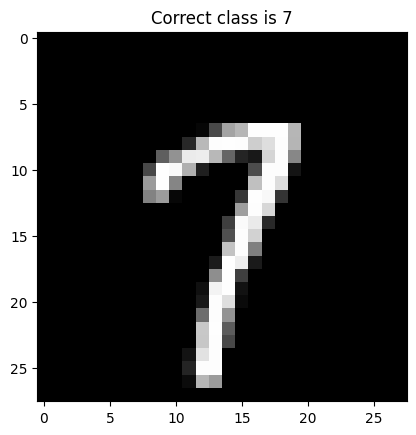

In [31]:
testI, testY = mnist_test.__getitem__(index)
fig = plt.imshow(testI.squeeze(), interpolation="nearest", cmap=plt.cm.gray)
plt.title(f"Correct class is {testY}")
plt.show()

I have written a code to plot the original image $x$, the modified image $x+r$ and the residual added $r$.

In [32]:
def plot_results(X, r, Xr, Y, l, fail=True):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 7))
    im1 = axes[0].imshow(
        X.squeeze().cpu().detach().numpy(), interpolation="nearest", cmap=plt.cm.gray
    )
    axes[0].set_title(f"Original Image. Correct class is {Y}", fontsize=22)

    im3 = axes[2].imshow(
        r.squeeze().cpu().detach().numpy(), interpolation="nearest", cmap=plt.cm.gray
    )
    axes[2].set_title(f"Residual added", fontsize=22)

    if fail:
        im2 = axes[1].imshow(
            Xr.squeeze().cpu().detach().numpy(),
            interpolation="nearest",
            cmap=plt.cm.gray,
        )
        axes[1].set_title(
            f"Modified Image, FAILED to predict class {l.item()}", fontsize=22
        )
    else:
        im2 = axes[1].imshow(
            Xr.squeeze().cpu().detach().numpy(),
            interpolation="nearest",
            cmap=plt.cm.gray,
        )
        axes[1].set_title(f"Modified Image, PREDICTED class {l.item()}", fontsize=22)

    # Add a single colorbar for all subplots
    cbar = fig.colorbar(im3, ax=axes, orientation="vertical", fraction=0.02, pad=0.04)
    cbar.set_label("Intensity (0 to 1)")

    # Show the plots
    plt.show()

The true class is 7, the new class will be 9
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 0 iterations
Norm Perturbation |r|: 497.4515380859375


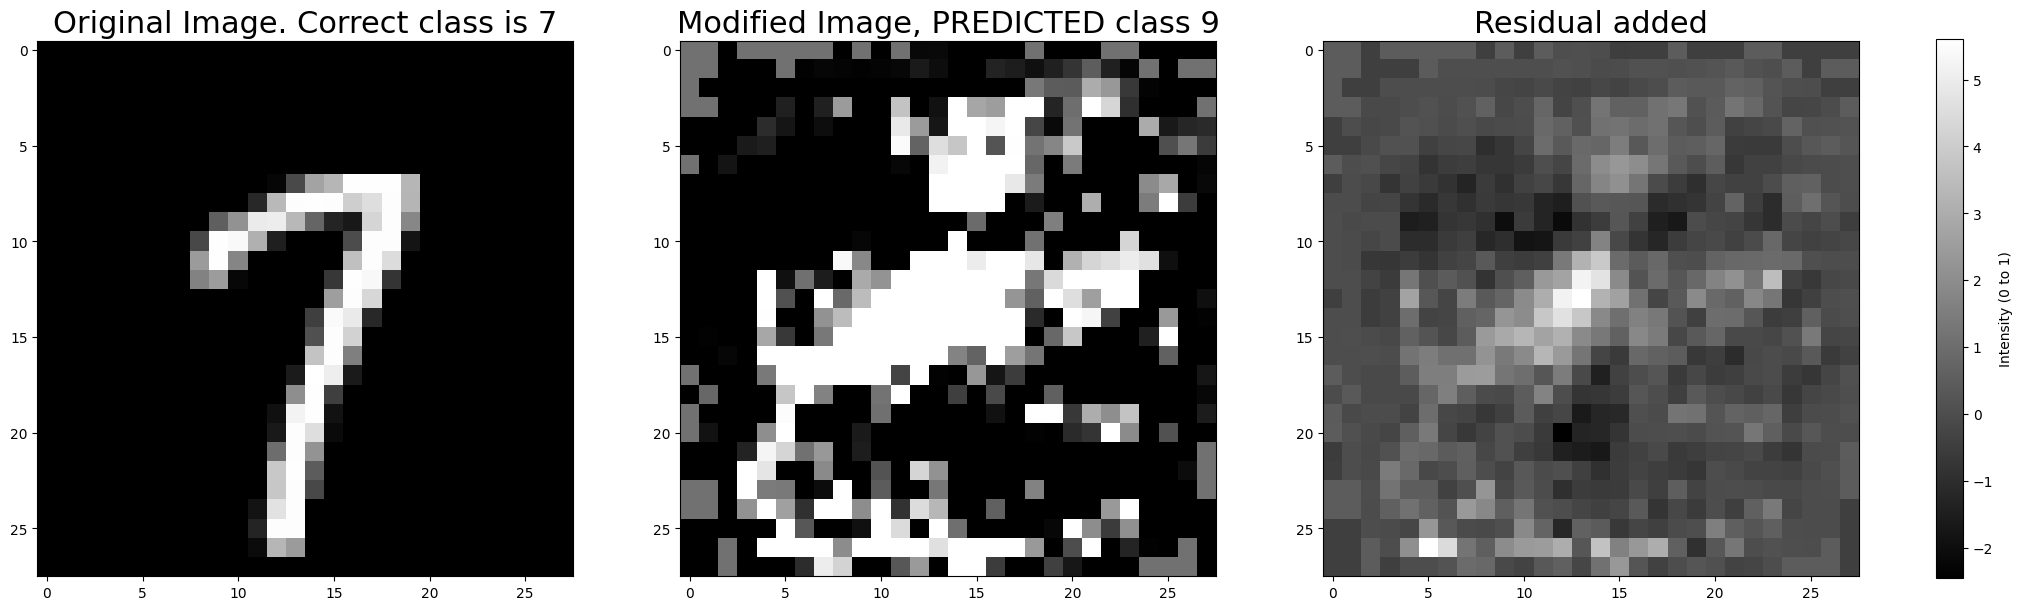

In [33]:
import torch
import torch.optim as optim
import torch.nn.functional as F

testI = testI.to(device)
r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
label = 9  # manually chosen target class label different from true one
l = torch.tensor([label]).to(device)
l = l.to(device)
l = l.view(1)  # to have a batch size equal to 1 and work with CrossEntropy loss
print(f"The true class is {testY}, the new class will be {l[0]}")


# Define the loss function
def objective(c, r, x, l):
    x_r = torch.clamp(x + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
    pred = model(x_r)
    classification_loss = F.cross_entropy(pred, l)
    perturbation_loss = c * torch.norm(r, p=1)
    return classification_loss + perturbation_loss


# Line search to find the minimum c > 0
c = initial_c
iter = 0
while c <= max_c and iter <= max_iter_search:
    optimizerLBFGS = optim.LBFGS(
        [r], max_iter=max_iter_LBFGS, lr=lr_LBFGS, tolerance_grad=epsilon_LBFGS
    )

    def closure():
        optimizerLBFGS.zero_grad()
        loss = objective(c, r, testI, l)
        loss.backward()
        return loss

    optimizerLBFGS.step(closure)

    with torch.no_grad():
        x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
        pred = model(x_r)
        predicted_label = torch.argmax(pred, dim=1)

    if predicted_label.item() == l.item():
        print(f"Found c = {c:.6f} satisfying f(x + r) = l")
        break

    c *= mult_c  # Adjust step size for line search
    iter += 1
    if iter % 20 == 0:
        print(f"Iter {iter}/{max_iter_search}, Value of c: {c:.6f}")

if c > max_c or iter > max_iter_search:
    print(
        "Failed to find c satisfying f(x + r) = l within maximum limit of c and iterations."
    )
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(testI, r, x_r, testY, l, fail=True)
else:
    print(f"Optimization succeeded with c = {c:.6f} in {iter} iterations")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(testI, r, x_r, testY, l, fail=False)

Here we will code the proposed method. Complete the code where you see `XXXXXXX`.

Please be advised that the `torch.optim.LBFGS` optimizer is designed to work with a `closure` for computing the loss and gradients multiple times during optimization, which is essential for second-order methods.

The closure is a callable function passed to LBFGS that recomputes the loss and its gradients multiple times during a single optimization step.
To work correctly, we need to call `optimizer.zero_grad()` to clear old gradients before calculating new ones.

Please note that SGD or Adam don't require a closure because they update the parameters based on the current gradient in a single step.

More info here: https://pytorch.org/docs/stable/optim.html

#### Here I change to function for later reuse.

In [34]:
def test_perturbation_with_c_and_l(
    testI, model, true_label, initial_c, max_c, max_iter_search, l, device
):
    """
    This function applies a perturbation to the image `testI` such that it is classified as target label `l`
    using box-constrained L-BFGS optimization. The perturbation is minimized with a regularization parameter `c`.

    Parameters:
    - testI: Input image tensor to be perturbed
    - model: Trained model
    - true_label: True label of the image (for visualization)
    - initial_c: Initial value for the regularization parameter `c`
    - max_c: Maximum value for `c` to avoid infinite loop
    - max_iter_search: Maximum number of iterations for the line search
    - l: Target label for the perturbation
    - device: Device (CPU or GPU) on which the computation is carried out

    Returns:
    - None (plots and prints results)
    """
    testI = testI.to(device)
    r = torch.zeros_like(
        testI, requires_grad=True, device=device
    )
    l = torch.tensor([l]).to(
        device
    )
    l = l.view(1)  # to have a batch size equal to 1 and work with CrossEntropy loss

    print(f"The true class is {true_label}, the new class will be {l[0]}")

    # Define the loss function
    def objective(c, r, x, l):
        # Perturb the image
        x_r = torch.clamp(x + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
        pred = model(x_r)
        classification_loss = torch.nn.CrossEntropyLoss()(pred, l)
        perturbation_loss = c * torch.norm(r, p=1)  # L1 penalty on perturbation
        return classification_loss + perturbation_loss

    c = initial_c
    iter = 0
    while (c <= max_c) and (iter <= max_iter_search):
        # Define the optimizer (Box-Constrained L-BFGS)
        optimizerLBFGS = optim.LBFGS([r])

        def closure():
            optimizerLBFGS.zero_grad()
            loss = objective(c, r, testI, l)
            loss.backward()
            return loss

        # Perform optimization
        optimizerLBFGS.step(closure)

        # Evaluate the condition f(x + r) = l
        with torch.no_grad():
            x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
            pred = model(x_r)
            predicted_label = torch.argmax(pred, dim=1)

        # Check if the condition f(x + r) = l is satisfied
        if predicted_label == l:
            print(f"Found c = {c:.6f} satisfying f(x + r) = l")
            break

        # If not satisfied, increase c
        c *= mult_c  # Adjust step size for line search
        iter += 1
        if iter % 20 == 0:
            print(f"Iter {iter}/{max_iter_search}, Value of c: {c:.6f}")

    # If the line search fails to find a valid c
    if (c > max_c) or (iter > max_iter_search):
        print(
            "Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter."
        )
        print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

        plot_results(testI, r, x_r, true_label, l, fail=True)

    else:
        print(f"Optimization succeeded with c = {c:.6f} in {iter} iterations")
        print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

        plot_results(testI, r, x_r, true_label, l, fail=False)

The true class is 7, the new class will be 4
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 0 iterations
Norm Perturbation |r|: 550.1925659179688


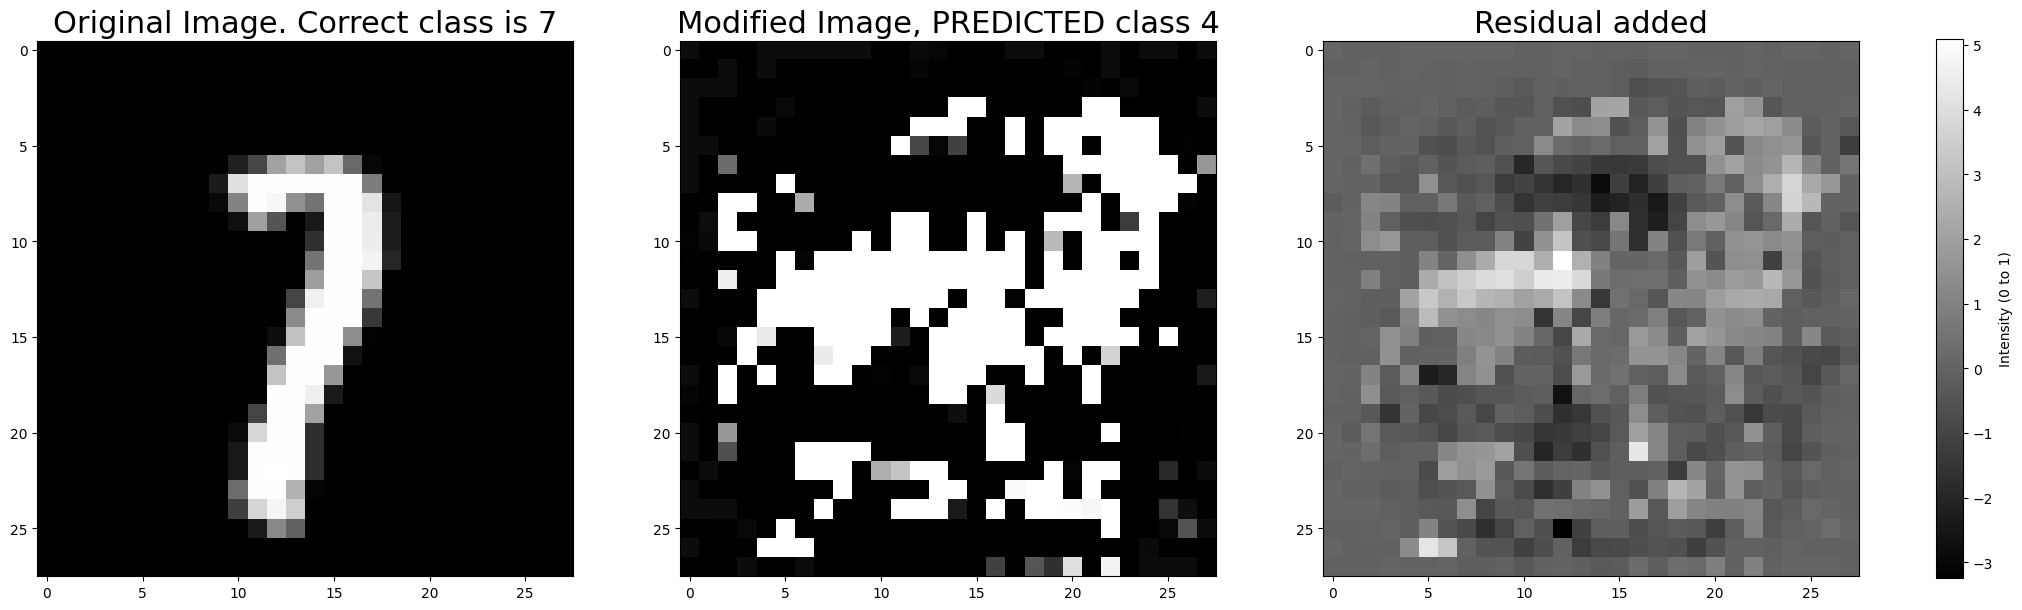

The true class is 2, the new class will be 0
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 0 iterations
Norm Perturbation |r|: 140.21780395507812


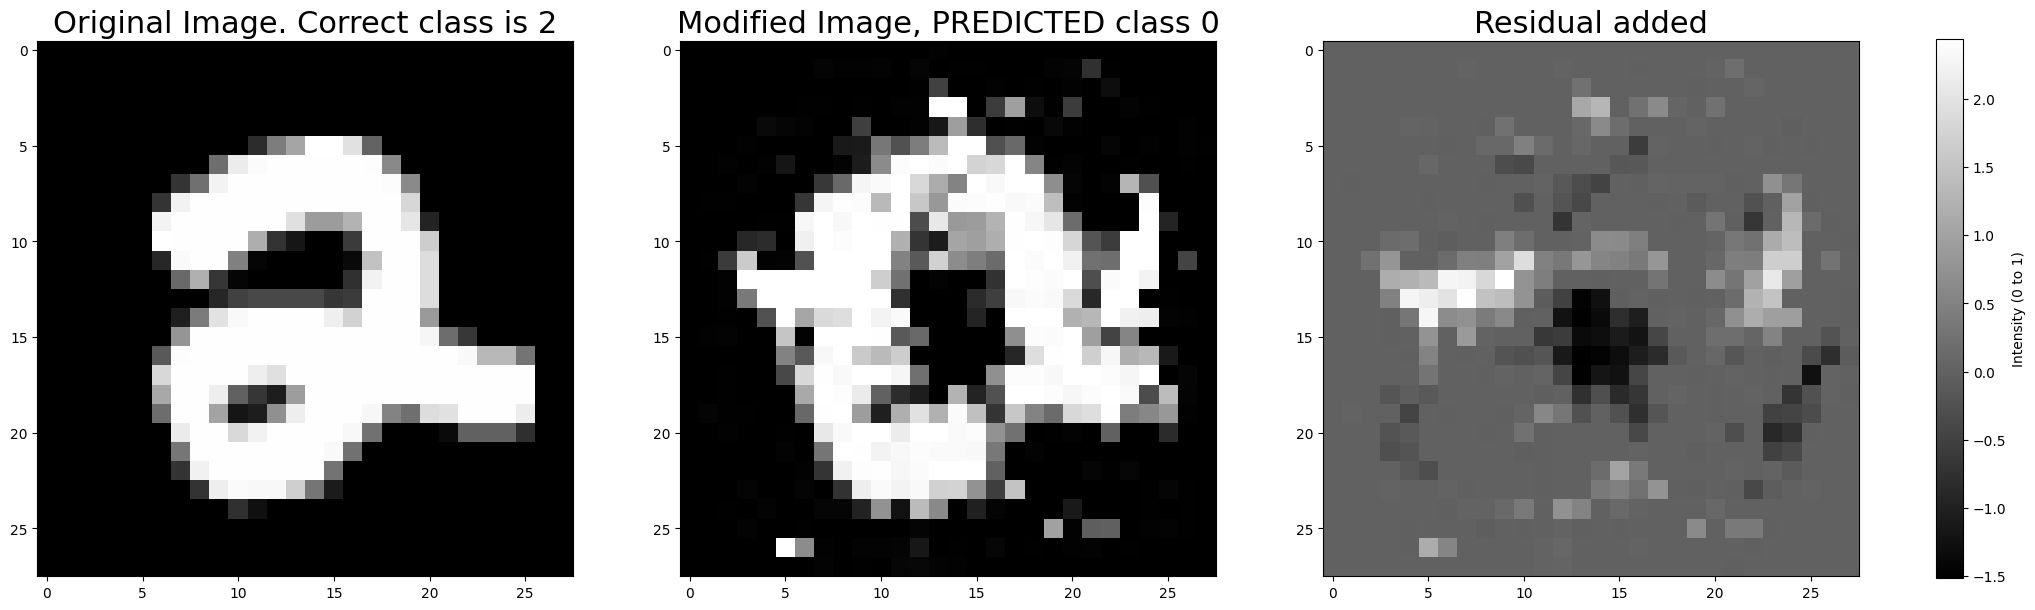

The true class is 5, the new class will be 1
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 0 iterations
Norm Perturbation |r|: 167.29510498046875


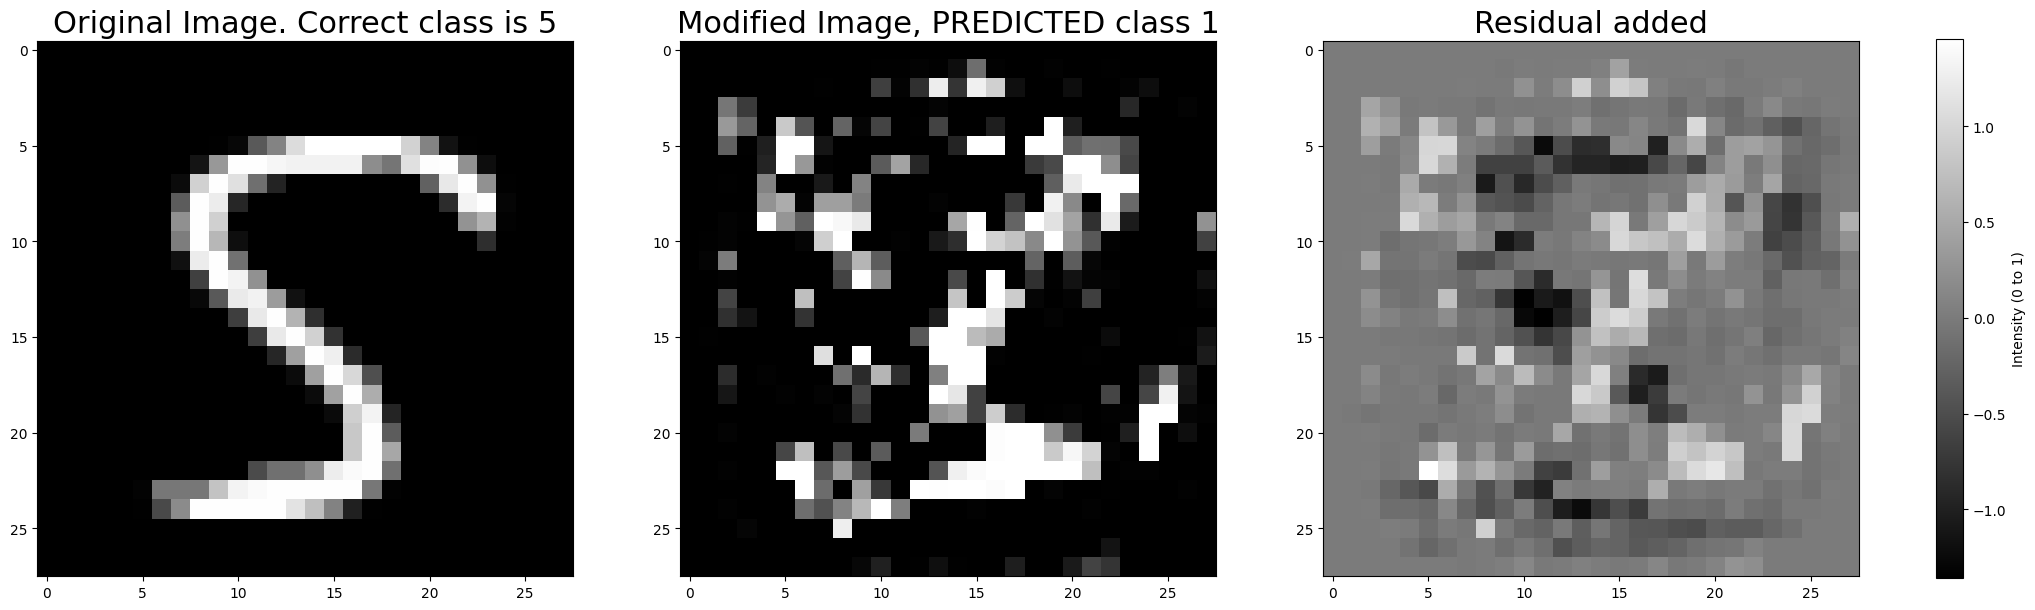

The true class is 4, the new class will be 0
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 0 iterations
Norm Perturbation |r|: 9170.9091796875


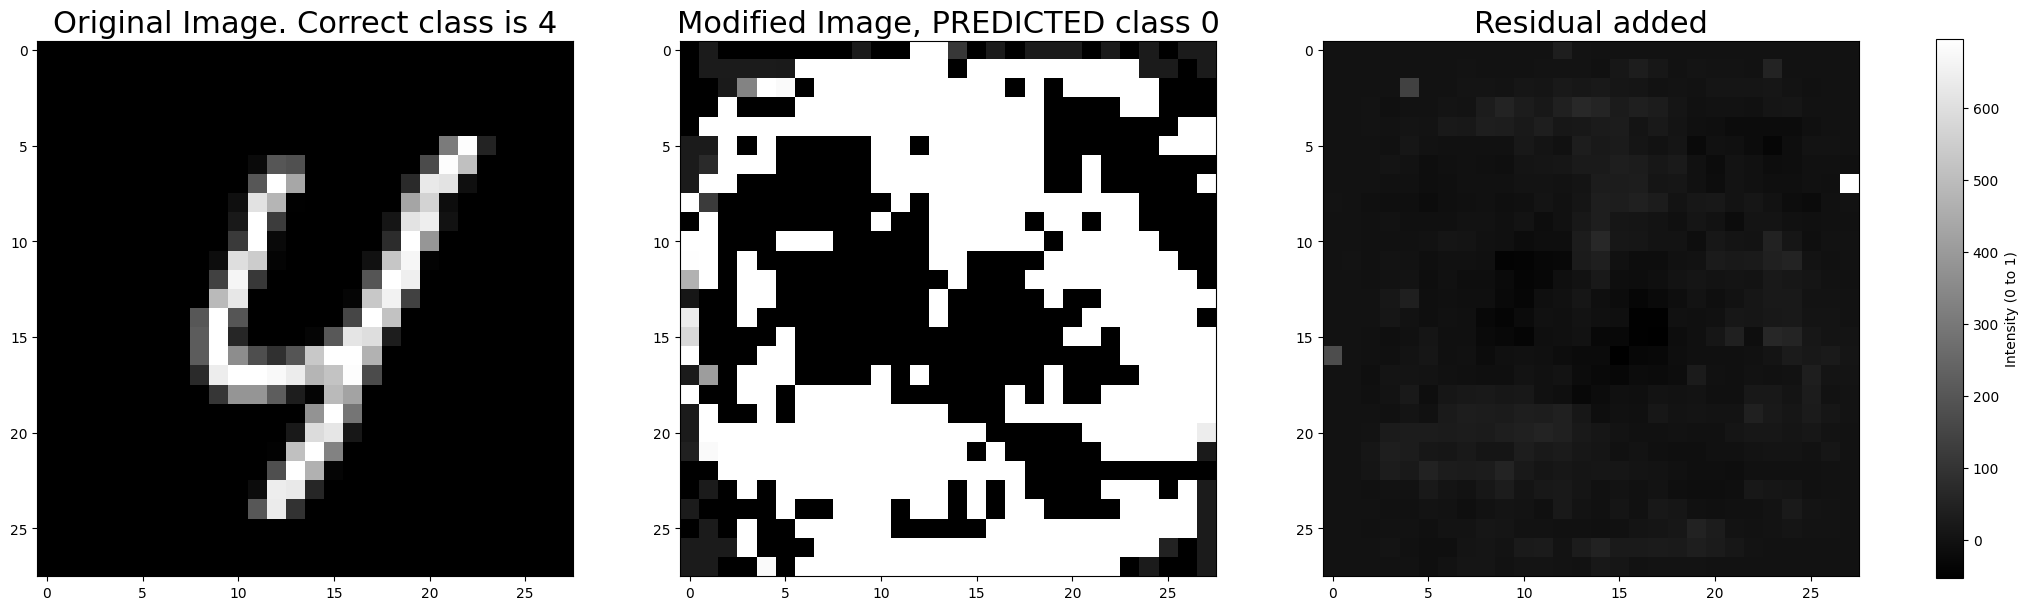

The true class is 7, the new class will be 1
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 0 iterations
Norm Perturbation |r|: 1132.5228271484375


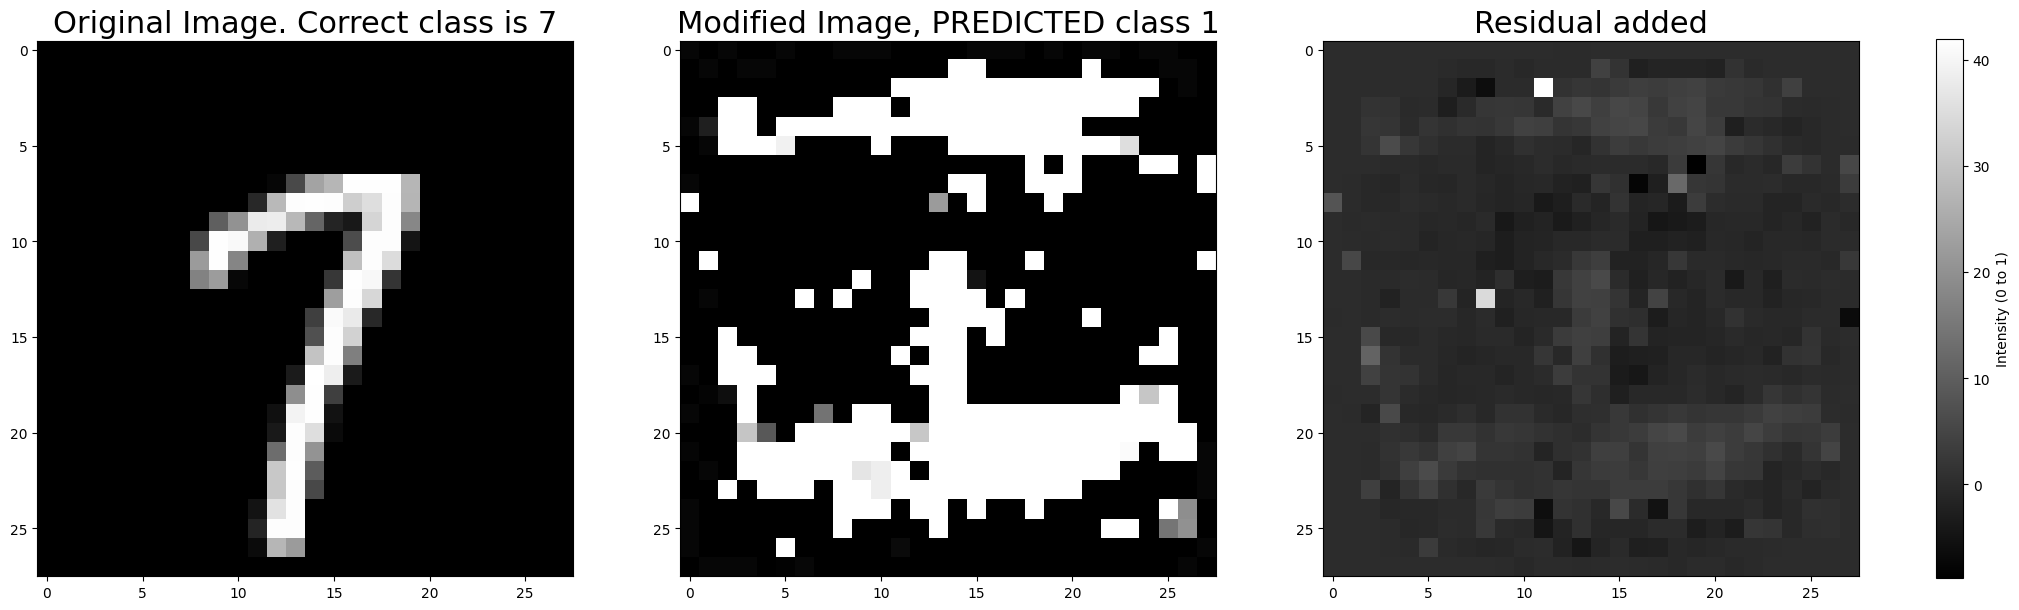

The true class is 1, the new class will be 9
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 0 iterations
Norm Perturbation |r|: 554.622314453125


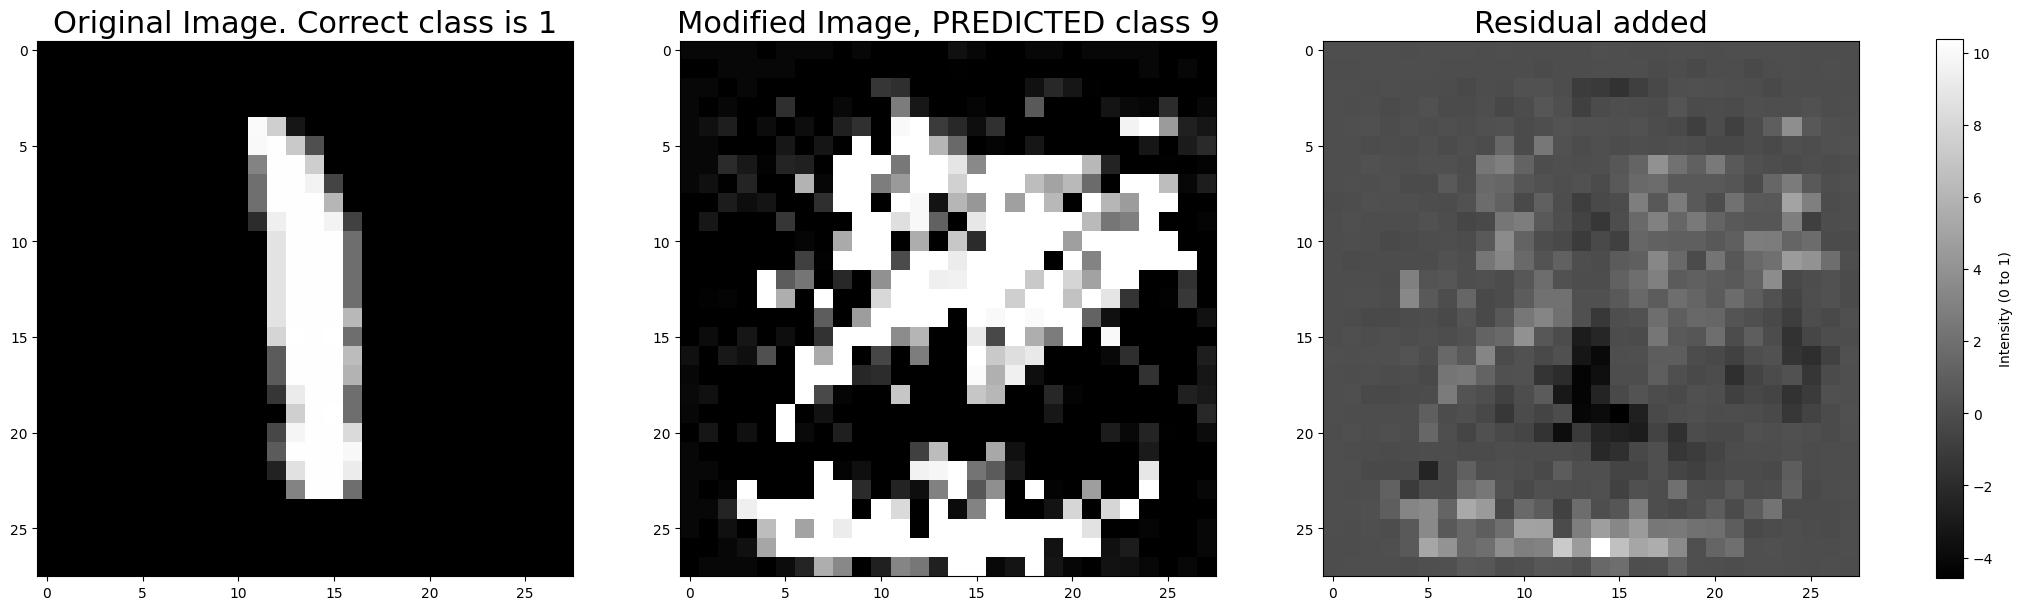

The true class is 2, the new class will be 0
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 0 iterations
Norm Perturbation |r|: 108.60392761230469


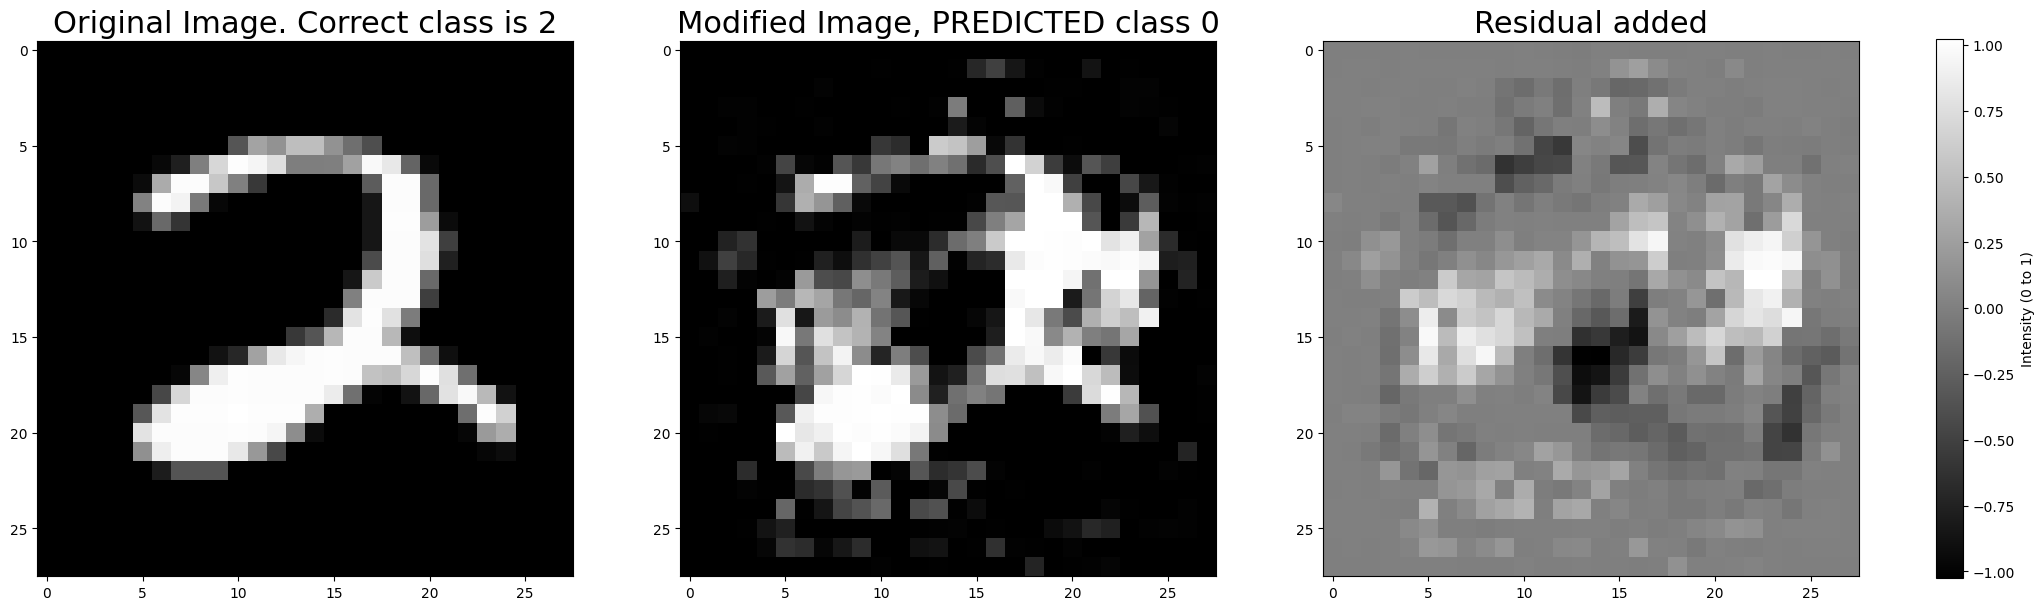

In [35]:
img_indices = [111, 222, 333, 555, 666, 777, 888]

# test with initial_c = 0.000001
for index in img_indices:
    testI, testY = mnist_test.__getitem__(index)

    # generate target label that is different from true label testY
    l = np.random.choice([i for i in range(10) if i != testY])
    test_perturbation_with_c_and_l(
        testI,
        model,
        true_label=testY,
        initial_c=initial_c,
        max_c=max_c,
        max_iter_search=max_iter_search,
        l=l,
        device="cuda",
    )

The true class is 7, the new class will be 9
Found c = 0.000010 satisfying f(x + r) = l
Optimization succeeded with c = 0.000010 in 0 iterations
Norm Perturbation |r|: 28.646671295166016


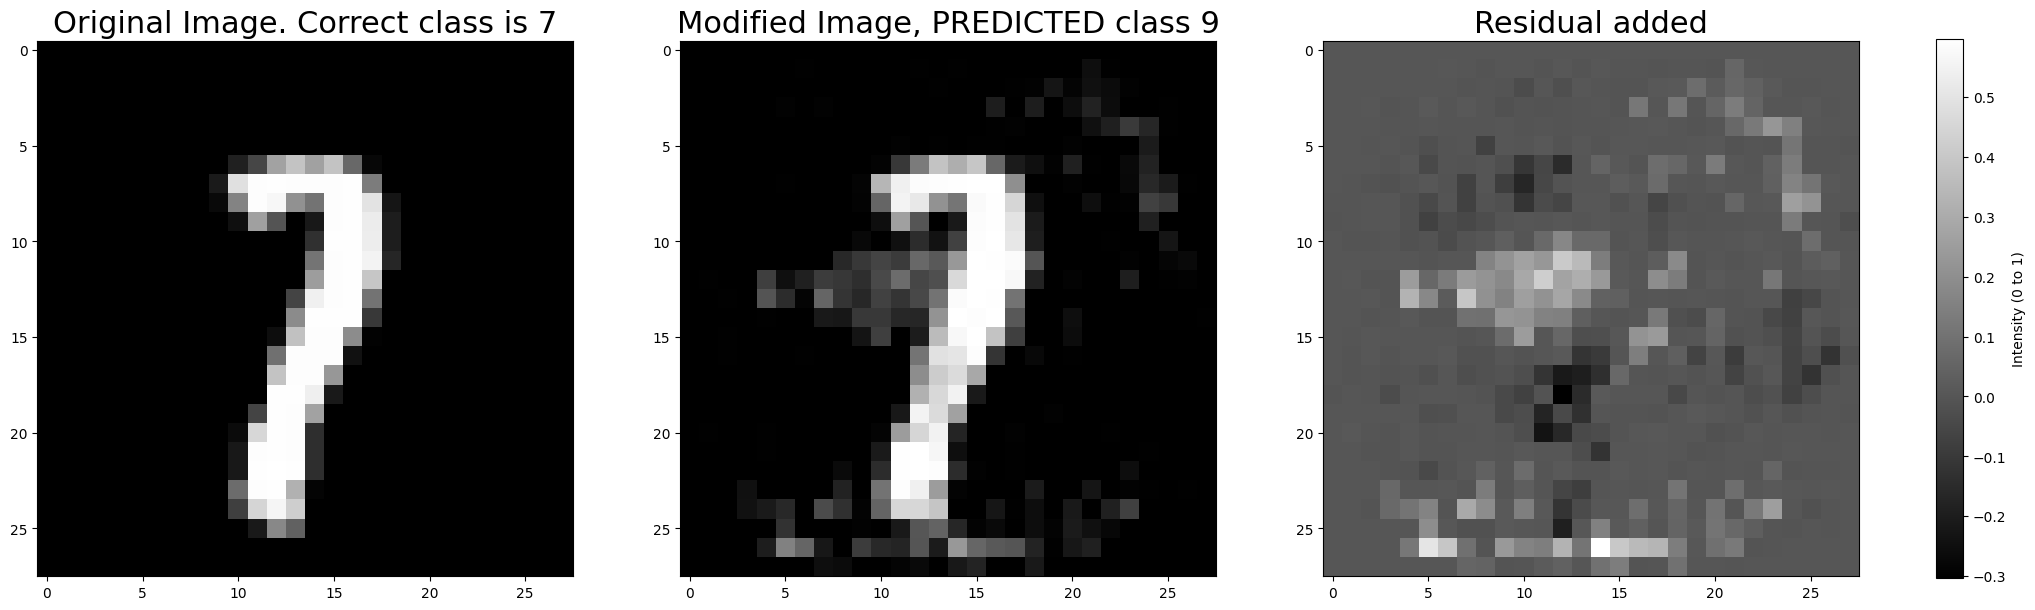

The true class is 2, the new class will be 7
Found c = 0.000010 satisfying f(x + r) = l
Optimization succeeded with c = 0.000010 in 0 iterations
Norm Perturbation |r|: 42.746585845947266


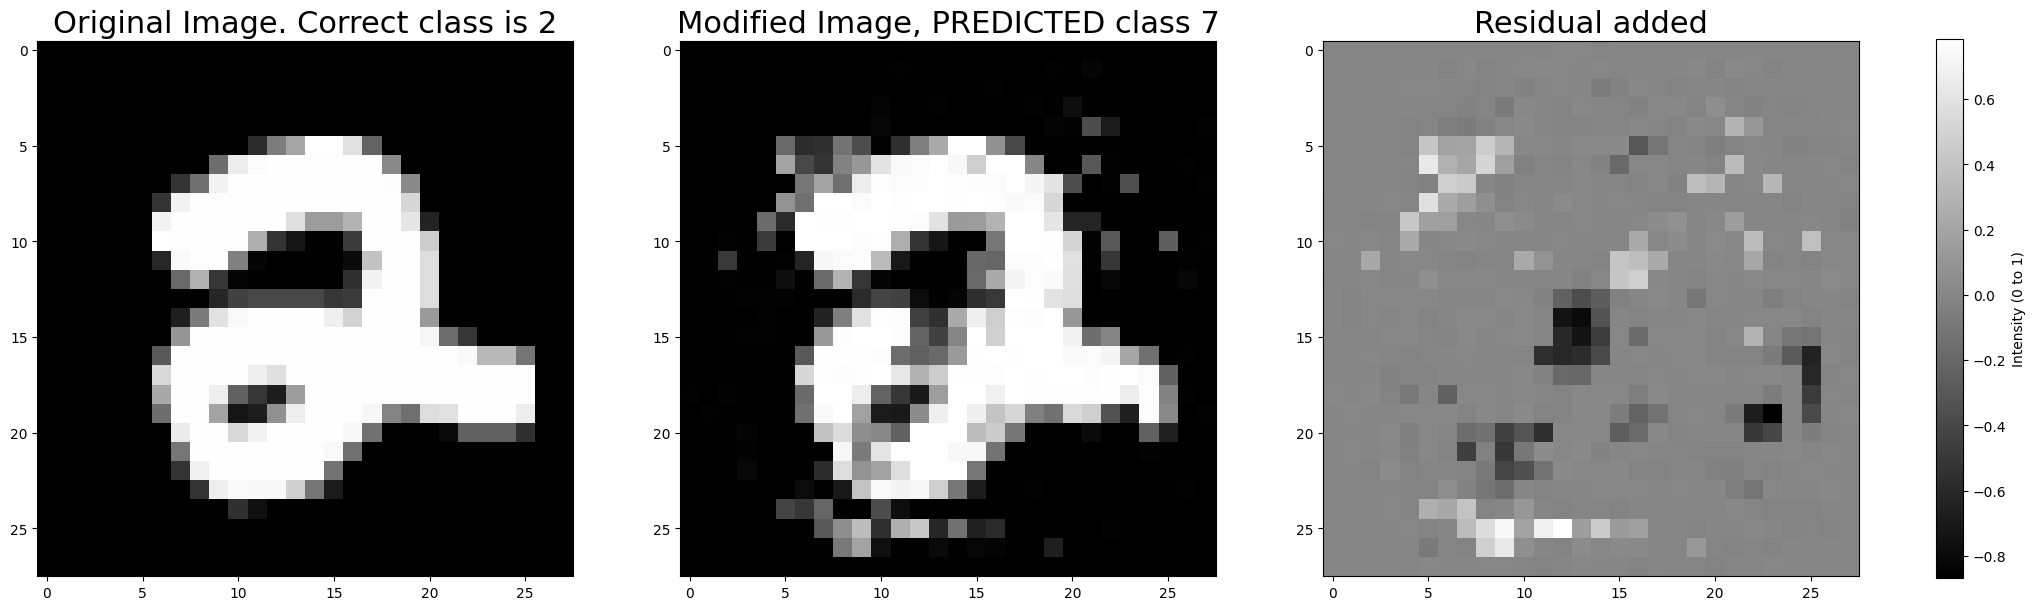

The true class is 5, the new class will be 4
Found c = 0.000010 satisfying f(x + r) = l
Optimization succeeded with c = 0.000010 in 0 iterations
Norm Perturbation |r|: 114.40419006347656


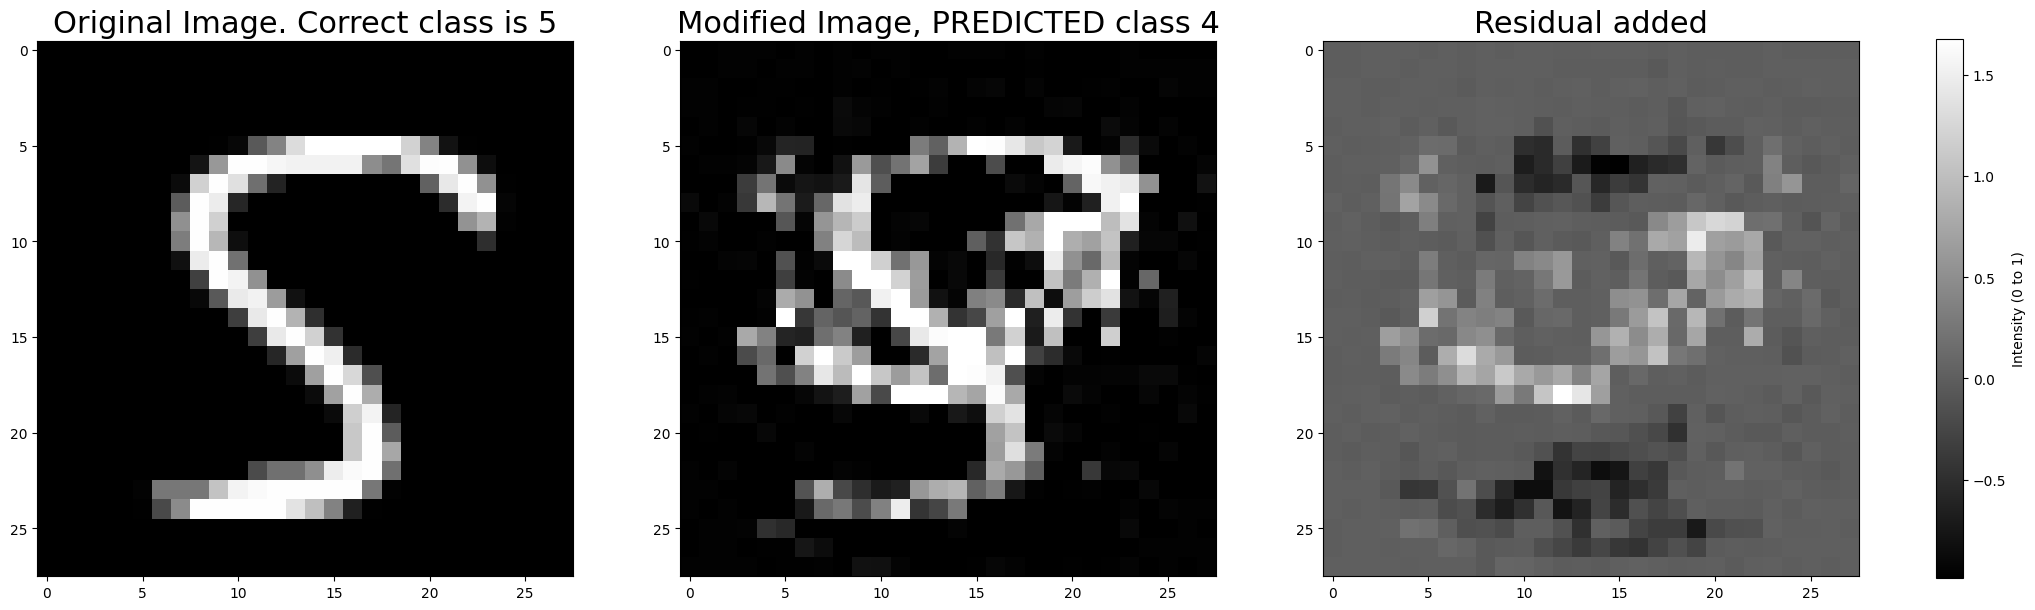

The true class is 4, the new class will be 3
Found c = 0.000010 satisfying f(x + r) = l
Optimization succeeded with c = 0.000010 in 0 iterations
Norm Perturbation |r|: 50.902374267578125


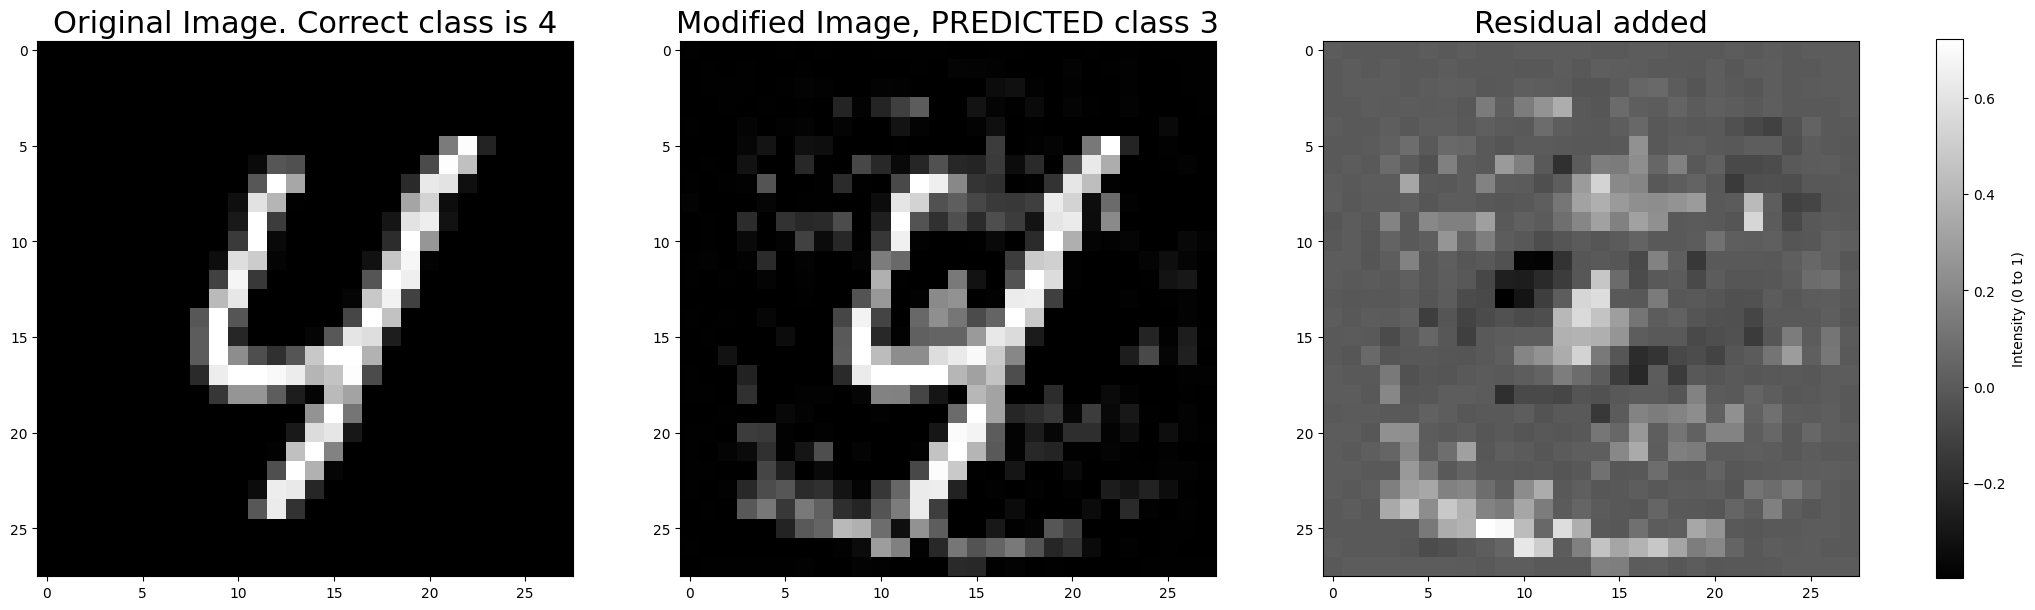

The true class is 7, the new class will be 0
Found c = 0.000010 satisfying f(x + r) = l
Optimization succeeded with c = 0.000010 in 0 iterations
Norm Perturbation |r|: 181.75332641601562


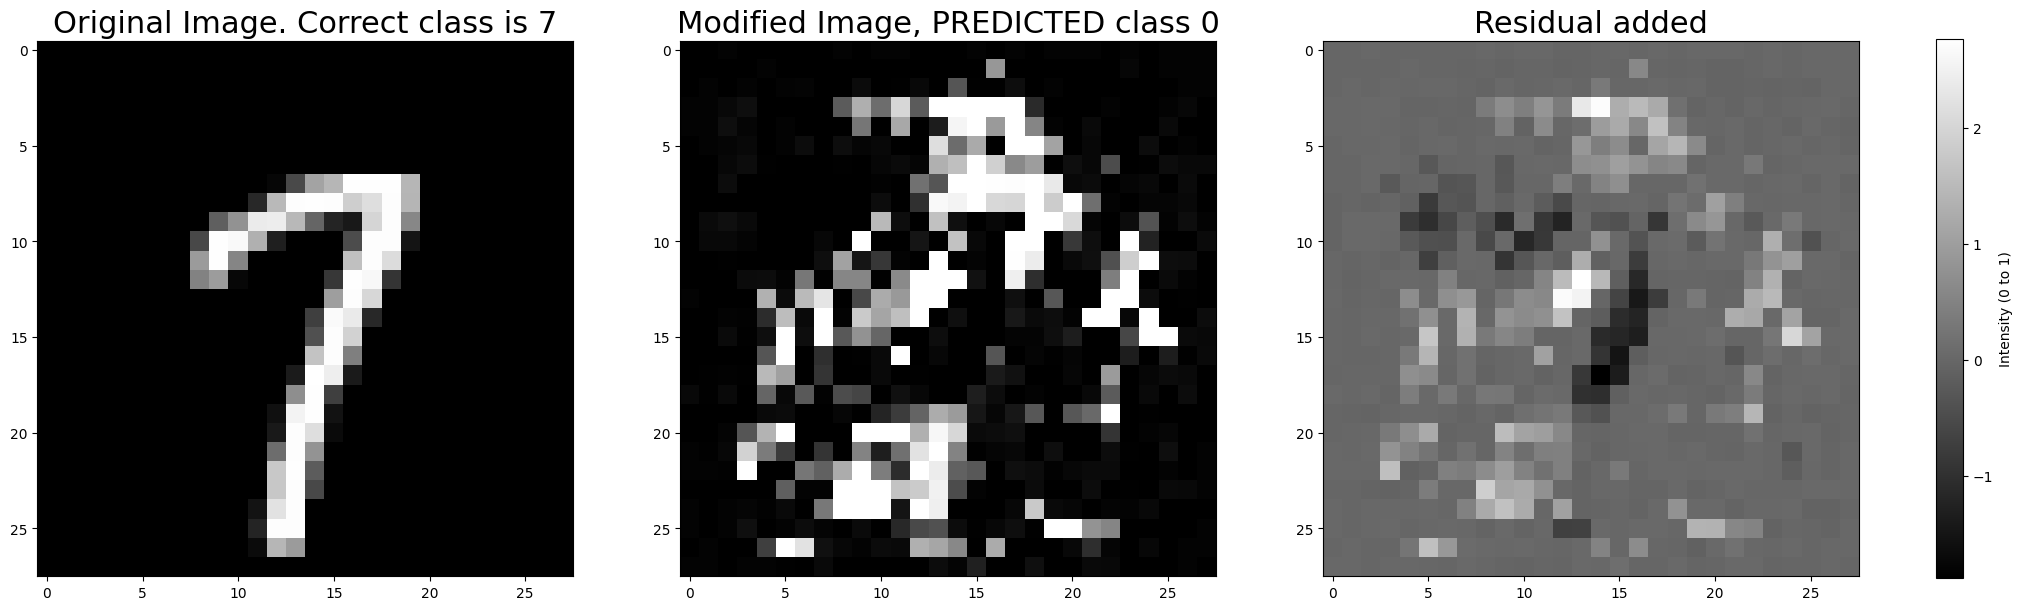

The true class is 1, the new class will be 5
Found c = 0.000010 satisfying f(x + r) = l
Optimization succeeded with c = 0.000010 in 0 iterations
Norm Perturbation |r|: 1517473.5


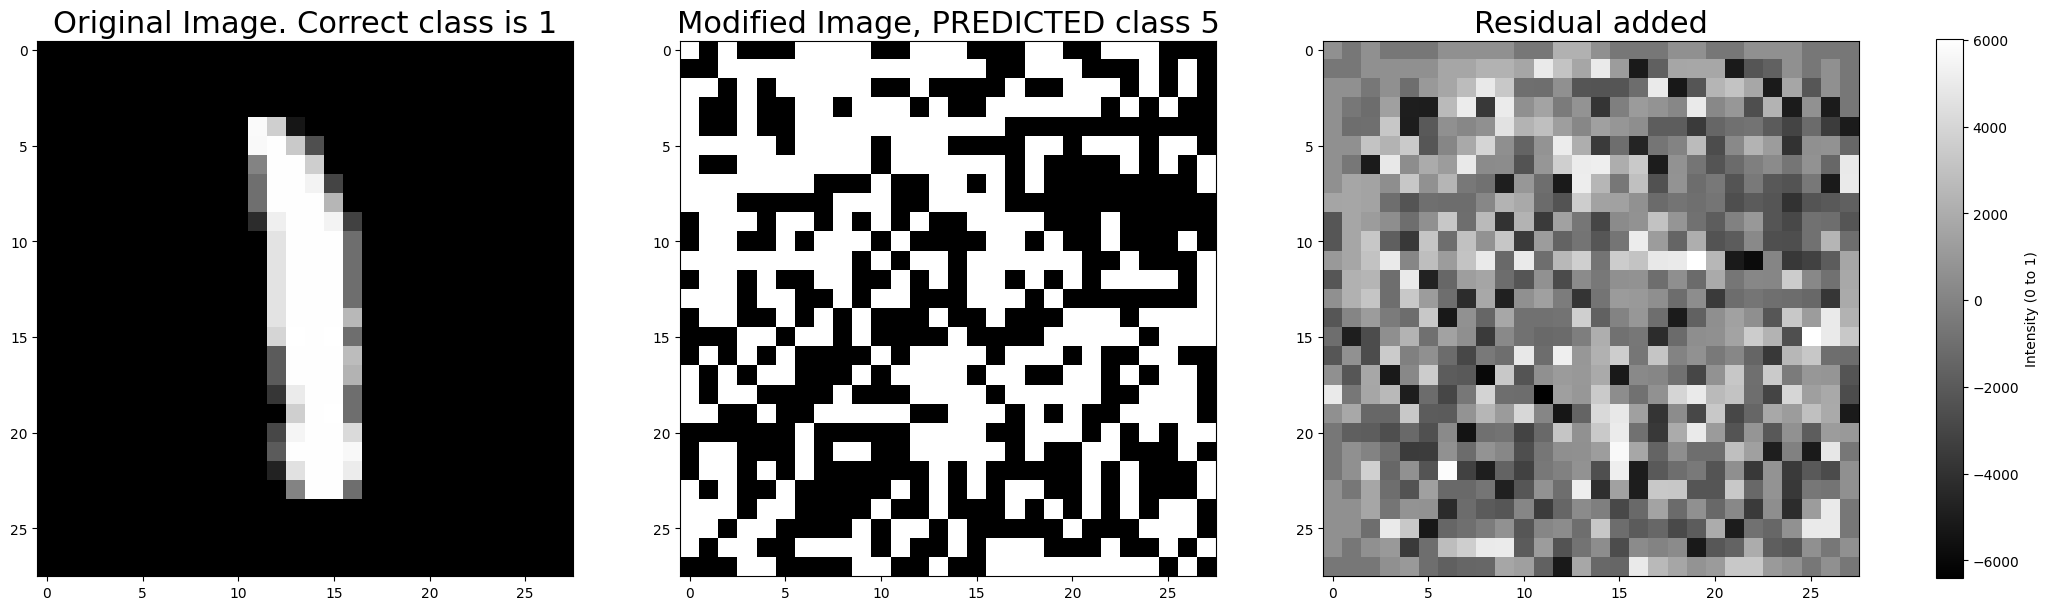

The true class is 2, the new class will be 7
Found c = 0.000010 satisfying f(x + r) = l
Optimization succeeded with c = 0.000010 in 0 iterations
Norm Perturbation |r|: 64.52891540527344


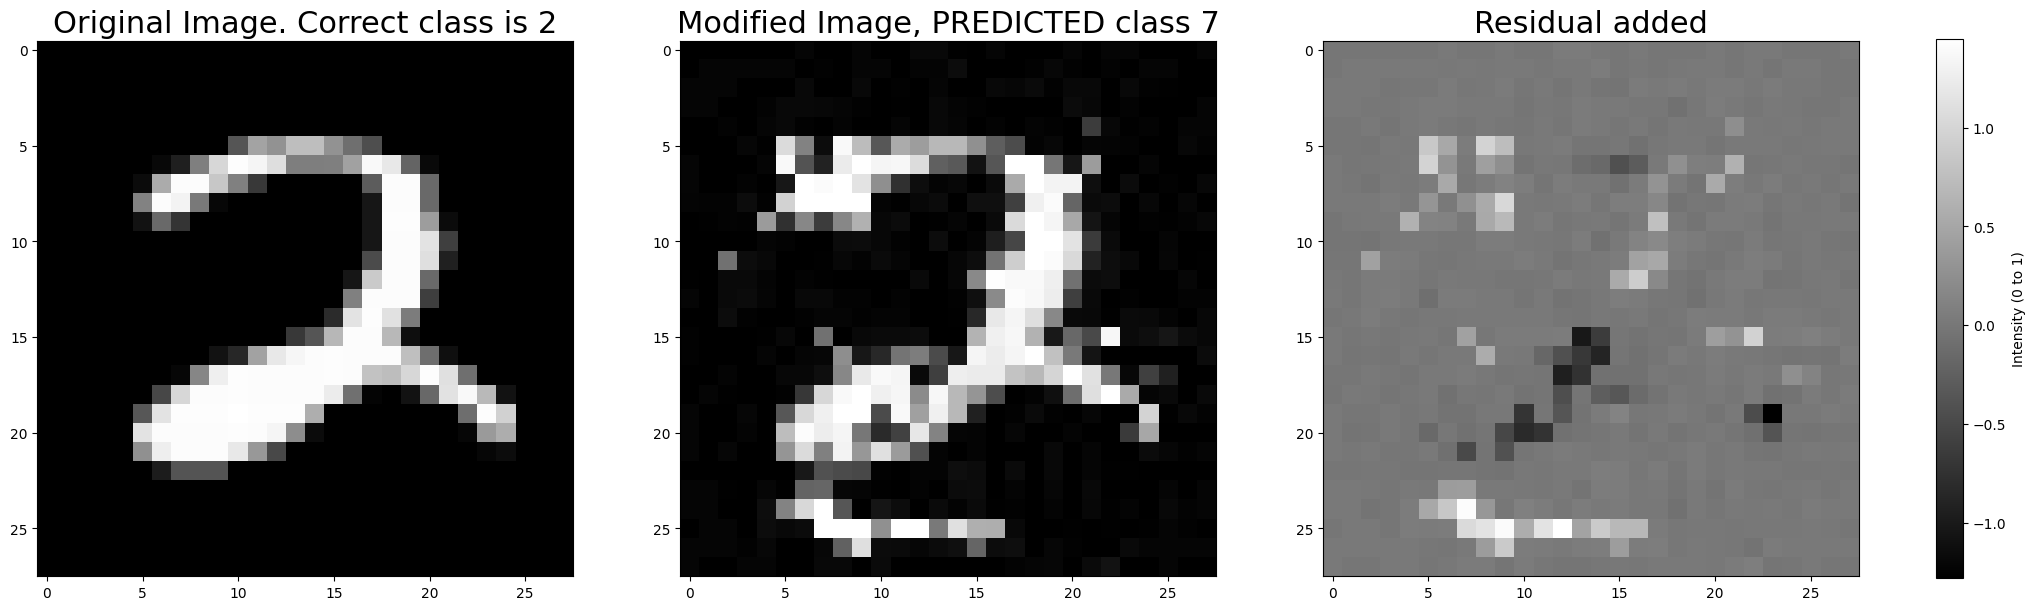

In [36]:
# test with initial_c = 0.00001
for index in img_indices:
    testI, testY = mnist_test.__getitem__(index)
    l = np.random.choice([i for i in range(10) if i != testY])
    test_perturbation_with_c_and_l(
        testI,
        model,
        true_label=testY,
        initial_c=0.00001,
        max_c=max_c,
        max_iter_search=max_iter_search,
        l=l,
        device="cuda",
    )

**QUESTION** Try with different images and different predicted classes (l), does the algorithm always converge ? You can test with different hyper-parameters for c. When it converges, are the images semantically similar to the original one ? Visually, would you say that they should belong to the original or new class ? What's the average distortion (norm of r) ?

### Answer
In the experiments above, I tested multiple images using two different initial values of the regularization parameter \( c \):  
- c = 0.000001  
- c = 0.00001  

Observations
- The algorithm consistently converged with both initial values of c in the first iteratation.
- Upon convergence, the modified images exhibited significant differences from the original ones.
- Visually, it was challenging for human observers to discern any meaningful similarity between the original and perturbed images, making it difficult to justify classifying them into either the original or the target class.

Perturbation Behavior
- The norm of the perturbation r varied significantly across different images.
- This variation led to diverse types of noise being added to the original images, resulting in considerable differences in the final perturbed images.

---


**Question** What if you try with different networks ? Test with al least another network (i.e., change hidden_sizes) and see if the previous conclusions are still confirmed.

Furthermore, check the cross-network performance. This means:
- produce a set of adversarial instances for a given network (samples that are visually similar to the original class but recognised by the network as belonging to a different class)
- check if these adversarial examples are also wrongly classified by the other network

Which conclusions can you draw from these results ? Please comment on that.

### Answer

#### 1. Here I trained another model with hidden_sizes = [200, 100]

In [37]:
input_size = 28 * 28
hidden_sizes = [200, 100]
output_size = 10

# Model
model2 = FullyConnectedNet(input_size, hidden_sizes, output_size).to(device)
# Optimizer
optimizer = optim.Adam(model2.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Print the model
print(model2)

# Training loop
training(model2, train_loader, optimizer, num_epochs, loss_model)

# Evaludation
evaluation(model2, test_loader)

FullyConnectedNet(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)
Epoch [1/10], Step [100/235], Loss: 0.3994
Epoch [1/10], Step [200/235], Loss: 0.2275
Epoch [2/10], Step [100/235], Loss: 0.2242
Epoch [2/10], Step [200/235], Loss: 0.1907
Epoch [3/10], Step [100/235], Loss: 0.1890
Epoch [3/10], Step [200/235], Loss: 0.1255
Epoch [4/10], Step [100/235], Loss: 0.1421
Epoch [4/10], Step [200/235], Loss: 0.1262
Epoch [5/10], Step [100/235], Loss: 0.0706
Epoch [5/10], Step [200/235], Loss: 0.0835
Epoch [6/10], Step [100/235], Loss: 0.0911
Epoch [6/10], Step [200/235], Loss: 0.0386
Epoch [7/10], Step [100/235], Loss: 0.0663
Epoch [7/10], Step [200/235], Loss: 0.0725
Epoch [8/10], Step [100/235], Loss: 0.0700
Epoch [8/10], Step [200/235], Loss: 0.0377
Epoch [9/10], Step [100/235], Loss: 0.0282
Ep

#### 2. Redo the previous experiment

The true class is 7, the new class will be 9
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 0 iterations
Norm Perturbation |r|: 43.07884216308594


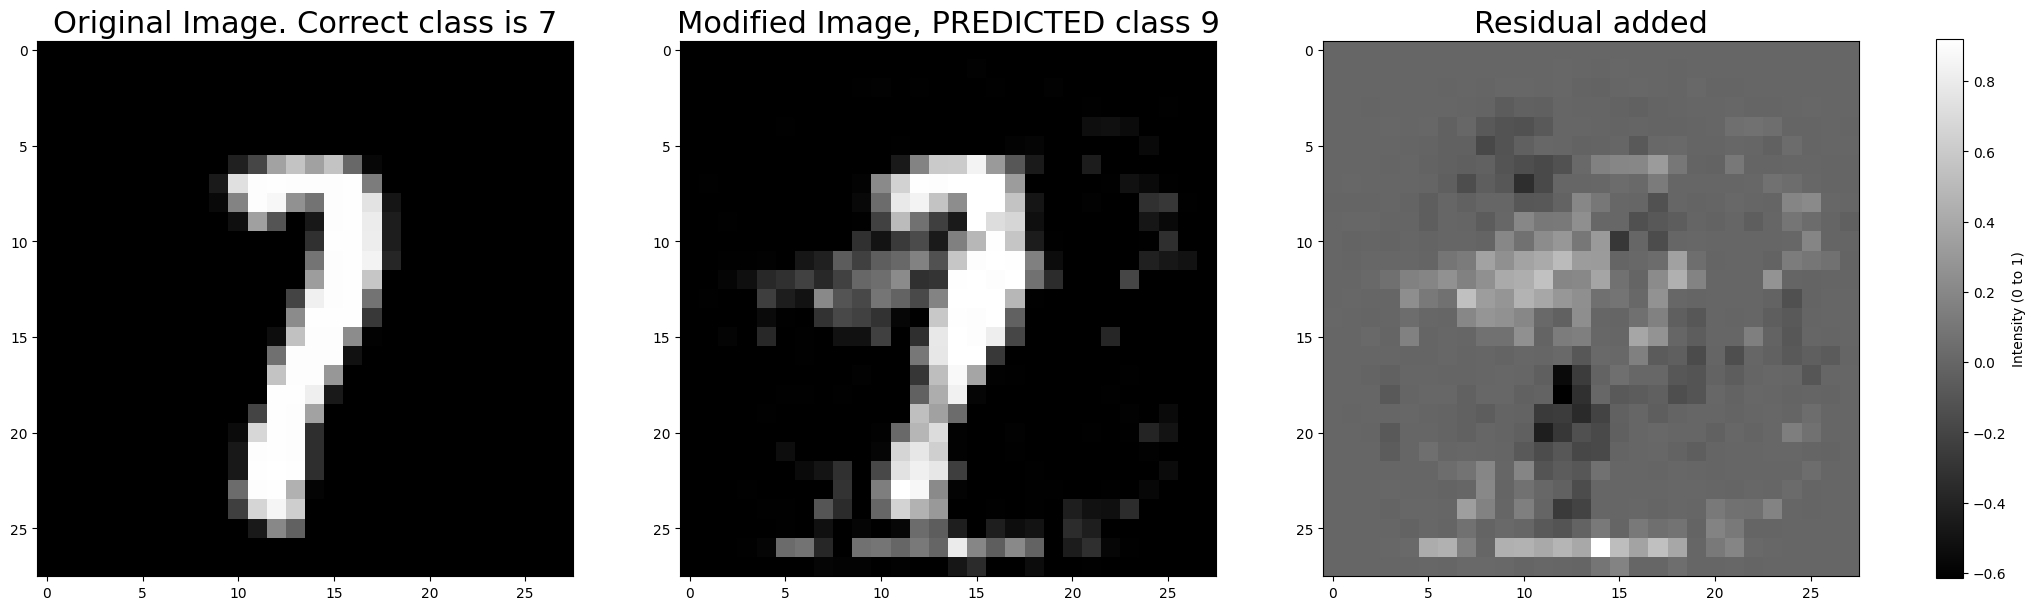

The true class is 2, the new class will be 1
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 0 iterations
Norm Perturbation |r|: 141.82205200195312


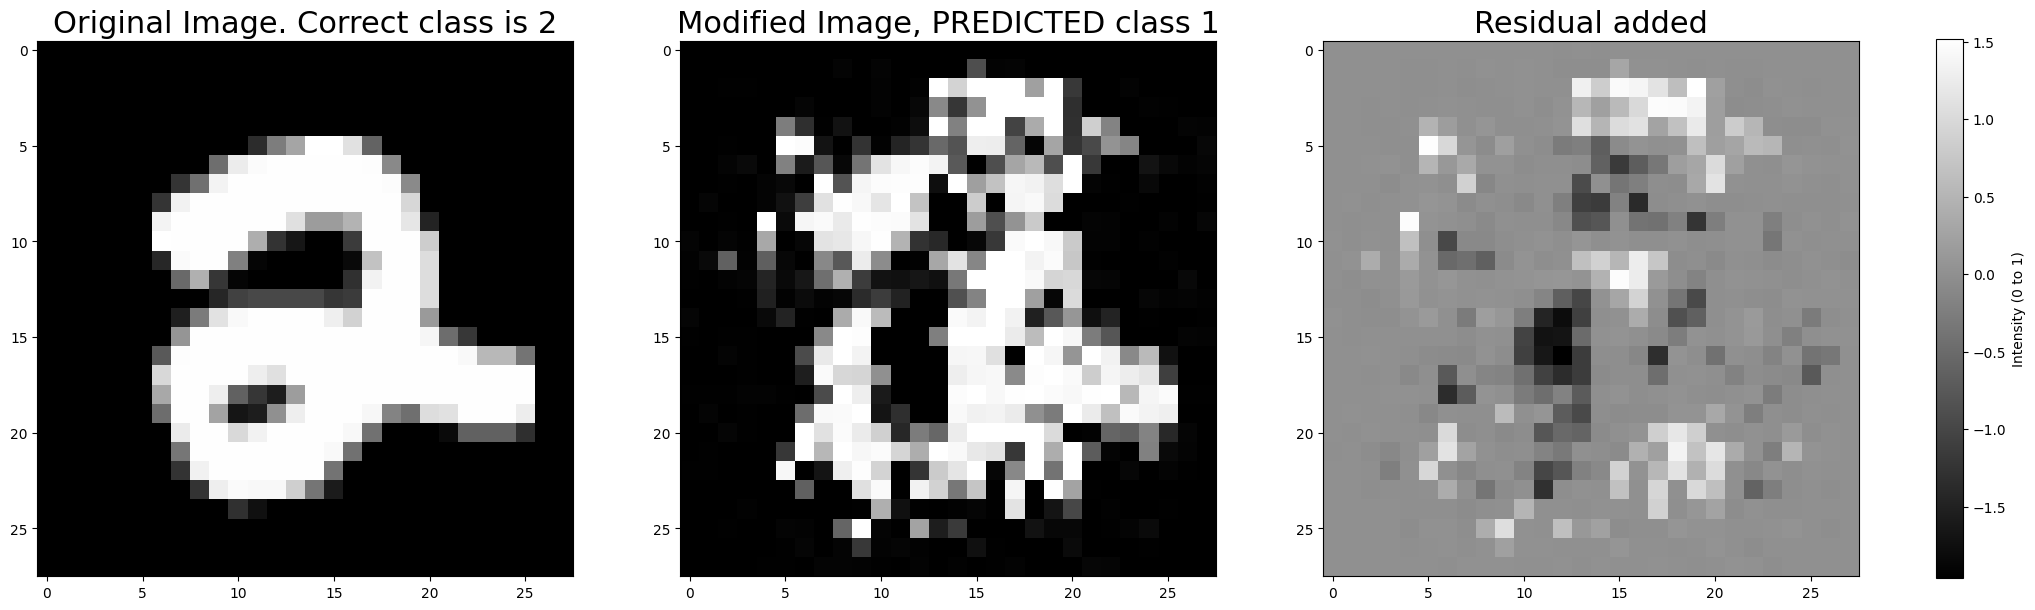

The true class is 5, the new class will be 9
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 0 iterations
Norm Perturbation |r|: 162.9888458251953


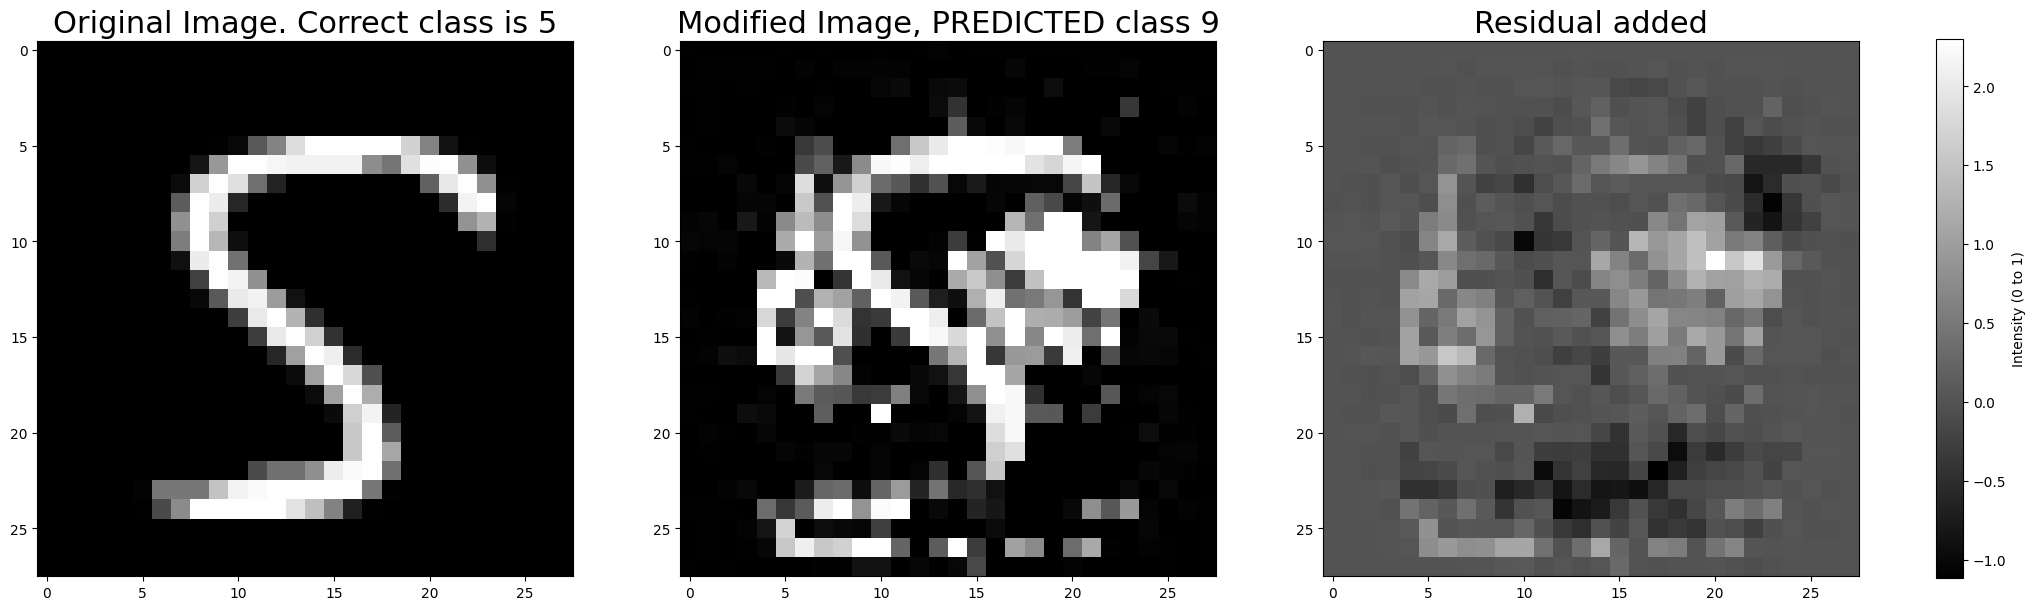

The true class is 4, the new class will be 5
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 0 iterations
Norm Perturbation |r|: 274.83984375


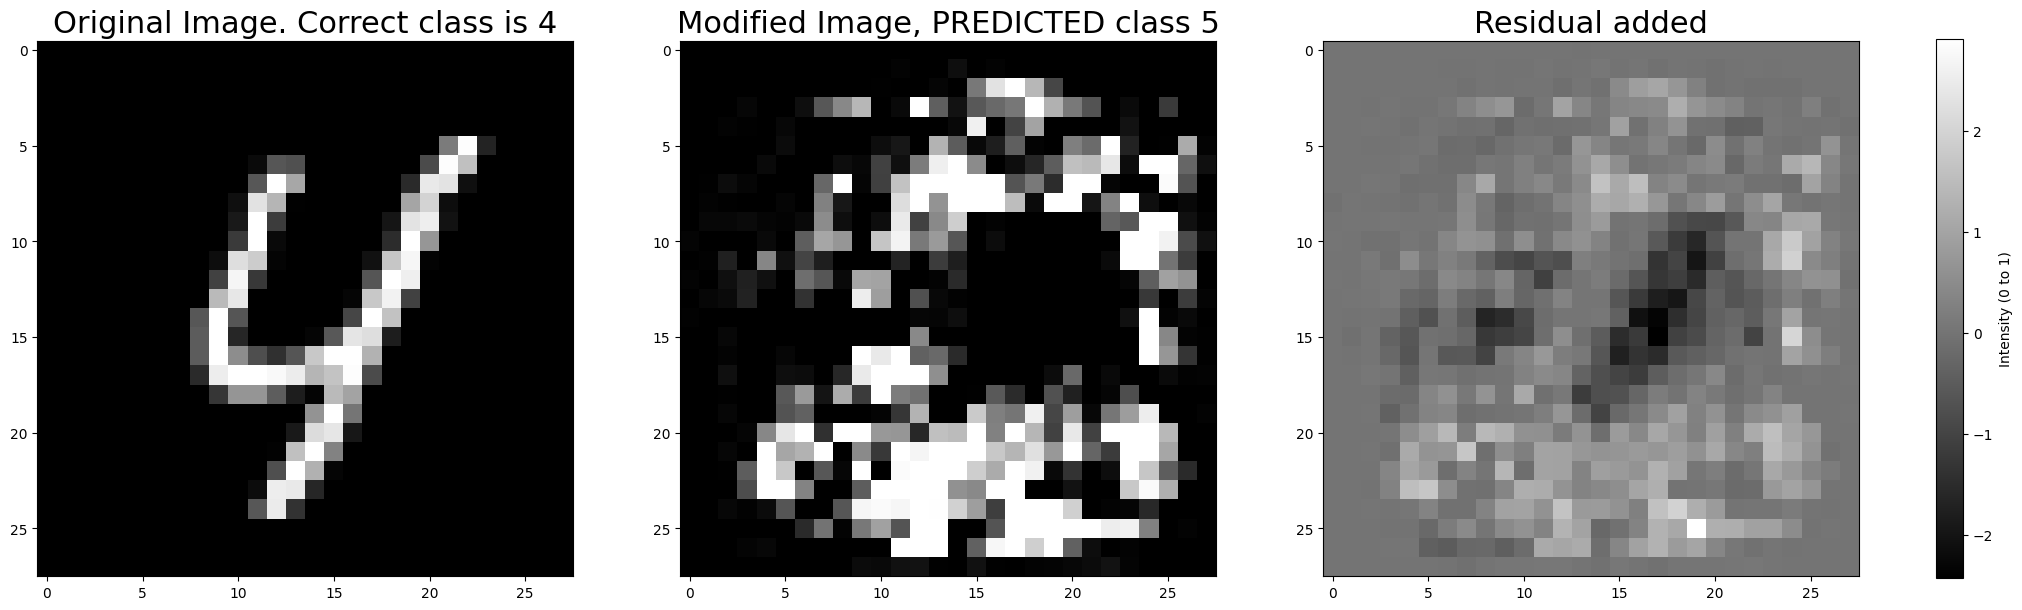

The true class is 7, the new class will be 1
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 0 iterations
Norm Perturbation |r|: 93.4107894897461


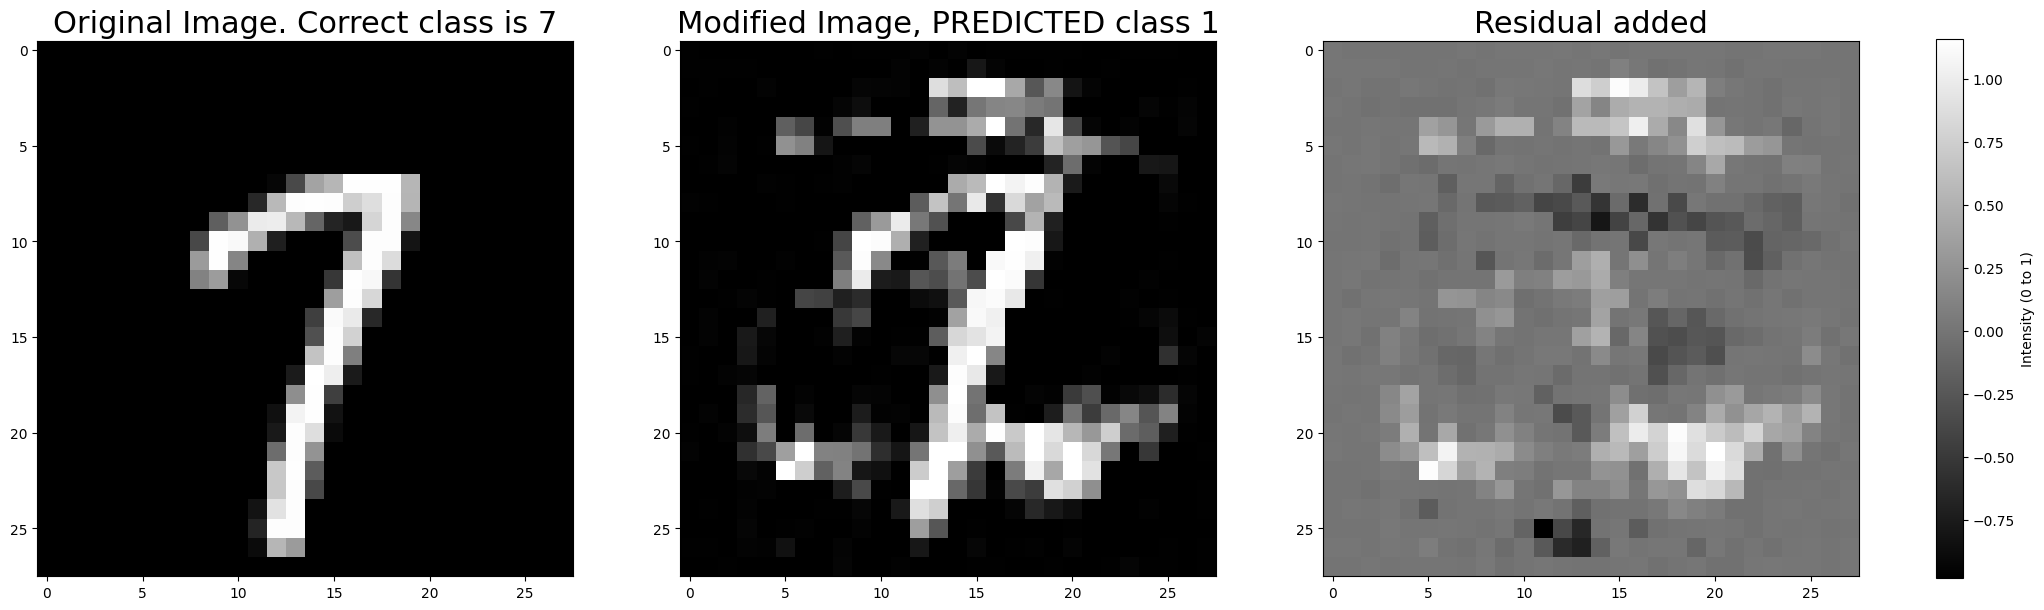

The true class is 1, the new class will be 4
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 0 iterations
Norm Perturbation |r|: 372.8812561035156


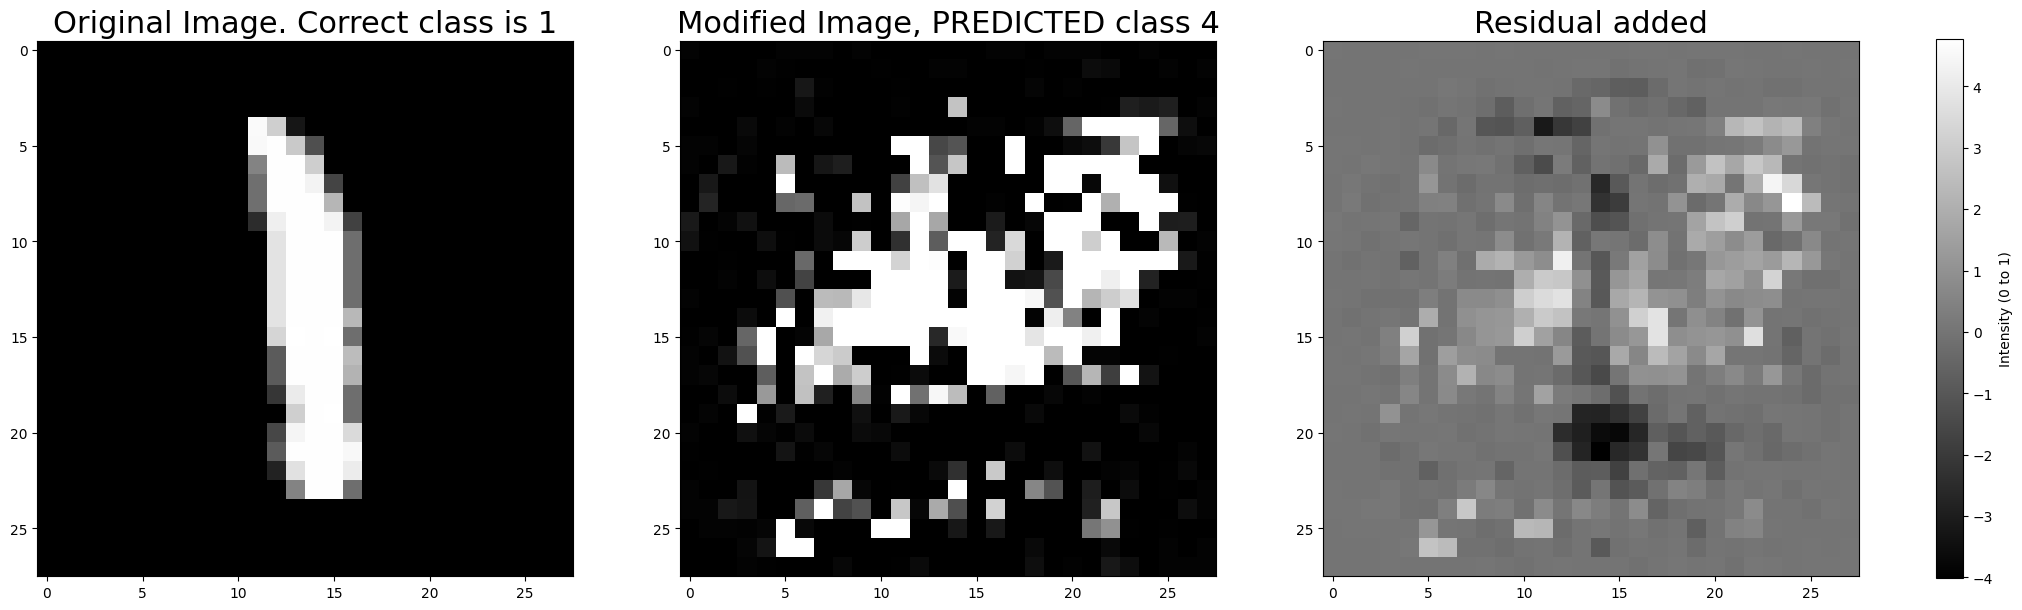

The true class is 2, the new class will be 7
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 0 iterations
Norm Perturbation |r|: 197.24838256835938


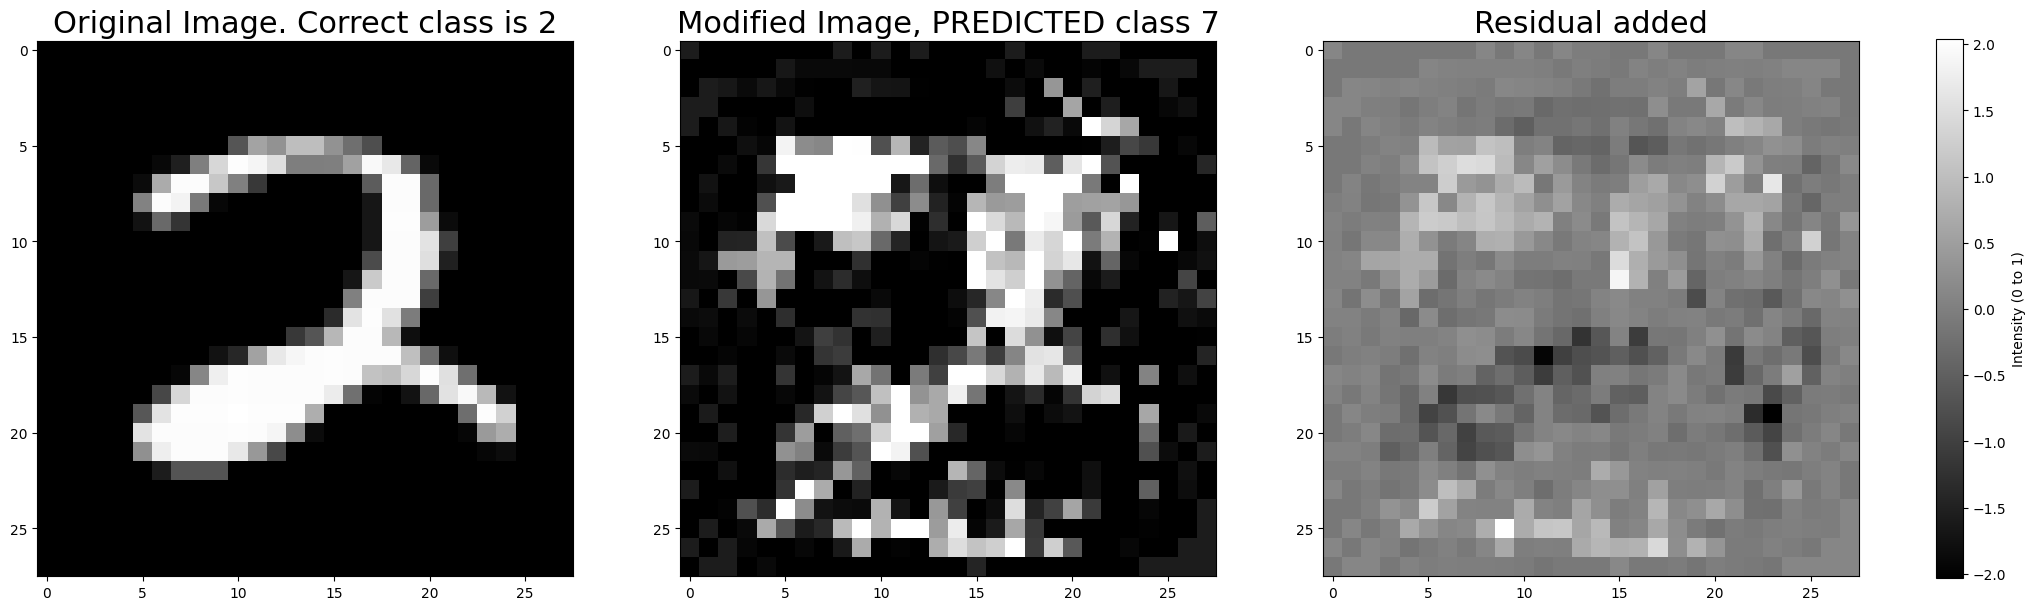

In [38]:
img_indices = [111, 222, 333, 555, 666, 777, 888]

# test with initial_c = 0.000001
for index in img_indices:
    testI, testY = mnist_test.__getitem__(index)

    # generate target label that is different from true label testY
    l = np.random.choice([i for i in range(10) if i != testY])
    test_perturbation_with_c_and_l(
        testI,
        model2,
        true_label=testY,
        initial_c=0.000001,
        max_c=max_c,
        max_iter_search=max_iter_search,
        l=l,
        device="cuda",
    )

The true class is 7, the new class will be 5
Found c = 0.000010 satisfying f(x + r) = l
Optimization succeeded with c = 0.000010 in 0 iterations
Norm Perturbation |r|: 325.94854736328125


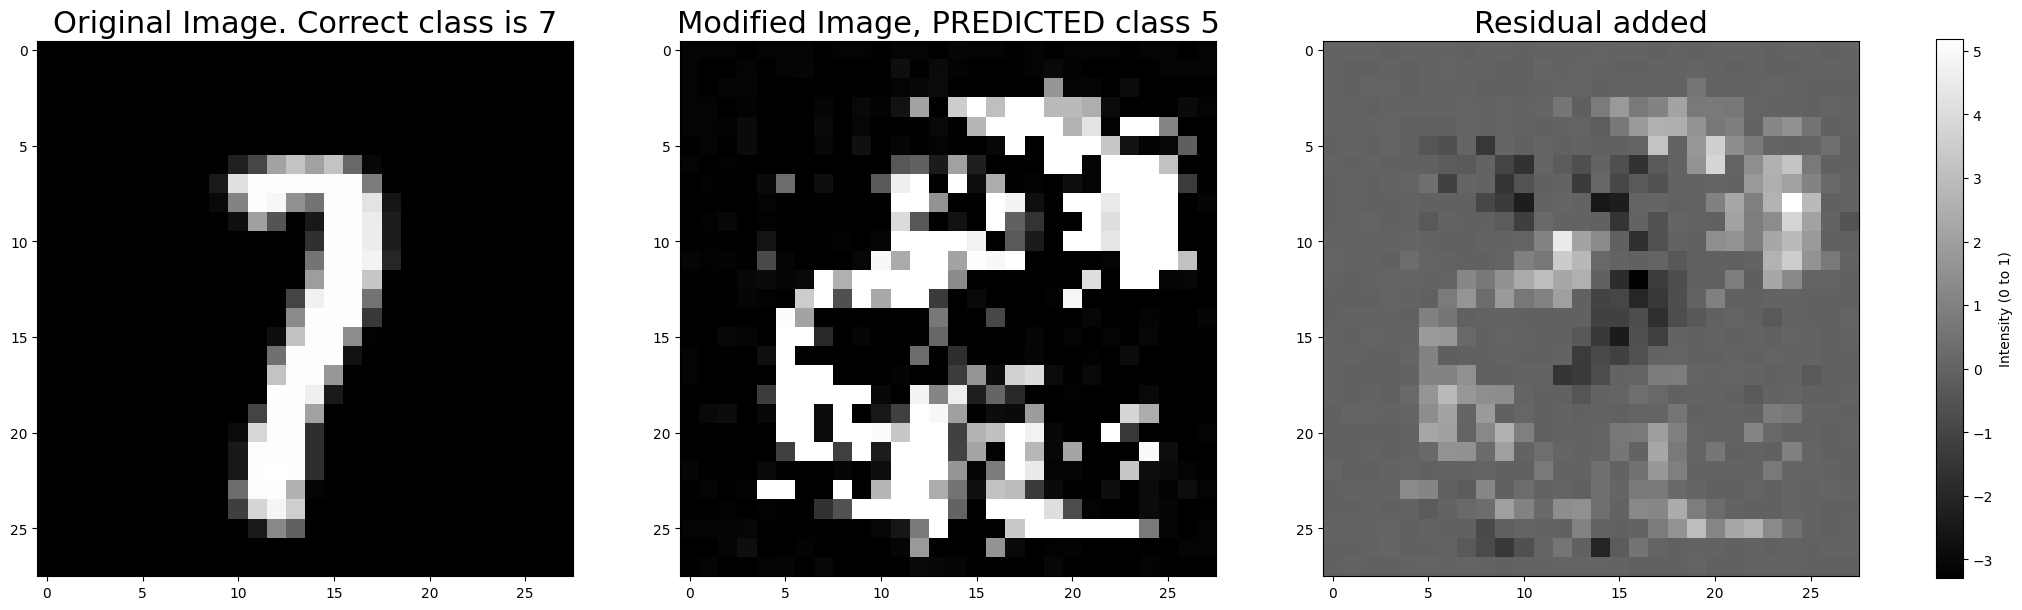

The true class is 2, the new class will be 4
Found c = 0.000010 satisfying f(x + r) = l
Optimization succeeded with c = 0.000010 in 0 iterations
Norm Perturbation |r|: 633.8571166992188


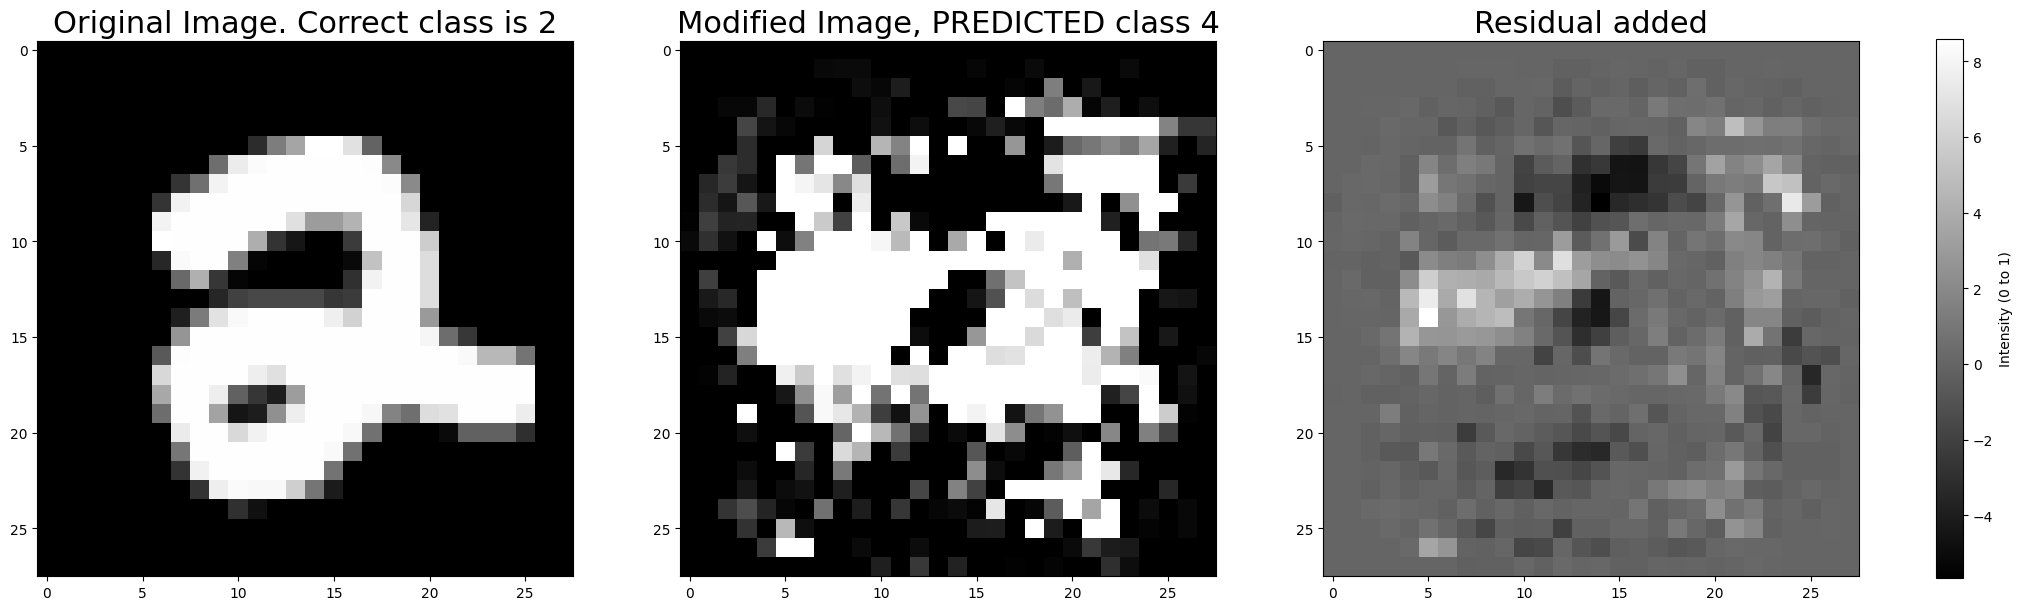

The true class is 5, the new class will be 7
Found c = 0.000010 satisfying f(x + r) = l
Optimization succeeded with c = 0.000010 in 0 iterations
Norm Perturbation |r|: 176.91455078125


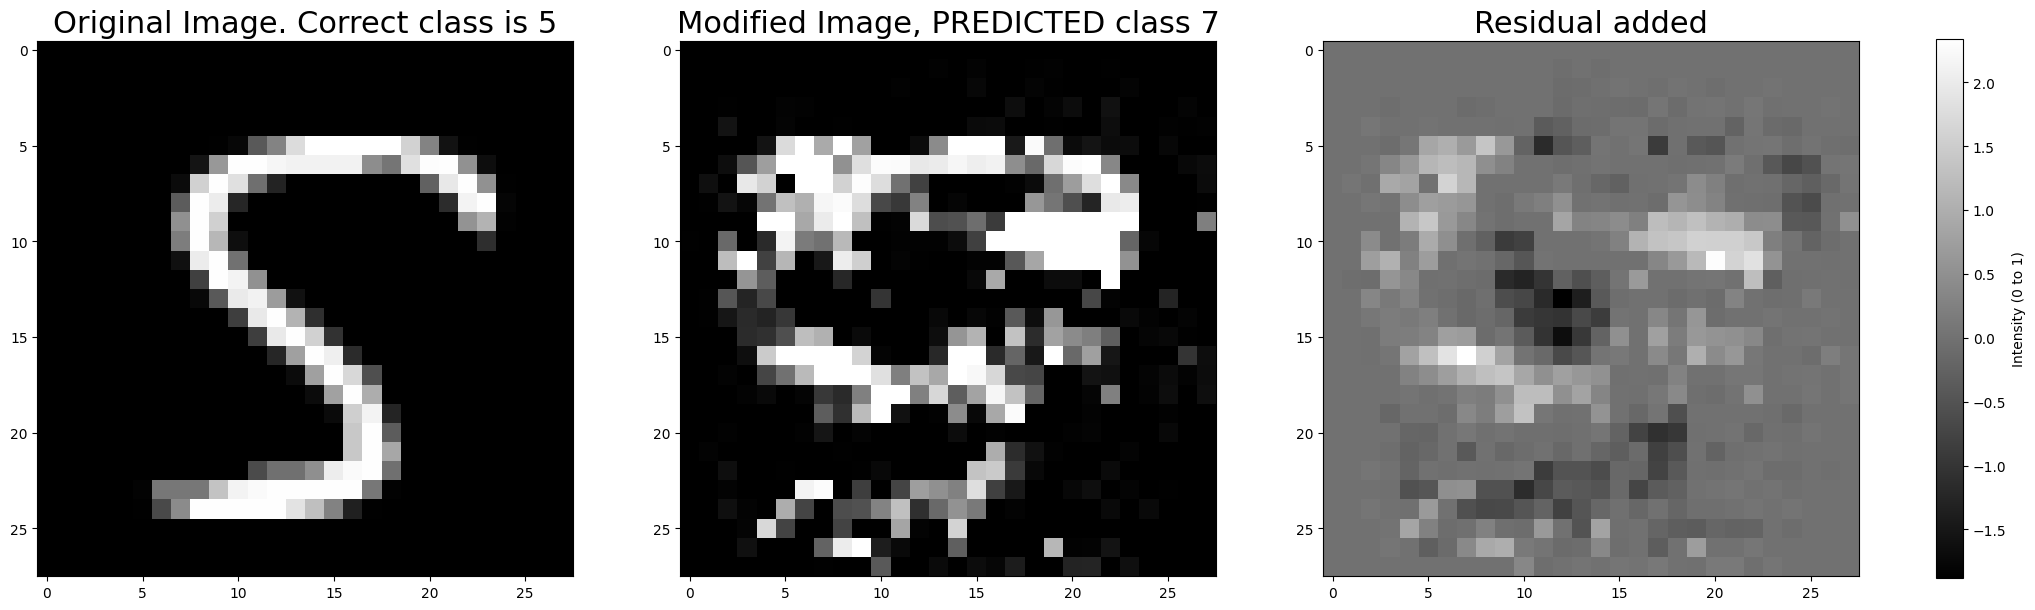

The true class is 4, the new class will be 1
Found c = 0.000010 satisfying f(x + r) = l
Optimization succeeded with c = 0.000010 in 0 iterations
Norm Perturbation |r|: 193.24911499023438


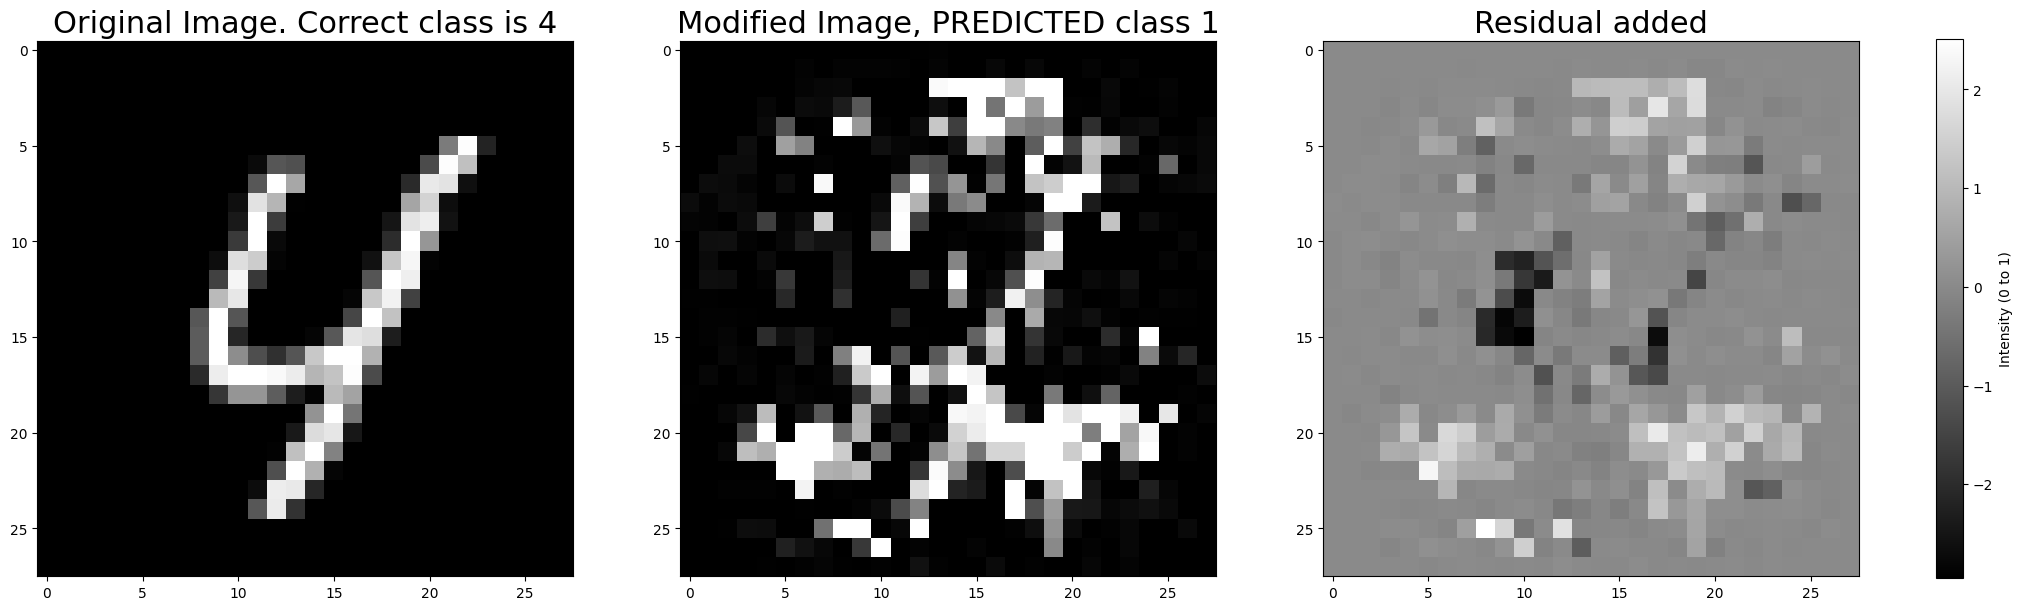

The true class is 7, the new class will be 4
Found c = 0.000010 satisfying f(x + r) = l
Optimization succeeded with c = 0.000010 in 0 iterations
Norm Perturbation |r|: 2900.85888671875


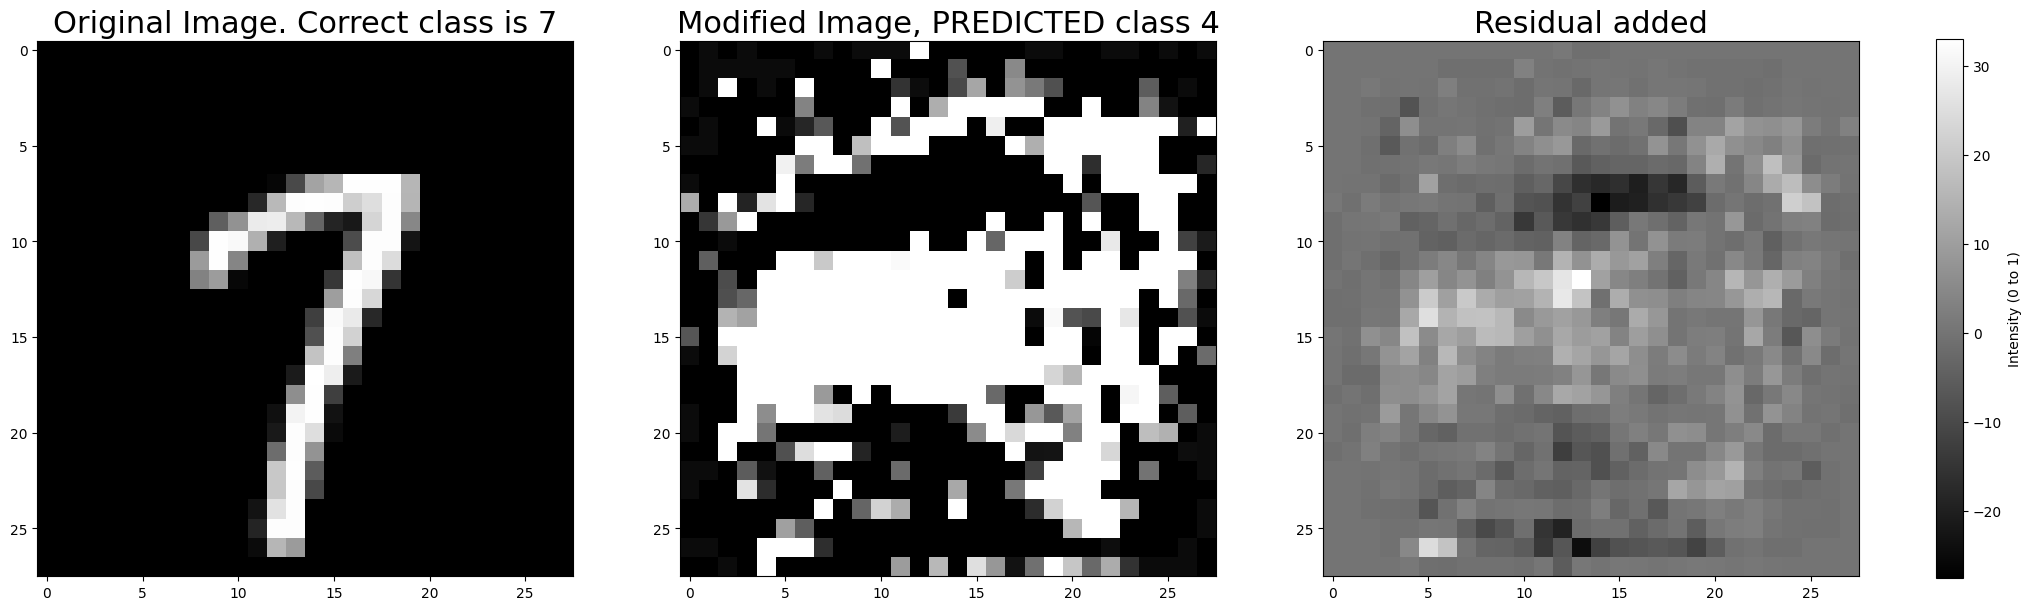

The true class is 1, the new class will be 3
Found c = 0.000010 satisfying f(x + r) = l
Optimization succeeded with c = 0.000010 in 0 iterations
Norm Perturbation |r|: 36.44853973388672


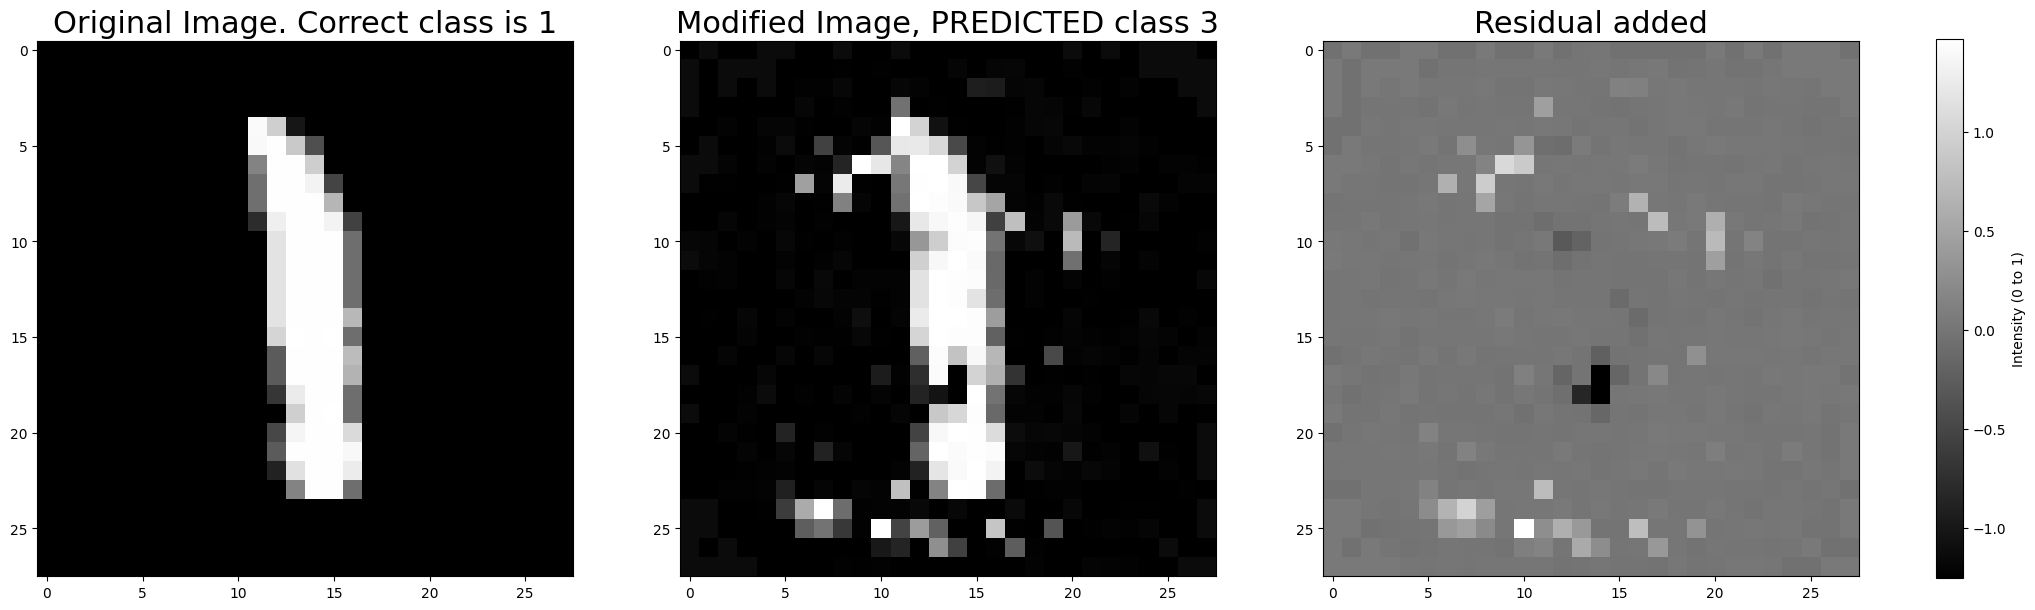

The true class is 2, the new class will be 7
Found c = 0.000010 satisfying f(x + r) = l
Optimization succeeded with c = 0.000010 in 0 iterations
Norm Perturbation |r|: 222.54603576660156


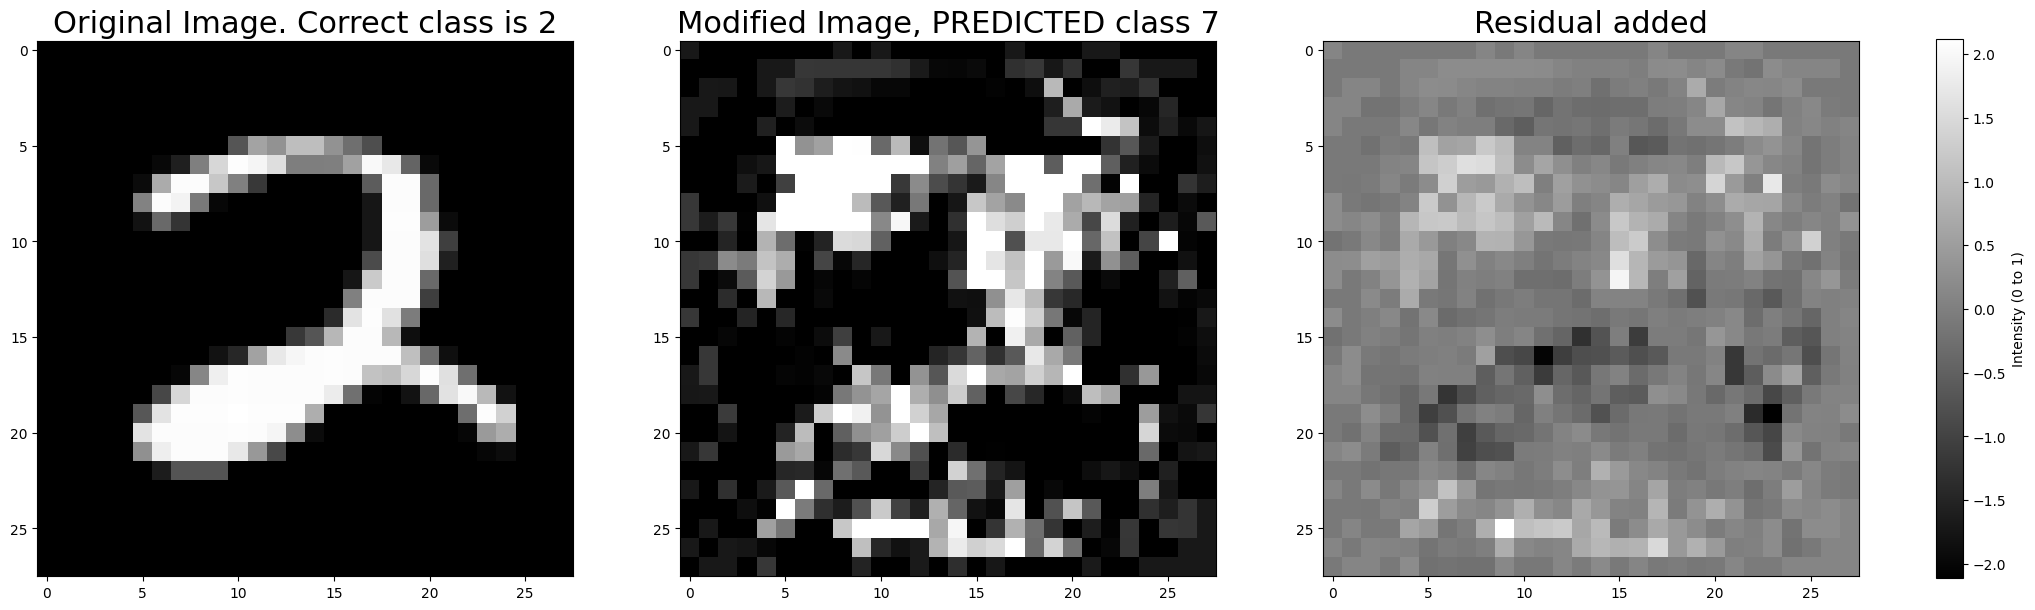

In [39]:
# test with initial_c = 0.00001
for index in img_indices:
    testI, testY = mnist_test.__getitem__(index)
    # generate target label that is different from true label testY
    l = np.random.choice([i for i in range(10) if i != testY])
    test_perturbation_with_c_and_l(
        testI,
        model2,
        true_label=testY,
        initial_c=0.00001,
        max_c=max_c,
        max_iter_search=max_iter_search,
        l=l,
        device="cuda",
    )

#### 3. Comment

Using the same tested images with a different network, the previous conclusions are still confirmed.

#### 4. Now I sample images that are visually similar to the original class but recognised by the network as belonging to a different class

In [40]:
# Sample using network with hidden_sizes = [100, 100]
# Here I restrict the L1-norm of r to make the modified images similar to the original

In [47]:
# Function to test with different values of c and l
def sample_similar_imgs(
    testI, model, true_label, initial_c, max_c, max_iter_search, l, device
):
    """
    This function applies a perturbation to the image `testI` such that it is classified as target label `l`
    using box-constrained L-BFGS optimization. The perturbation is minimized with a regularization parameter `c`.

    Parameters:
    - testI: Input image tensor to be perturbed
    - model: Trained model
    - true_label: True label of the image (for visualization)
    - initial_c: Initial value for the regularization parameter `c`
    - max_c: Maximum value for `c` to avoid infinite loop
    - max_iter_search: Maximum number of iterations for the line search
    - l: Target label for the perturbation
    - device: Device (CPU or GPU) on which the computation is carried out

    Returns:
    - a tuple contains modificationed image and boolean value indicates if it is a good sample
    """

    testI = testI.to(device)
    r = torch.zeros_like(
        testI, requires_grad=True, device=device
    )  # Initialize r as zero
    l = torch.tensor([l]).to(
        device
    )  # Convert target label to tensor and move to device
    l = l.view(1)  # to have a batch size equal to 1 and work with CrossEntropy loss

    print(f"The true class is {true_label}, the new class will be {l[0]}")

    # Define the loss function
    def objective(c, r, x, l):
        # Perturb the image
        x_r = torch.clamp(x + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
        pred = model(x_r)
        classification_loss = torch.nn.CrossEntropyLoss()(pred, l)
        perturbation_loss = c * torch.norm(r, p=1)
        return classification_loss + perturbation_loss

    # Line search to find the minimum c > 0
    c = initial_c
    iter = 0
    while (c <= max_c) and (iter <= max_iter_search):
        # Define the optimizer (Box-Constrained L-BFGS)
        optimizerLBFGS = optim.LBFGS([r])

        def closure():
            optimizerLBFGS.zero_grad()
            loss = objective(c, r, testI, l)
            loss.backward()
            return loss

        # Perform optimization
        optimizerLBFGS.step(closure)

        # Evaluate the condition f(x + r) = l
        with torch.no_grad():
            x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
            pred = model(x_r)
            predicted_label = torch.argmax(pred, dim=1)

        # Check if the condition f(x + r) = l is satisfied
        if predicted_label == l:
            print(f"Found c = {c:.6f} satisfying f(x + r) = l")
            break

        # If not satisfied, increase c
        c *= mult_c  # Adjust step size for line search
        iter += 1

    if (
        (c <= max_c)
        and (iter <= max_iter_search)
        and (predicted_label == l and torch.norm(r, 1) <= 60)
    ):
        print(f"Optimization succeeded with c = {c:.6f} in {iter} iterations")
        print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

        plot_results(testI, r, x_r, true_label, l, fail=False)
        return (x_r, True)

    return (x_r, False)

The true class is 0, the new class will be 1
Found c = 0.000001 satisfying f(x + r) = l
The true class is 0, the new class will be 8
Found c = 0.000001 satisfying f(x + r) = l
The true class is 4, the new class will be 8
Found c = 0.000001 satisfying f(x + r) = l
The true class is 0, the new class will be 1
Found c = 0.000001 satisfying f(x + r) = l
The true class is 6, the new class will be 2
Found c = 0.000001 satisfying f(x + r) = l
The true class is 1, the new class will be 3
Found c = 0.000001 satisfying f(x + r) = l
The true class is 7, the new class will be 0
Found c = 0.000001 satisfying f(x + r) = l
The true class is 1, the new class will be 6
Found c = 0.000001 satisfying f(x + r) = l
The true class is 4, the new class will be 9
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 0 iterations
Norm Perturbation |r|: 29.892654418945312


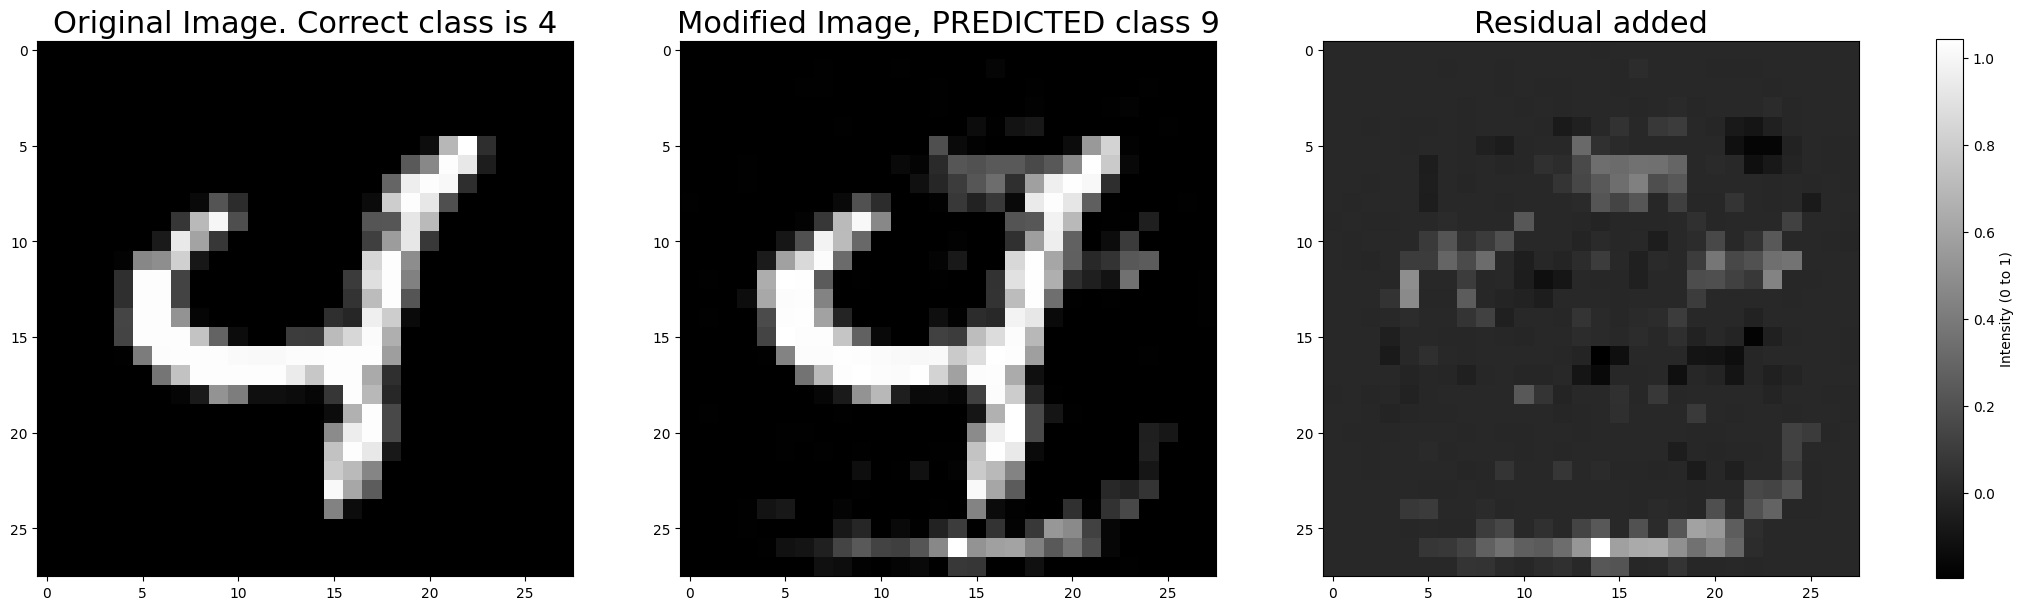

The true class is 9, the new class will be 0
Found c = 0.000001 satisfying f(x + r) = l
The true class is 9, the new class will be 5
Found c = 0.000001 satisfying f(x + r) = l
The true class is 7, the new class will be 3
Found c = 0.000001 satisfying f(x + r) = l
The true class is 2, the new class will be 7
Found c = 0.000001 satisfying f(x + r) = l
The true class is 6, the new class will be 8
Found c = 0.000001 satisfying f(x + r) = l
The true class is 2, the new class will be 9
Found c = 0.000001 satisfying f(x + r) = l
The true class is 2, the new class will be 0
Found c = 0.000001 satisfying f(x + r) = l
The true class is 2, the new class will be 7
Found c = 0.000001 satisfying f(x + r) = l
The true class is 5, the new class will be 0
Found c = 0.000001 satisfying f(x + r) = l
The true class is 6, the new class will be 1
Found c = 0.000001 satisfying f(x + r) = l
The true class is 2, the new class will be 0
Found c = 0.000001 satisfying f(x + r) = l
The true class is 2, the new cla

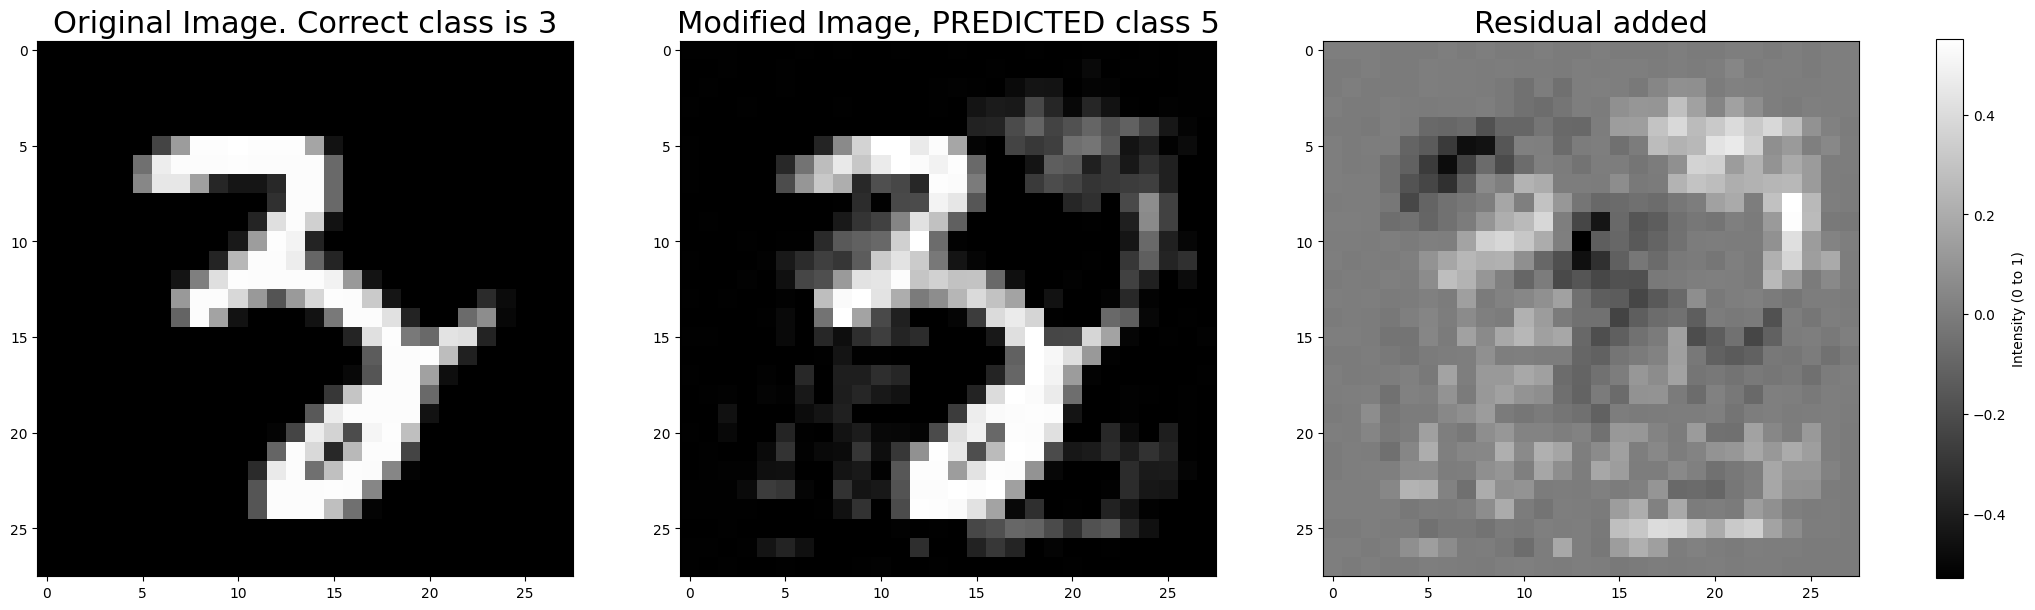

The true class is 6, the new class will be 0
Found c = 0.000001 satisfying f(x + r) = l
The true class is 5, the new class will be 1
Found c = 0.000001 satisfying f(x + r) = l
The true class is 4, the new class will be 8
Found c = 0.000001 satisfying f(x + r) = l
The true class is 7, the new class will be 3
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 0 iterations
Norm Perturbation |r|: 52.80519104003906


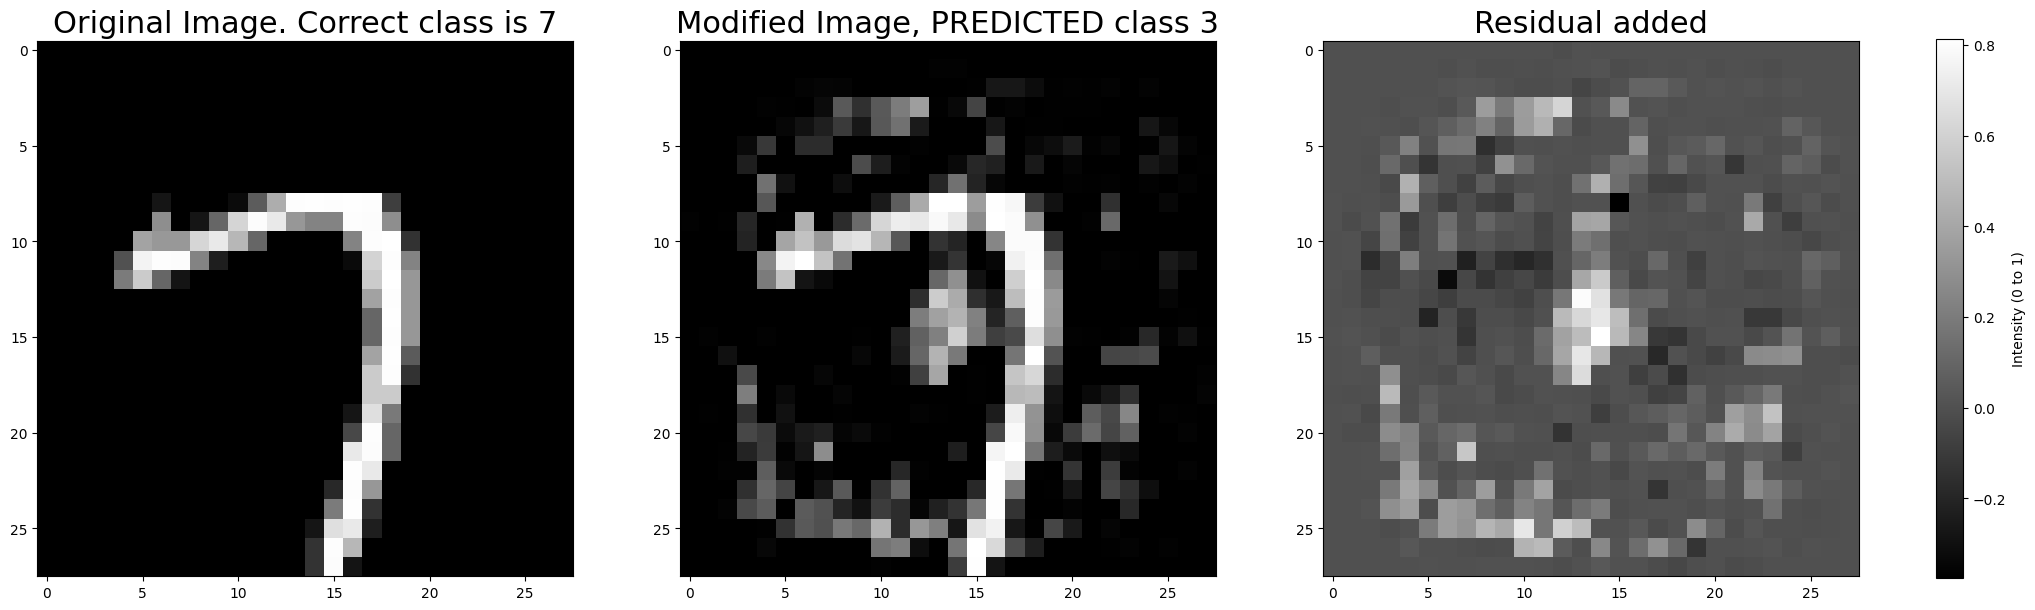

The true class is 9, the new class will be 0
Found c = 0.000001 satisfying f(x + r) = l
The true class is 9, the new class will be 8
Found c = 0.000001 satisfying f(x + r) = l
The true class is 9, the new class will be 1
Found c = 0.000001 satisfying f(x + r) = l
The true class is 5, the new class will be 6
Found c = 0.000001 satisfying f(x + r) = l
The true class is 5, the new class will be 4
Found c = 0.000001 satisfying f(x + r) = l
The true class is 4, the new class will be 6
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 0 iterations
Norm Perturbation |r|: 50.43170928955078


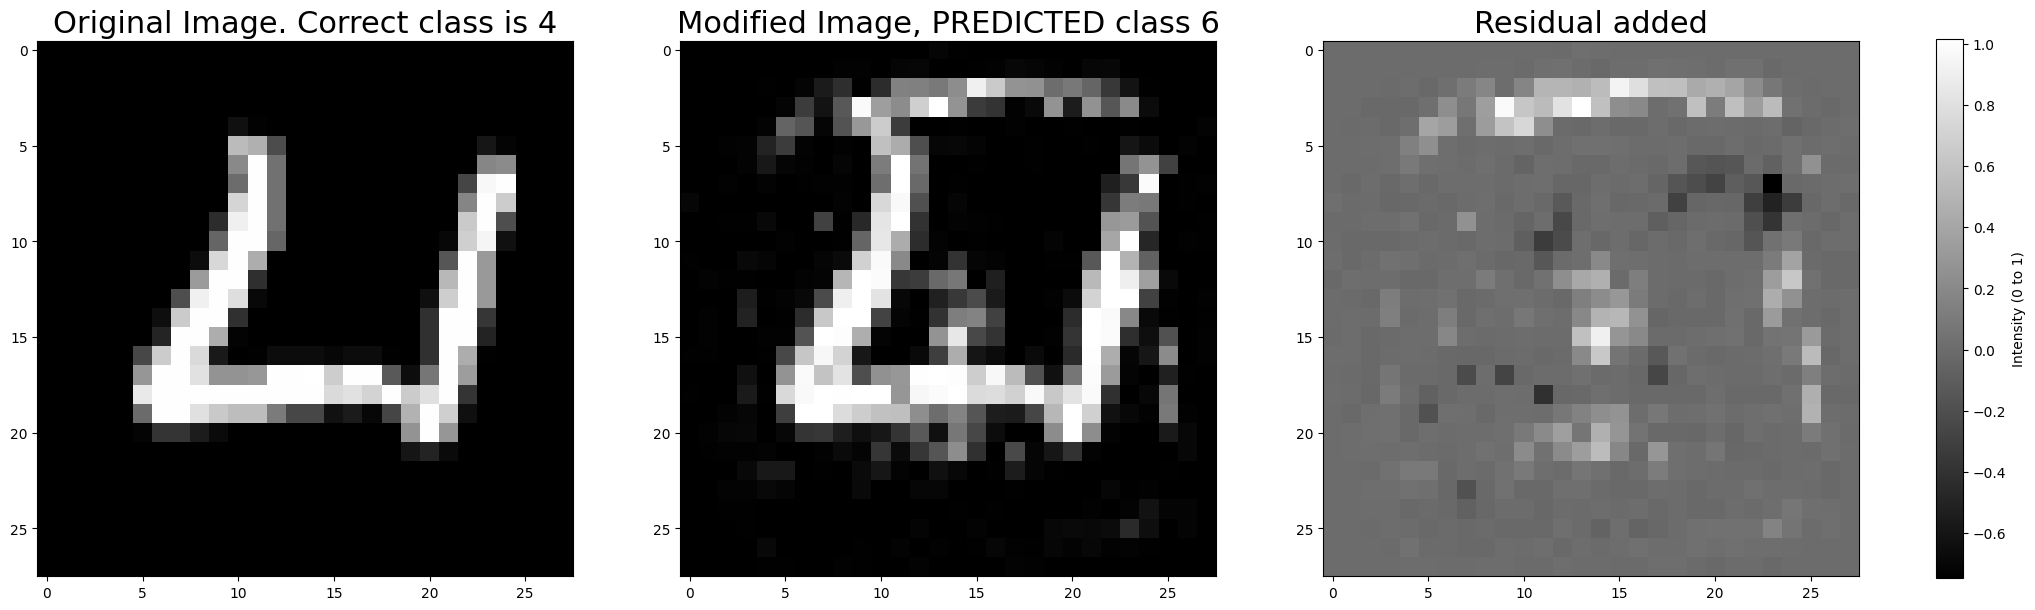

The true class is 8, the new class will be 4
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 0 iterations
Norm Perturbation |r|: 43.806549072265625


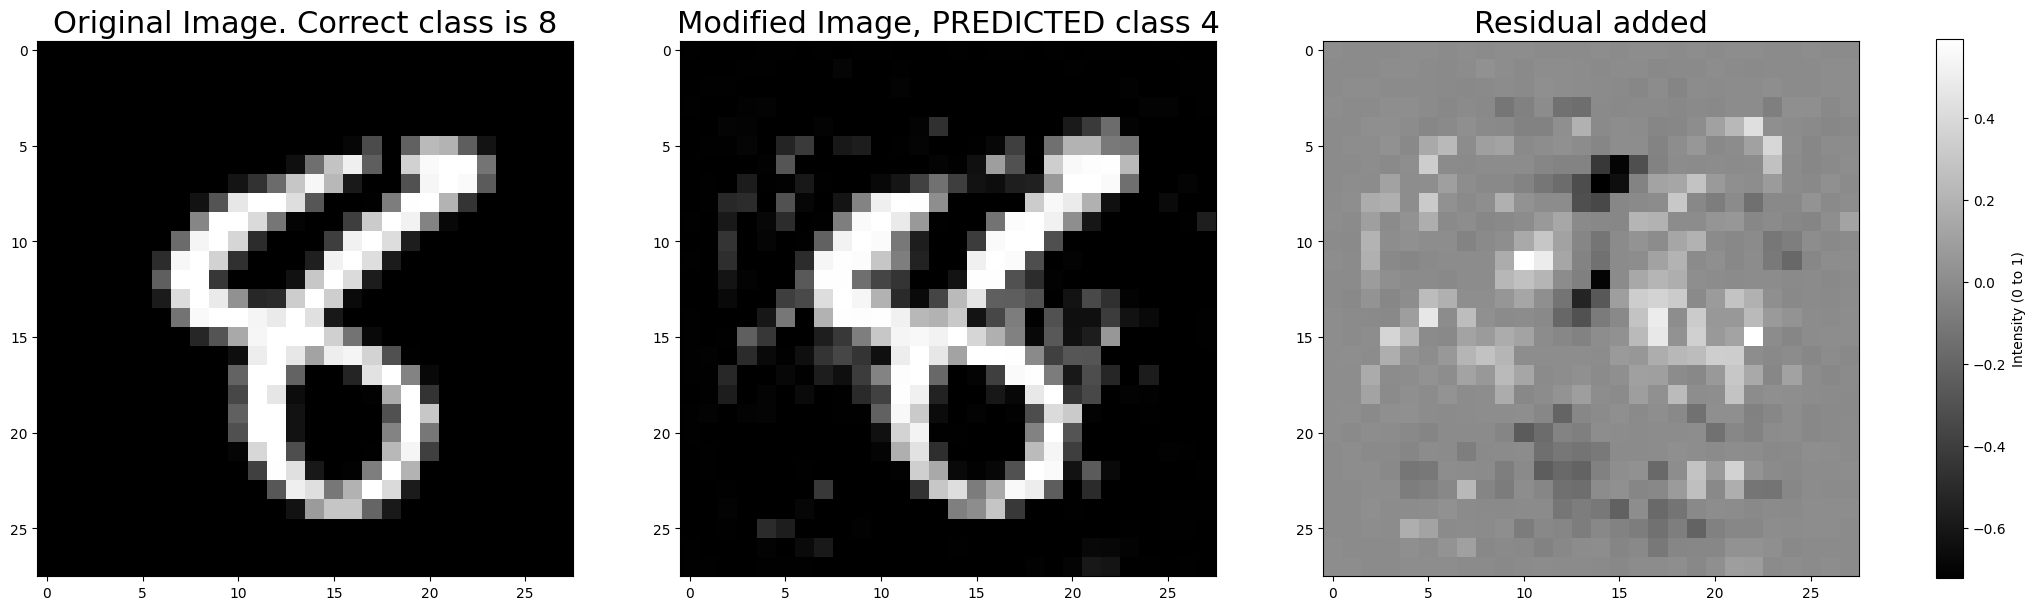

The true class is 5, the new class will be 3
Found c = 0.000001 satisfying f(x + r) = l
The true class is 9, the new class will be 4
Found c = 0.000001 satisfying f(x + r) = l
The true class is 6, the new class will be 4
Found c = 0.000001 satisfying f(x + r) = l
The true class is 1, the new class will be 2
Found c = 0.000001 satisfying f(x + r) = l
The true class is 3, the new class will be 1
Found c = 0.000001 satisfying f(x + r) = l
The true class is 7, the new class will be 2
Found c = 0.000001 satisfying f(x + r) = l
The true class is 4, the new class will be 1
Found c = 0.000001 satisfying f(x + r) = l
The true class is 0, the new class will be 2
Found c = 0.000001 satisfying f(x + r) = l
The true class is 3, the new class will be 2
Found c = 0.000001 satisfying f(x + r) = l
The true class is 1, the new class will be 3
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 0 iterations
Norm Perturbation |r|: 56.34413146972656


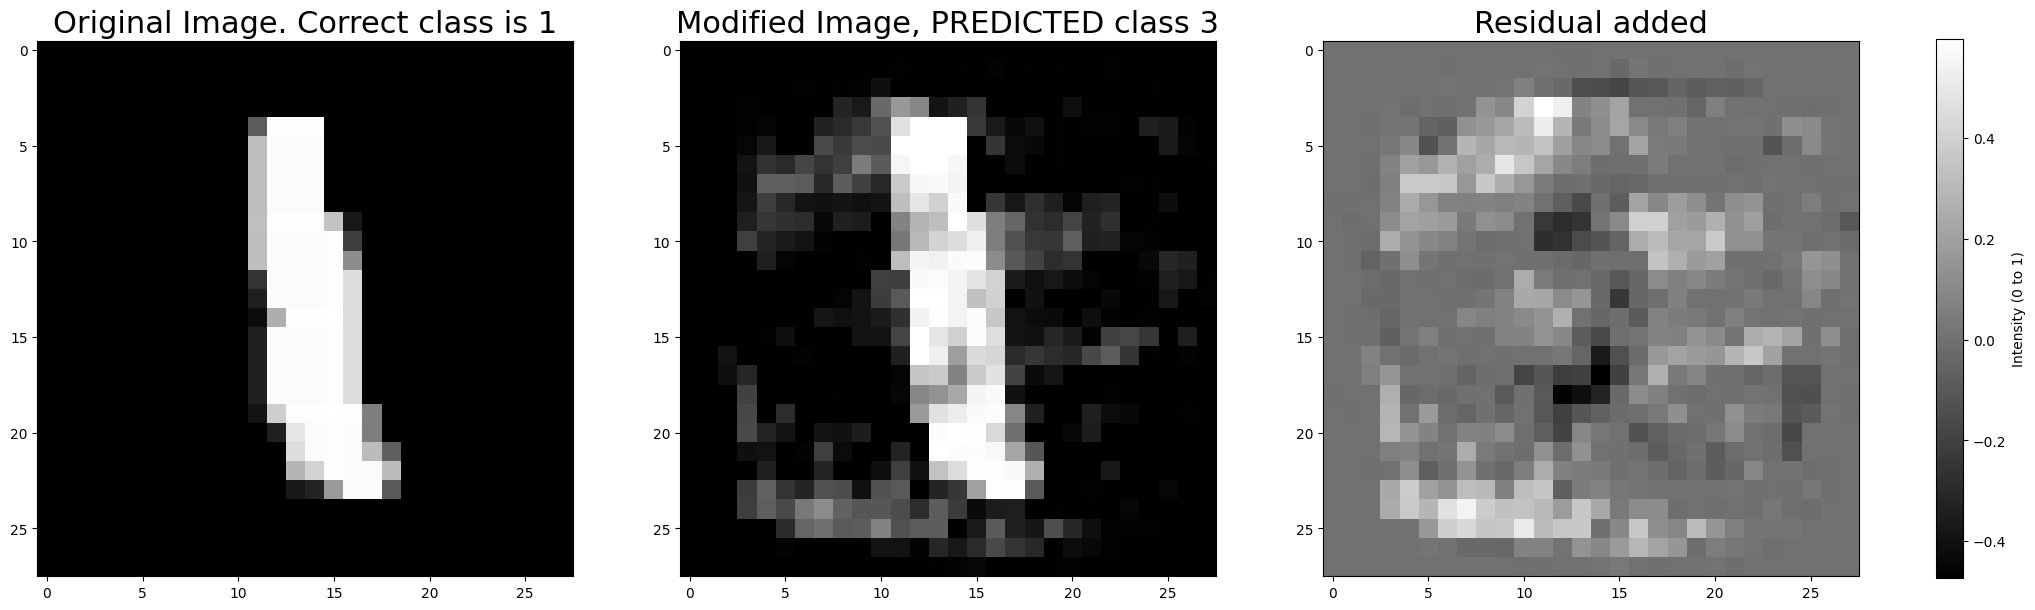

The true class is 7, the new class will be 2
Found c = 0.000001 satisfying f(x + r) = l
The true class is 7, the new class will be 5
Found c = 0.000001 satisfying f(x + r) = l
The true class is 1, the new class will be 9
Found c = 0.000001 satisfying f(x + r) = l
The true class is 7, the new class will be 1
Found c = 0.000001 satisfying f(x + r) = l
The true class is 6, the new class will be 8
Found c = 0.000001 satisfying f(x + r) = l
The true class is 5, the new class will be 1
Found c = 0.000001 satisfying f(x + r) = l
The true class is 3, the new class will be 8
Found c = 0.000001 satisfying f(x + r) = l


In [50]:
img_indices = random.sample(range(1, 101), 50)

similar_images = []

# test with initial_c = 0.000001
for index in img_indices:
    testI, testY = mnist_test.__getitem__(index)

    # generate target label that is different from true label testY
    l = np.random.choice([i for i in range(10) if i != testY])
    similar_images.append(
        sample_similar_imgs(
            testI,
            model,
            true_label=testY,
            initial_c=initial_c,
            max_c=max_c,
            max_iter_search=1000,
            l=l,
            device="cuda",
        )
    )

In [51]:
similar_images_misclassified = [s for s in similar_images if s[1] == True]
print("I sample:", len(similar_images_misclassified), "images")

I sample: 6 images


In [52]:
# Then check on model2 - hidden_sizes = [200, 200] where these images are also missclassfied or not
# true_label = [4, 3, 7 ,4, 8, 1]
# misclassified_model = [9, 5, 3, 6, 4, 3]

for img in similar_images_misclassified:
    testI = img[0]
    pred = model2(testI.unsqueeze(0).to(device))
    predicted_label = torch.argmax(pred, dim=1)
    print(f"Predicted label: {predicted_label}")

Predicted label: tensor([9], device='cuda:0')
Predicted label: tensor([5], device='cuda:0')
Predicted label: tensor([3], device='cuda:0')
Predicted label: tensor([6], device='cuda:0')
Predicted label: tensor([4], device='cuda:0')
Predicted label: tensor([3], device='cuda:0')


#### 5. Comment

We observed that images misclassified by the first model remained challenging for the second model, often resulting in identical misclassifications. This outcome persisted despite the fact that these samples were visually recognizable by human observers.

This suggests that even a well-trained model on the MNIST dataset can be easily fooled by introducing residual noise. Despite these perturbations, the modified images remain visually recognizable to human observers. This highlights the vulnerability of neural networks to adversarial perturbations, even when the perceptual impact on the input is minimal.

---


Instead than using L-BFGS to find adversarial examples we could also use a backpropagation method such as Adam, where you could optimize only r or both r and c.

**Question** Change the previous code to use Adam instead than L-BFGS for the optimization. This means that you don't do anymore a line-search to find the minimum $c$ (no more closure). You can either fix $c$ and estimate only $r$ or estimate both. Try these two solutions and comment on that. Does it work properly ? If not, try to change the loss function. Would you add a regularization term ? If yes, which one and why ? Does it work better ? Please comment on that.

### Answer

In [53]:
def test_perturbation_adam(
    testI, model, true_label, initial_c, max_c, max_iter, l, device, optimize_c=False
):
    """
    Applies a perturbation to the image `testI` to be classified as target label `l` using Adam optimizer.
    Optionally optimizes both `c` and `r` or only `r` within a range for `c`.

    Parameters:
    - testI: Input image tensor to be perturbed
    - model: Trained model
    - true_label: True label of the image (for visualization)
    - initial_c: Initial value for the regularization parameter `c`
    - max_c: Maximum value for `c` during optimization
    - max_iter: Maximum number of optimization steps
    - l: Target label for the perturbation
    - device: Device (CPU or GPU) on which the computation is carried out
    - optimize_c: Boolean flag to indicate if `c` should be optimized

    Returns:
    - None (plots and prints results)
    """
    testI = testI.to(device)
    r = torch.zeros_like(
        testI, requires_grad=True, device=device
    )  # Initialize r as zero
    c = torch.tensor(initial_c, requires_grad=optimize_c, device=device)  # Initialize c
    l = torch.tensor([l], device=device)  # Target label tensor
    l = l.view(1)  # Ensure batch size of 1 for CrossEntropy loss

    print(f"The true class is {true_label}, the new class will be {l.item()}")

    # Define the objective function
    def objective(c, r, x, l):
        x_r = torch.clamp(x + r, 0, 1)
        pred = model(x_r)
        classification_loss = torch.nn.CrossEntropyLoss()(pred, l)
        perturbation_loss = c * torch.norm(r, p=1)
        return classification_loss + perturbation_loss

    # Adam optimizer for r (and optionally c)
    optimizer = torch.optim.Adam([r] if not optimize_c else [r, c], lr=learning_rate)

    for step in range(max_iter):
        optimizer.zero_grad()
        loss = objective(c, r, testI, l)
        loss.backward()
        optimizer.step()

        # Ensure c remains in range if being optimized
        if optimize_c:
            with torch.no_grad():
                c.clamp_(min=1e-8, max=max_c)

        with torch.no_grad():
            x_r = torch.clamp(testI + r, 0, 1)
            pred = model(x_r)
            predicted_label = torch.argmax(pred, dim=1)

        if predicted_label == l:
            print(f"Success: f(x + r) = l with c = {c.item():.6f} in {step + 1} steps")
            break

        if step % 20 == 0:
            print(
                f"Step {step}/{max_iter}: Loss = {loss.item():.4f}, c = {c.item():.6f}"
            )

    if predicted_label != l:
        print(f"Failed to reach target label within {max_iter} steps")
        print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

    plot_results(testI, r, x_r, true_label, l, fail=(predicted_label != l))

##### With fixed c

The true class is 7, the new class will be 1
Step 0/300: Loss = 4.2821, c = 0.000001
Step 20/300: Loss = 1.9295, c = 0.000001
Success: f(x + r) = l with c = 0.000001 in 36 steps


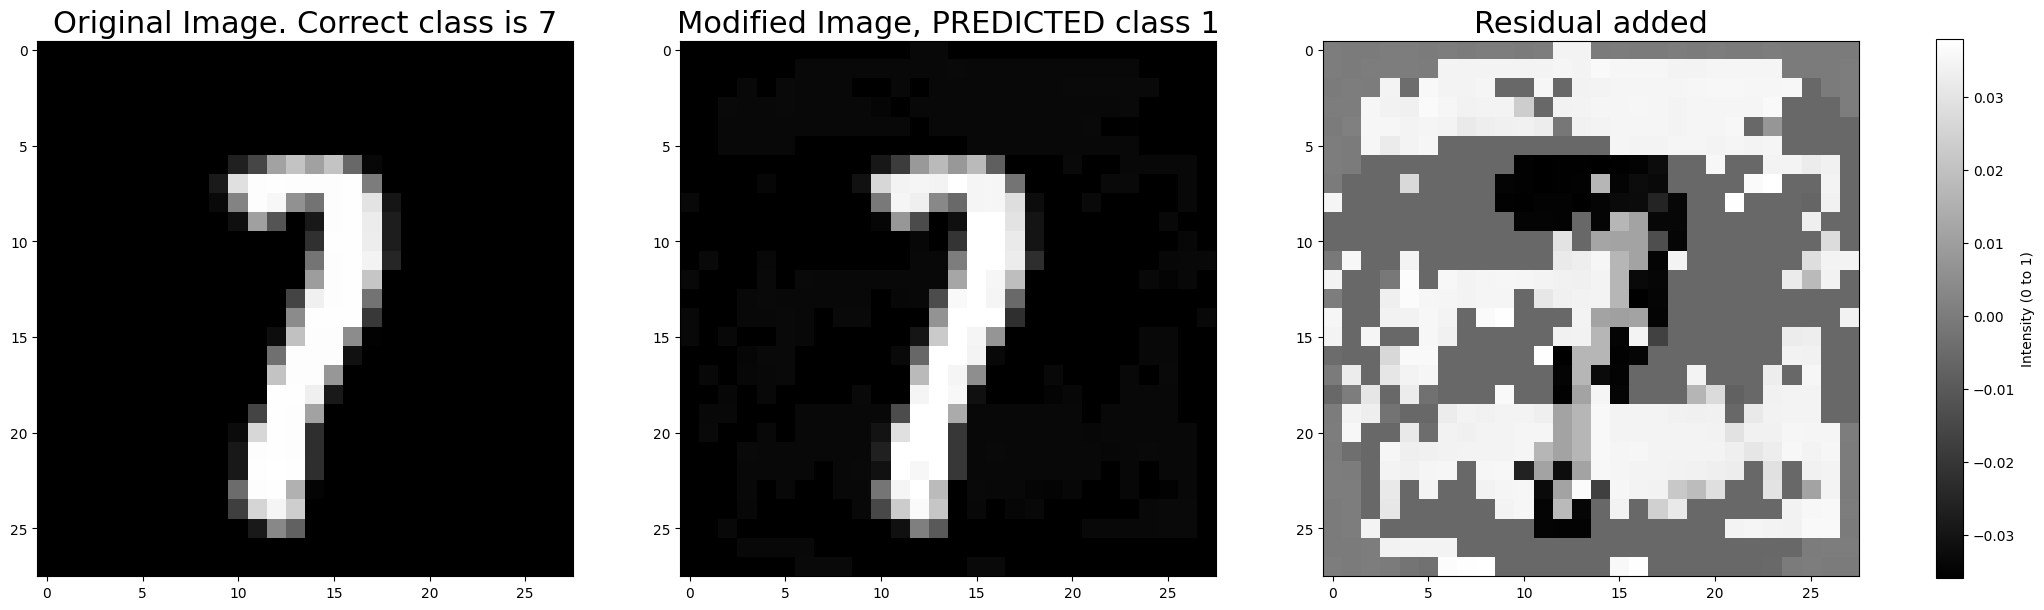

The true class is 2, the new class will be 9
Step 0/300: Loss = 30.2690, c = 0.000001
Step 20/300: Loss = 25.6511, c = 0.000001
Step 40/300: Loss = 21.1831, c = 0.000001
Step 60/300: Loss = 16.6889, c = 0.000001
Step 80/300: Loss = 12.0405, c = 0.000001
Step 100/300: Loss = 7.9851, c = 0.000001
Step 120/300: Loss = 4.5974, c = 0.000001
Step 140/300: Loss = 1.8398, c = 0.000001
Success: f(x + r) = l with c = 0.000001 in 149 steps


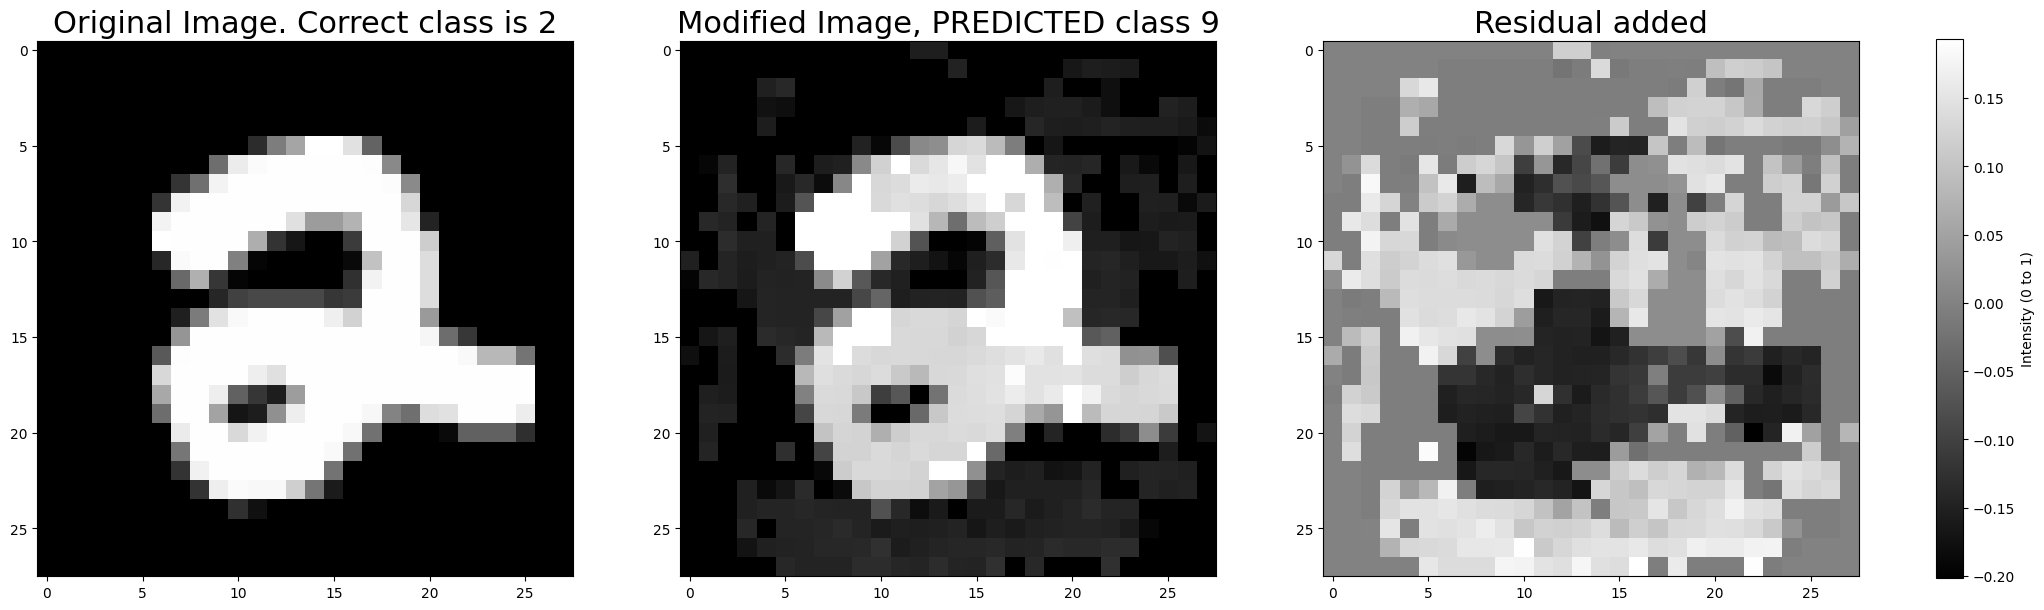

The true class is 5, the new class will be 0
Step 0/300: Loss = 18.8367, c = 0.000001
Step 20/300: Loss = 16.3417, c = 0.000001
Step 40/300: Loss = 13.7768, c = 0.000001
Step 60/300: Loss = 11.0861, c = 0.000001
Step 80/300: Loss = 8.3392, c = 0.000001
Step 100/300: Loss = 5.6770, c = 0.000001
Step 120/300: Loss = 3.4053, c = 0.000001
Step 140/300: Loss = 1.6779, c = 0.000001
Success: f(x + r) = l with c = 0.000001 in 148 steps


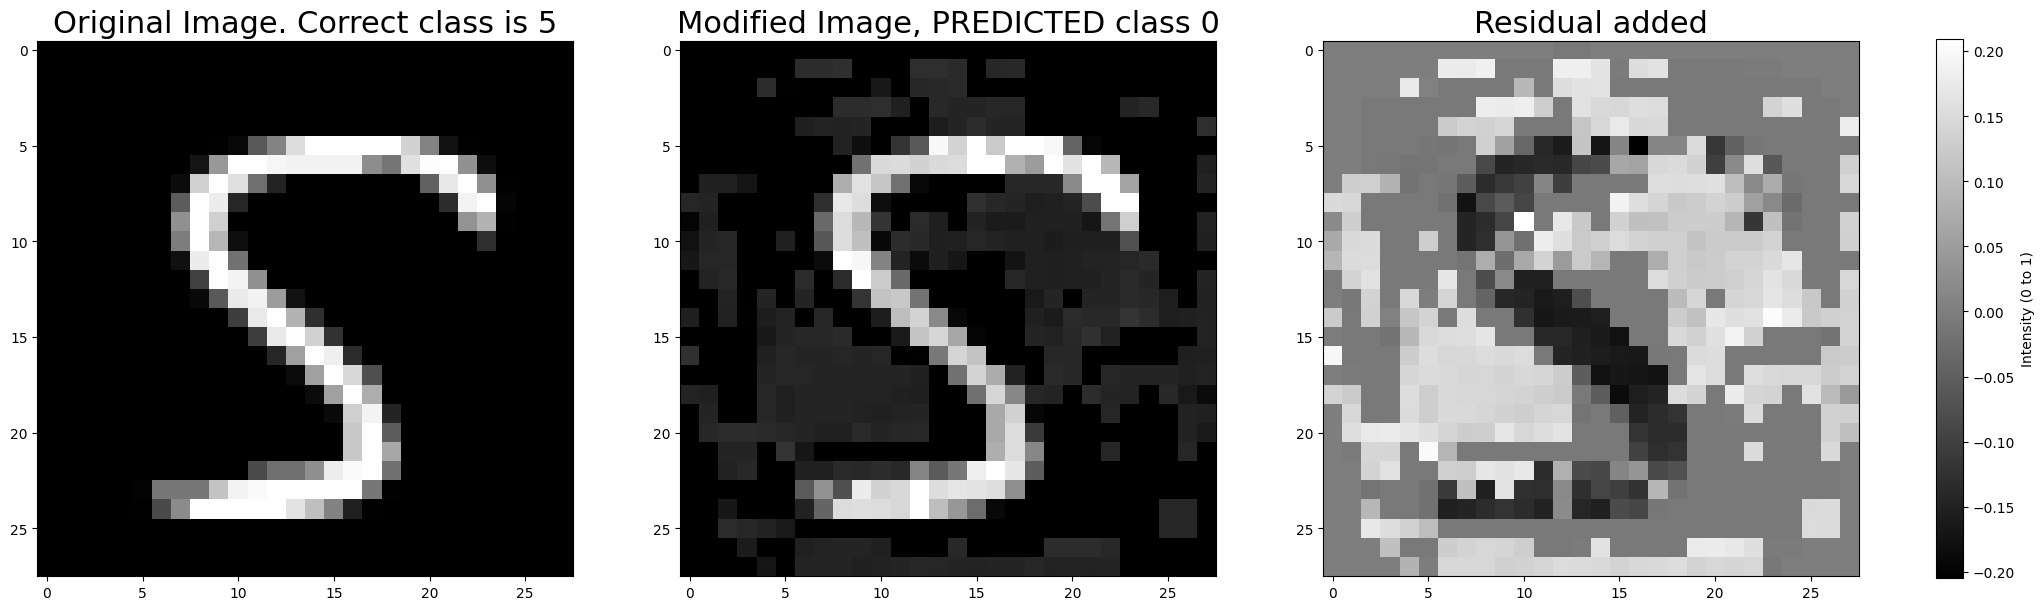

The true class is 4, the new class will be 7
Step 0/300: Loss = 8.6132, c = 0.000001
Step 20/300: Loss = 5.9668, c = 0.000001
Step 40/300: Loss = 2.9452, c = 0.000001
Success: f(x + r) = l with c = 0.000001 in 56 steps


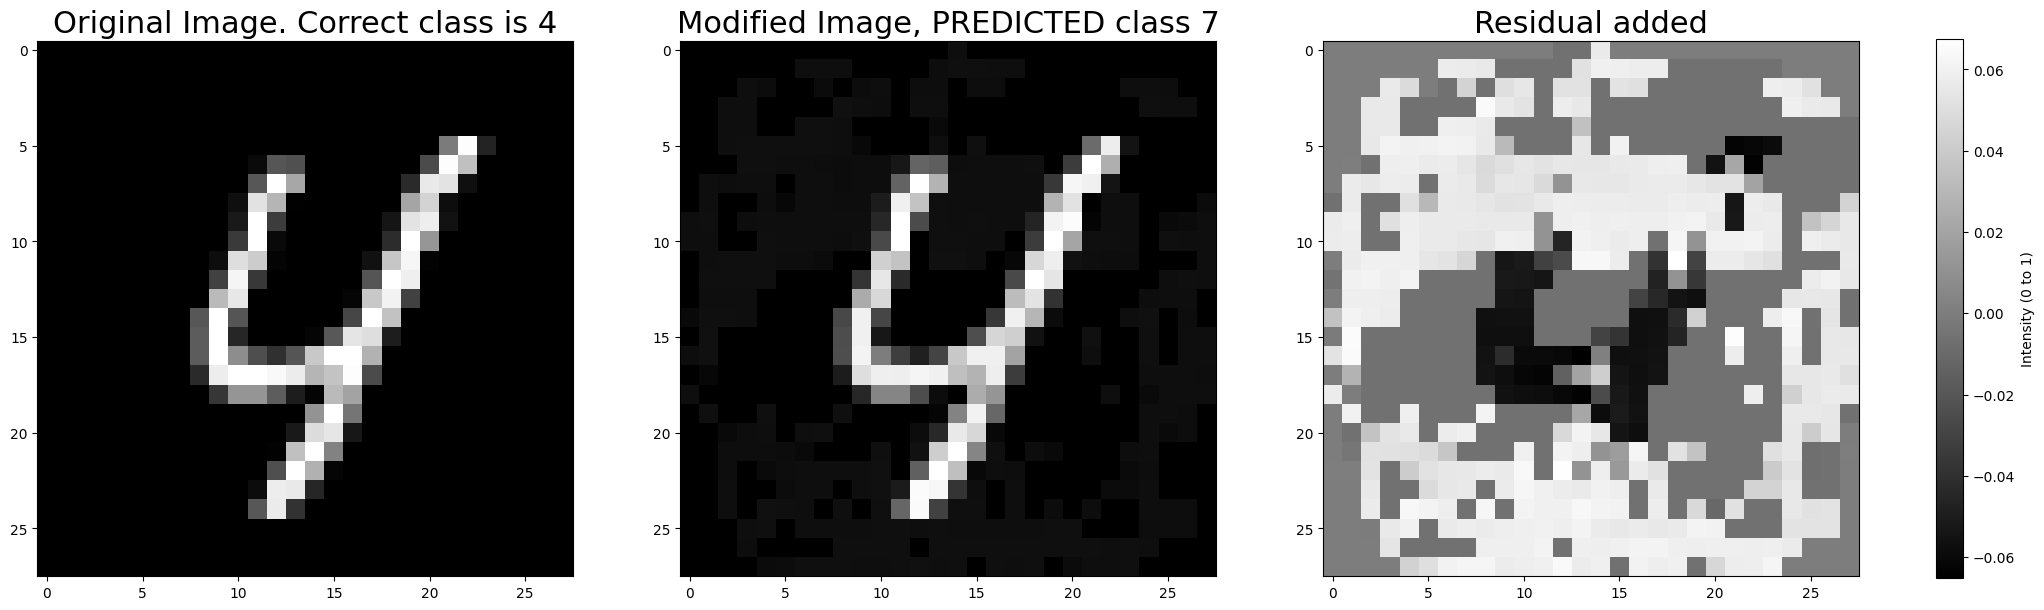

The true class is 7, the new class will be 8
Step 0/300: Loss = 11.7271, c = 0.000001
Step 20/300: Loss = 7.7391, c = 0.000001
Step 40/300: Loss = 3.3524, c = 0.000001
Success: f(x + r) = l with c = 0.000001 in 56 steps


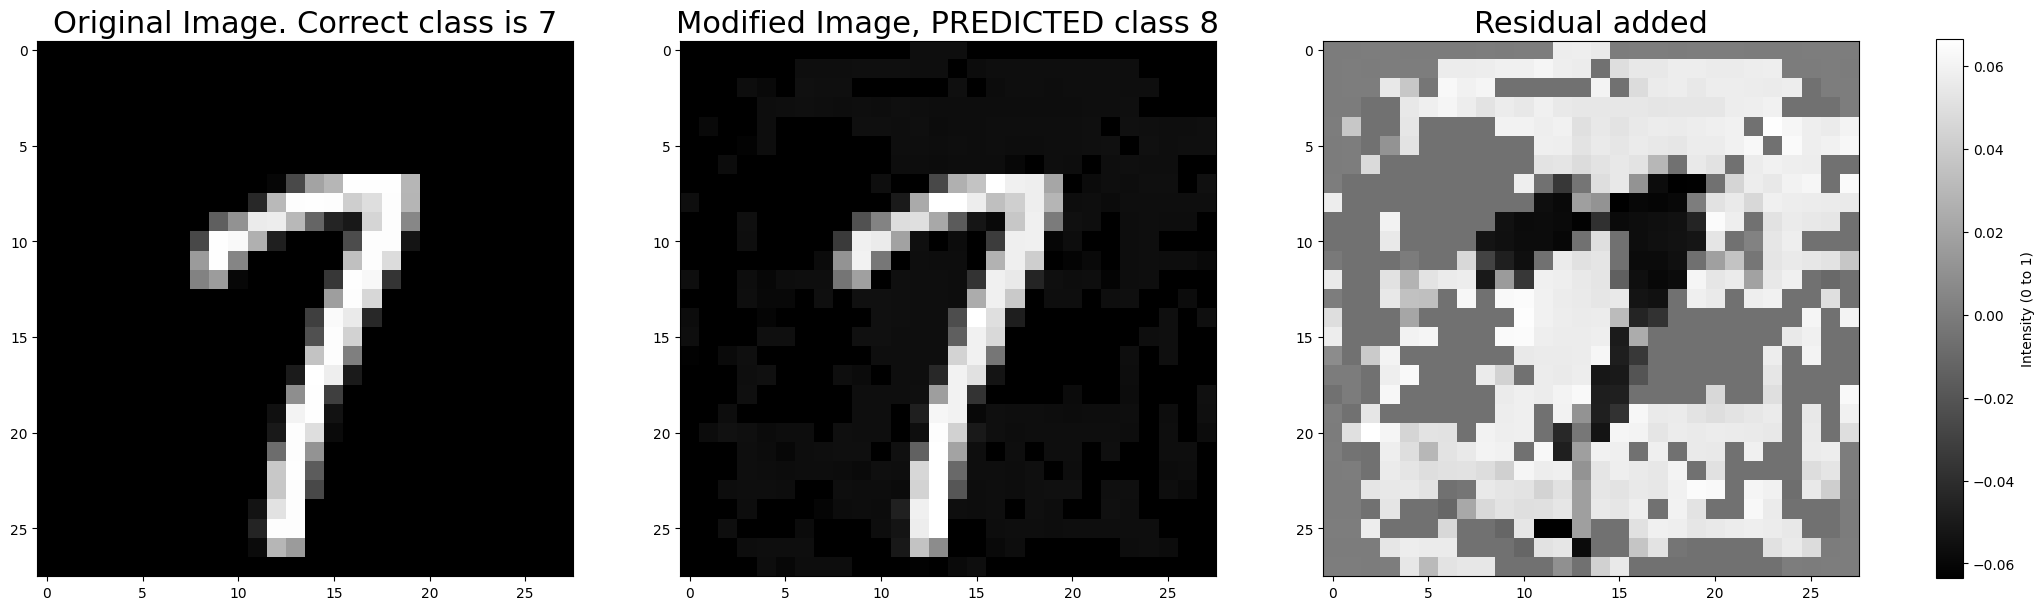

The true class is 1, the new class will be 6
Step 0/300: Loss = 13.7954, c = 0.000001
Step 20/300: Loss = 11.1273, c = 0.000001
Step 40/300: Loss = 8.2570, c = 0.000001
Step 60/300: Loss = 5.1157, c = 0.000001
Step 80/300: Loss = 2.5929, c = 0.000001
Success: f(x + r) = l with c = 0.000001 in 101 steps


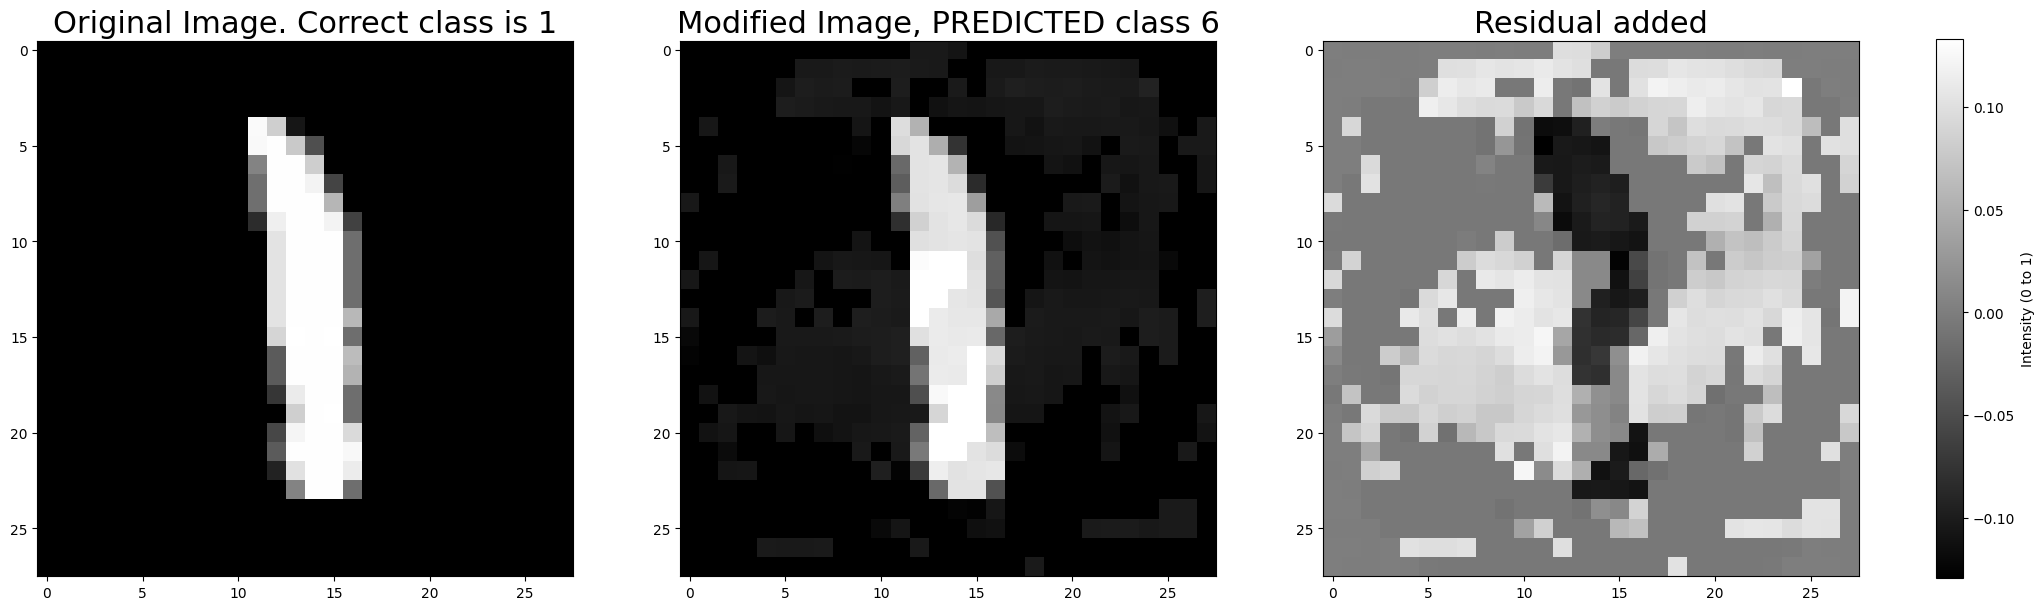

The true class is 2, the new class will be 1
Step 0/300: Loss = 15.3963, c = 0.000001
Step 20/300: Loss = 13.8581, c = 0.000001
Step 40/300: Loss = 12.2233, c = 0.000001
Step 60/300: Loss = 10.4715, c = 0.000001
Step 80/300: Loss = 8.6058, c = 0.000001
Step 100/300: Loss = 6.7923, c = 0.000001
Step 120/300: Loss = 5.2974, c = 0.000001
Step 140/300: Loss = 4.0932, c = 0.000001
Step 160/300: Loss = 3.1398, c = 0.000001
Step 180/300: Loss = 2.2994, c = 0.000001
Step 200/300: Loss = 1.5530, c = 0.000001
Success: f(x + r) = l with c = 0.000001 in 215 steps


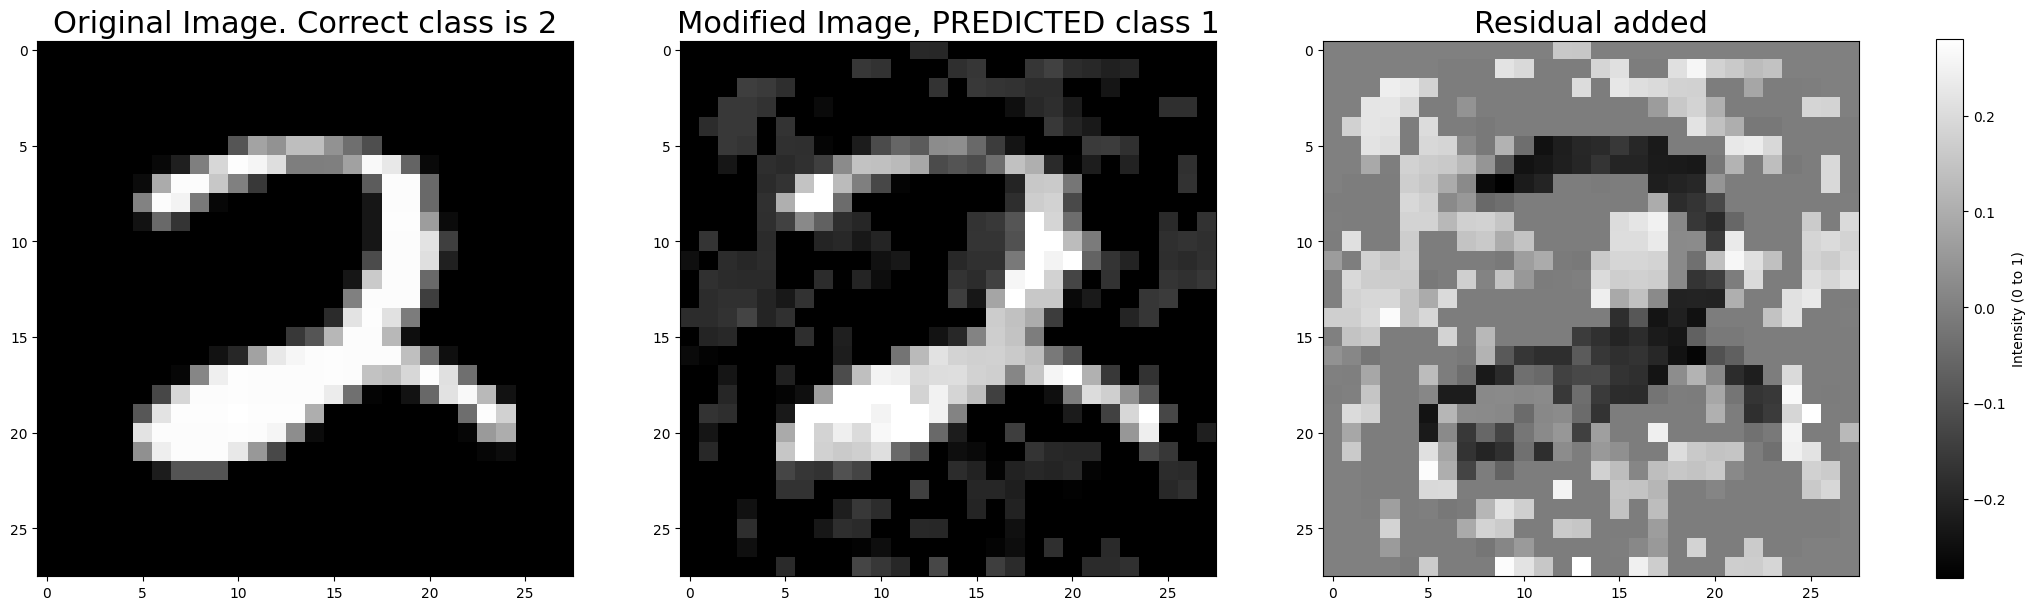

In [54]:
img_indices = [111, 222, 333, 555, 666, 777, 888]
l_store = []

for index in img_indices:
    testI, testY = mnist_test.__getitem__(index)

    # generate target label that is different from true label testY
    l = np.random.choice([i for i in range(10) if i != testY])
    l_store.append(l)
    test_perturbation_adam(
        testI,
        model,
        true_label=testY,
        initial_c=0.000001,
        max_c=max_c,
        max_iter=max_iter_search,
        l=l,
        device="cuda",
    )

##### Estimate both c and r

The true class is 7, the new class will be 1
Step 0/300: Loss = 4.2821, c = 0.000001
Step 20/300: Loss = 1.9295, c = 0.000000
Success: f(x + r) = l with c = 0.000000 in 36 steps


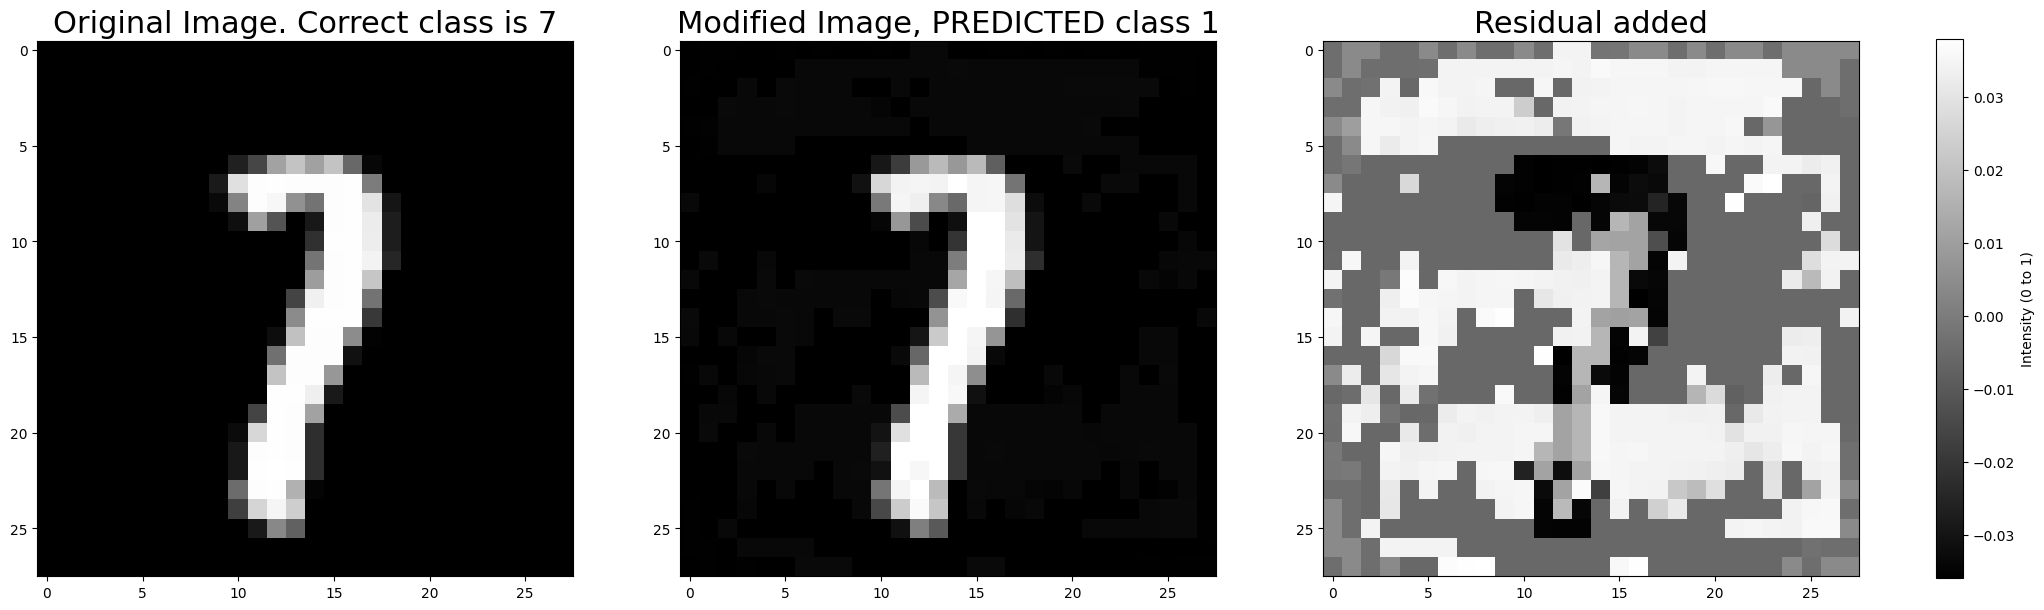

The true class is 2, the new class will be 9
Step 0/300: Loss = 30.2690, c = 0.000001
Step 20/300: Loss = 25.6511, c = 0.000000
Step 40/300: Loss = 21.1831, c = 0.000000
Step 60/300: Loss = 16.6888, c = 0.000000
Step 80/300: Loss = 12.0405, c = 0.000000
Step 100/300: Loss = 7.9850, c = 0.000000
Step 120/300: Loss = 4.5974, c = 0.000000
Step 140/300: Loss = 1.8398, c = 0.000000
Success: f(x + r) = l with c = 0.000000 in 149 steps


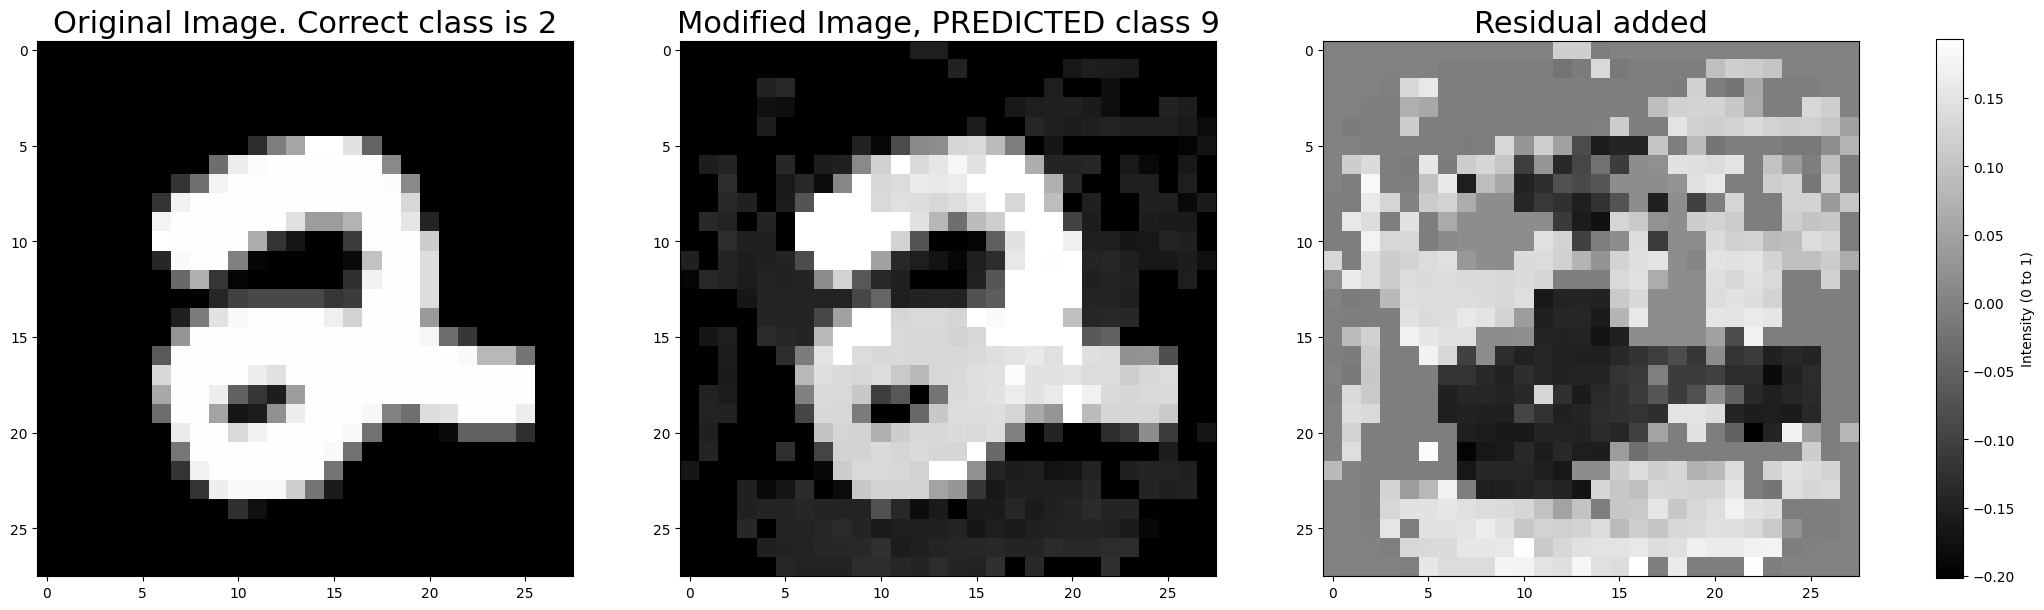

The true class is 5, the new class will be 0
Step 0/300: Loss = 18.8367, c = 0.000001
Step 20/300: Loss = 16.3417, c = 0.000000
Step 40/300: Loss = 13.7768, c = 0.000000
Step 60/300: Loss = 11.0861, c = 0.000000
Step 80/300: Loss = 8.3391, c = 0.000000
Step 100/300: Loss = 5.6769, c = 0.000000
Step 120/300: Loss = 3.4053, c = 0.000000
Step 140/300: Loss = 1.6779, c = 0.000000
Success: f(x + r) = l with c = 0.000000 in 148 steps


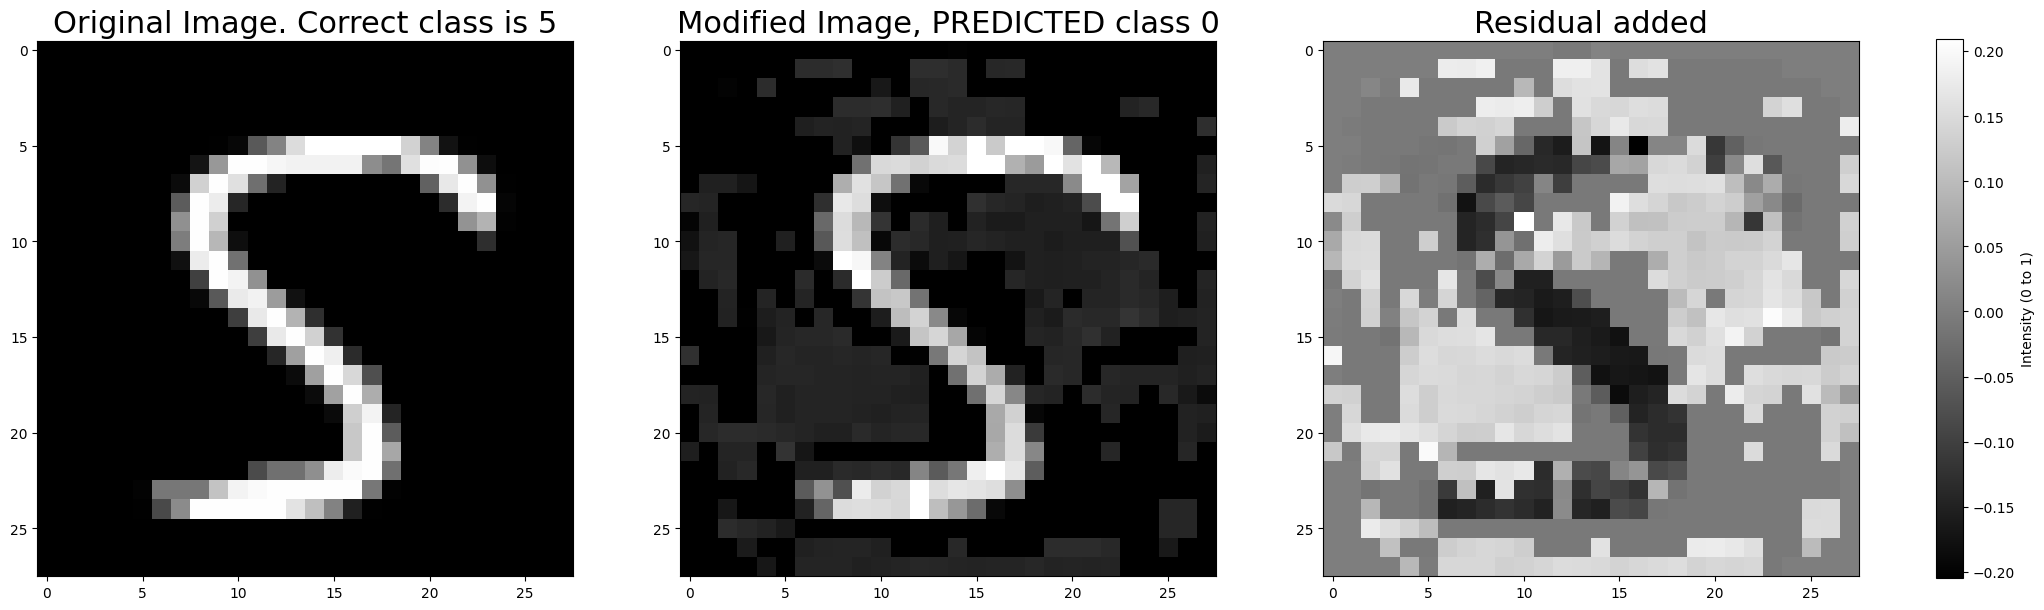

The true class is 4, the new class will be 7
Step 0/300: Loss = 8.6132, c = 0.000001
Step 20/300: Loss = 5.9668, c = 0.000000
Step 40/300: Loss = 2.9452, c = 0.000000
Success: f(x + r) = l with c = 0.000000 in 56 steps


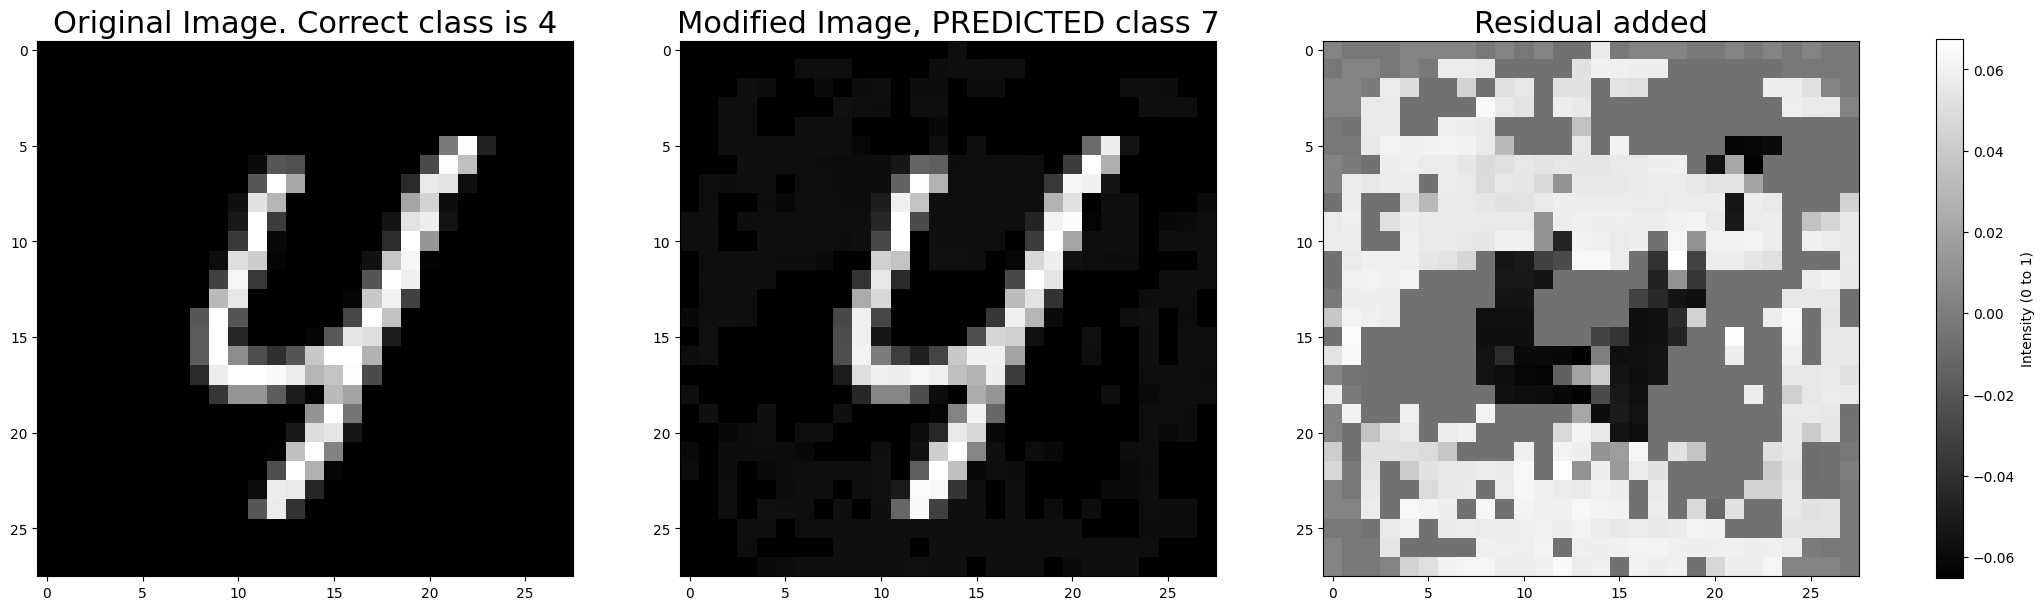

The true class is 7, the new class will be 8
Step 0/300: Loss = 11.7271, c = 0.000001
Step 20/300: Loss = 7.7391, c = 0.000000
Step 40/300: Loss = 3.3524, c = 0.000000
Success: f(x + r) = l with c = 0.000000 in 56 steps


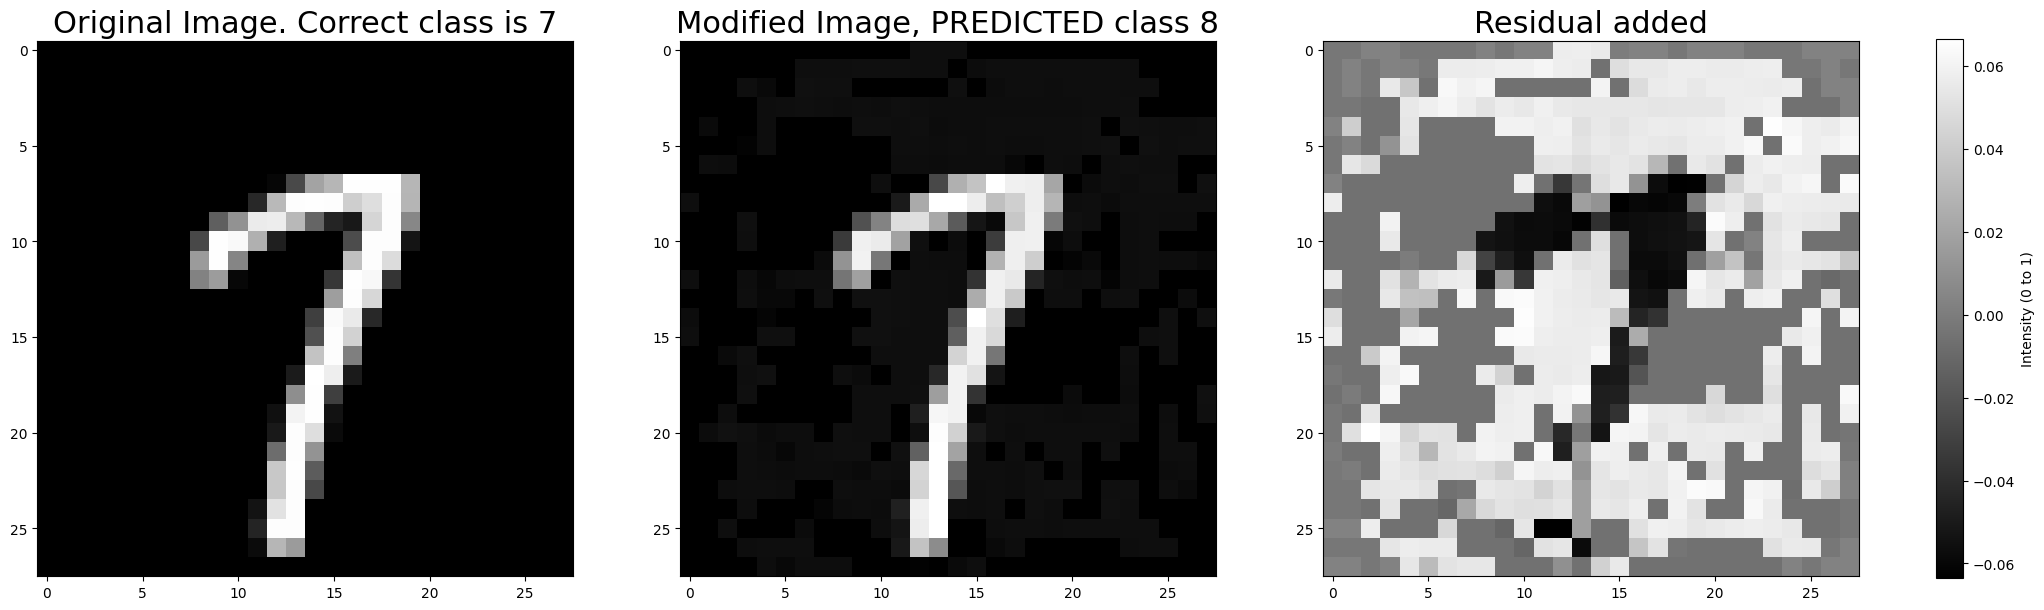

The true class is 1, the new class will be 6
Step 0/300: Loss = 13.7954, c = 0.000001
Step 20/300: Loss = 11.1273, c = 0.000000
Step 40/300: Loss = 8.2569, c = 0.000000
Step 60/300: Loss = 5.1156, c = 0.000000
Step 80/300: Loss = 2.5928, c = 0.000000
Success: f(x + r) = l with c = 0.000000 in 101 steps


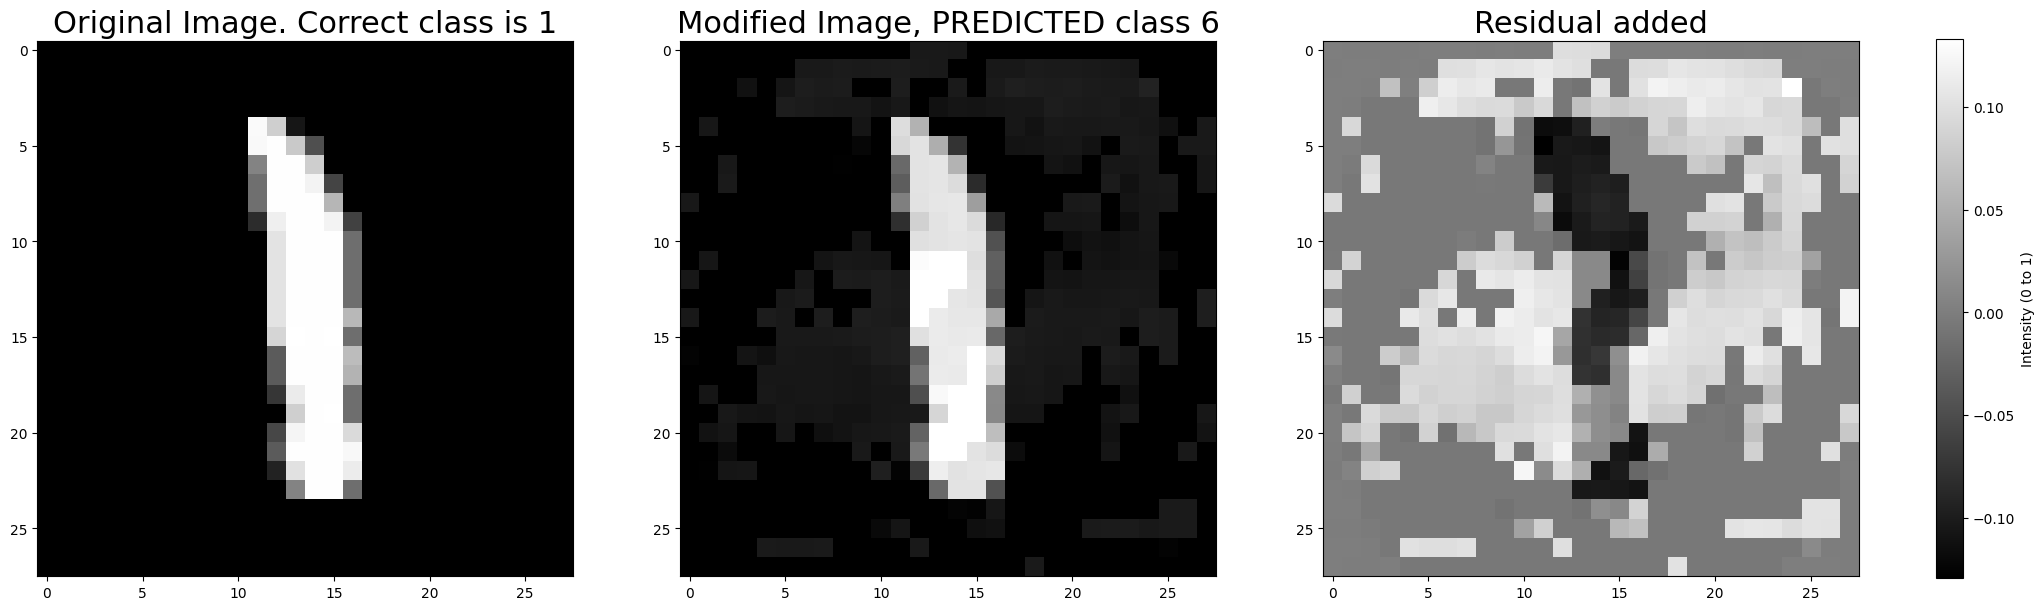

The true class is 2, the new class will be 1
Step 0/300: Loss = 15.3963, c = 0.000001
Step 20/300: Loss = 13.8581, c = 0.000000
Step 40/300: Loss = 12.2233, c = 0.000000
Step 60/300: Loss = 10.4715, c = 0.000000
Step 80/300: Loss = 8.6057, c = 0.000000
Step 100/300: Loss = 6.7910, c = 0.000000
Step 120/300: Loss = 5.2970, c = 0.000000
Step 140/300: Loss = 4.0922, c = 0.000000
Step 160/300: Loss = 3.1375, c = 0.000000
Step 180/300: Loss = 2.2977, c = 0.000000
Step 200/300: Loss = 1.5520, c = 0.000000
Success: f(x + r) = l with c = 0.000000 in 215 steps


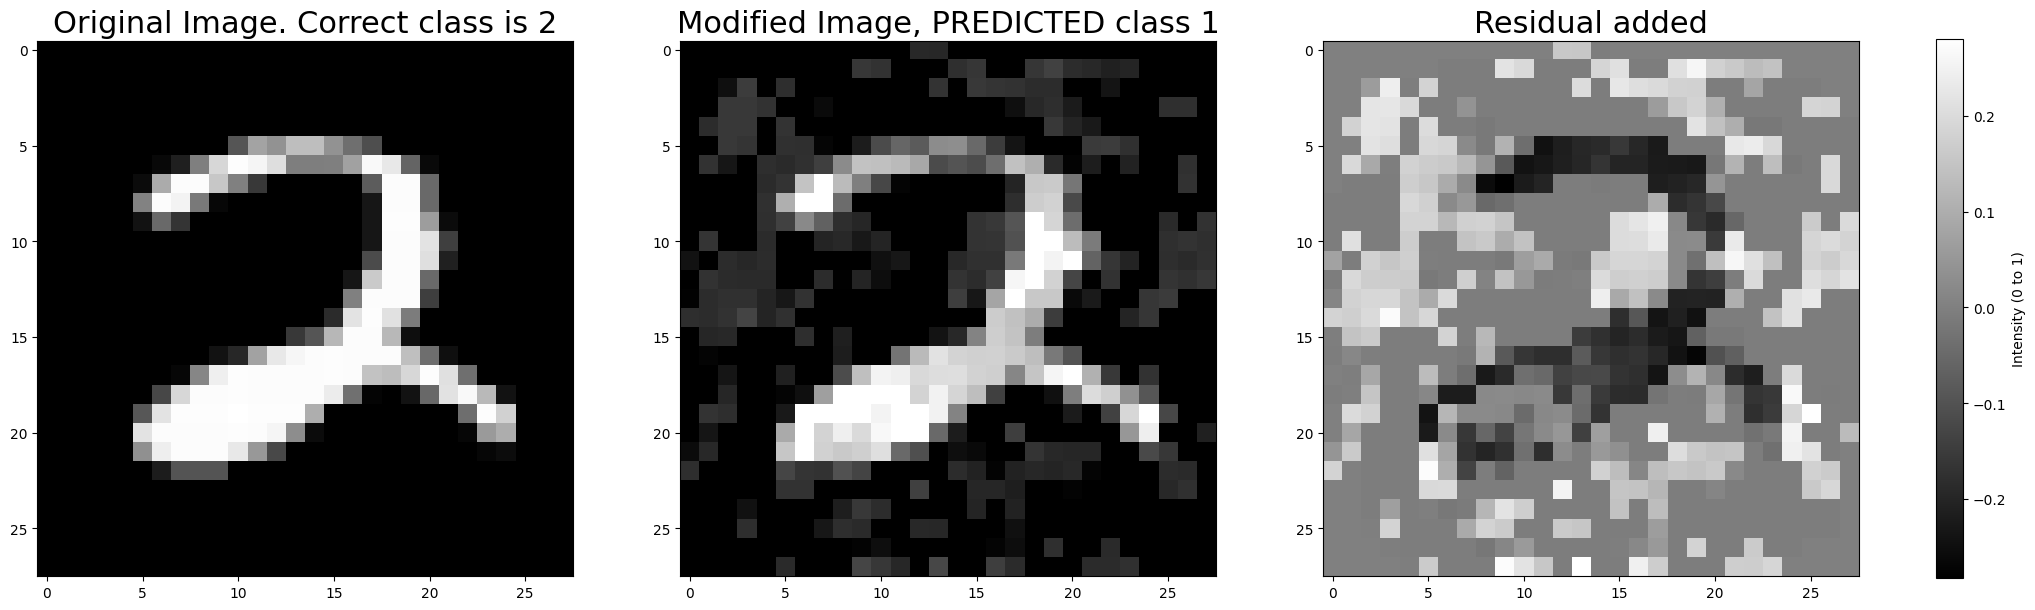

In [56]:
for index, l in zip(img_indices, l_store):
    testI, testY = mnist_test.__getitem__(index)
    test_perturbation_adam(
        testI,
        model,
        true_label=testY,
        initial_c=0.000001,
        max_c=max_c,
        max_iter=max_iter_search,
        l=l,
        device="cuda",
        optimize_c=True,
    )

**Comment**

In both cases — whether estimating only the regularization parameter c or jointly estimating both c and the perturbation r — the algorithm using the Adam optimizer demonstrated effective performance.

The optimizer consistently succeeded in fooling the model by modifying the input images such that they were classified into incorrect target classes.

---

# Fast Gradient Sign Attack (FGSM)

Another famous method to create adversarial examples is Fast Gradient Sign Attack (FGSM). Let $\theta$ be the parameters of a model, x the input image to the model, y its class and J(θ, x, y) the cost used to train the neural network. Usually, when training a model, we compute the gradient of the cost function with respect to the parameters of the model and update them based on the oppositve (i.e., negative) direction of the gradient to decrease the loss. Here, we can replicate the same reasoning but using the pixel values of the input image instead than the model's parameters and using the gradient direction (i.e., positve) to actually maximize the loss. The idea is thus to modify the pixel values so that the loss is maximized and not minimized. In this way, the perturbation should change the image so that it will be misclassified by the model. In order to keep the changes small, possibly imperceptible to naked eye, we only use the sign of the gradient and multiply it by a small $\epsilon$ value. Mathematically, the adversarial example is estimated using:
 $$x_r =x + \epsilon \text{sign}(\Delta_x J(\theta, x, y))$$

 The gradient can easily be computed using backpropagation (Adam).


[*]` Ian J. Goodfellow, Jonathon Shlens & Christian Szegedy Explaining and harnessing adversarial examples. ICLR. 2015`

Let's load an image.

In [57]:
# Parameters
index = 10
testI, testY = mnist_test.__getitem__(index)
X = testI.unsqueeze(0).to(device)
print(X.shape)
X.requires_grad = True  # Important for attack
Y = torch.tensor([testY]).to(device)

torch.Size([1, 1, 28, 28])


And plot it.

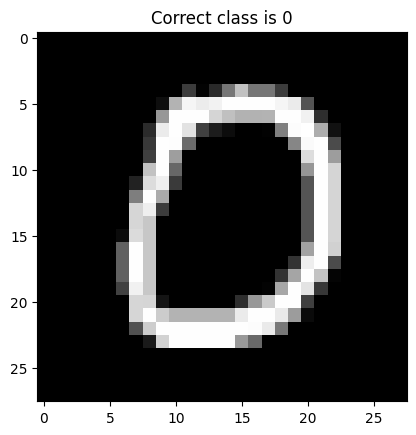

In [58]:
fig = plt.imshow(testI.squeeze(), interpolation="nearest", cmap=plt.cm.gray)
plt.title(f"Correct class is {testY}")
plt.show()

Complete the code by fixing a `eps`value.

Original Class: 0, Perturbed Class: 0
Optimization failed
Norm Perturbation |r|: 78.30000305175781


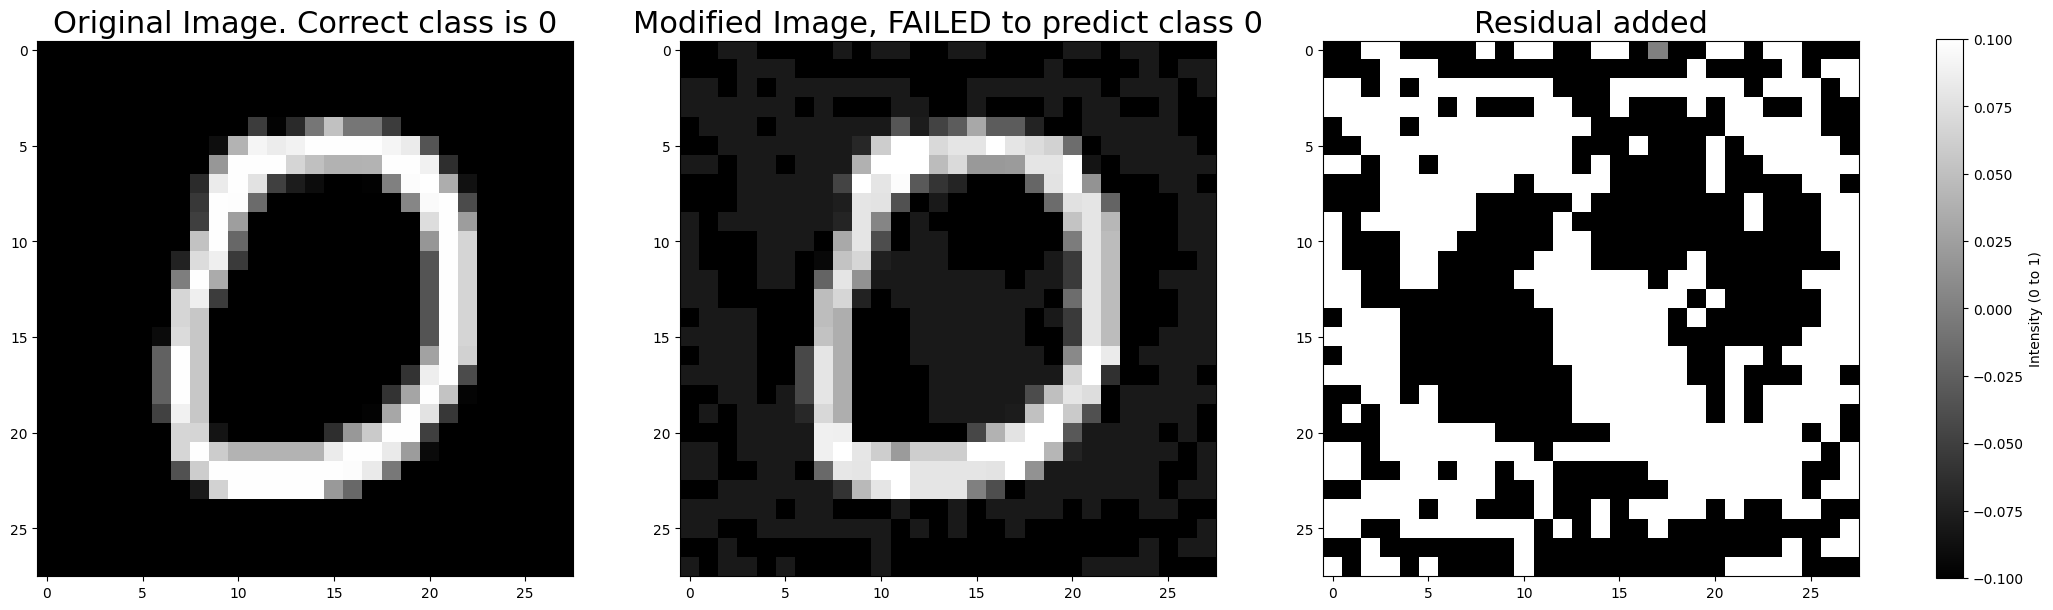

In [60]:
eps = 0.1  # perturbation size

# Forward pass of X through the model
pred_original = model(X)
original_class = torch.argmax(pred_original)

# Compute loss
cost = F.cross_entropy(pred_original, Y)

# Zero existing (previous) gradients
model.zero_grad()

# Compute gradients
cost.backward()

# FGSM attack code
Xr = X + eps * X.grad.data.sign()
Xr = torch.clamp(Xr, 0, 1)  # Ensure Xr is in valid range

# Re-classify the perturbed image
pred_perturbed = model(Xr)
perturbed_class = torch.argmax(pred_perturbed)

# Print results
print(
    f"Original Class: {original_class.item()}, Perturbed Class: {perturbed_class.item()}"
)

r = eps * X.grad.data.sign()

if original_class.item() == perturbed_class.item():
    print(f"Optimization failed")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(X, r, Xr, testY, perturbed_class, fail=True)
else:
    print(f"Optimization succesfull")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(X, r, Xr, testY, perturbed_class, fail=False)

Now, to find the best `eps`value, you will code a function and evalute the successful rate for each `eps`value (number of images where an adversarial examples has been successfully created).

**Question**: What's the best `eps`value ? Are the changes imperceptible to a naked human eye ?

Success: 188, total: 10000
Using epsilon: 0.01 we successfully created 1.88% adversarial examples


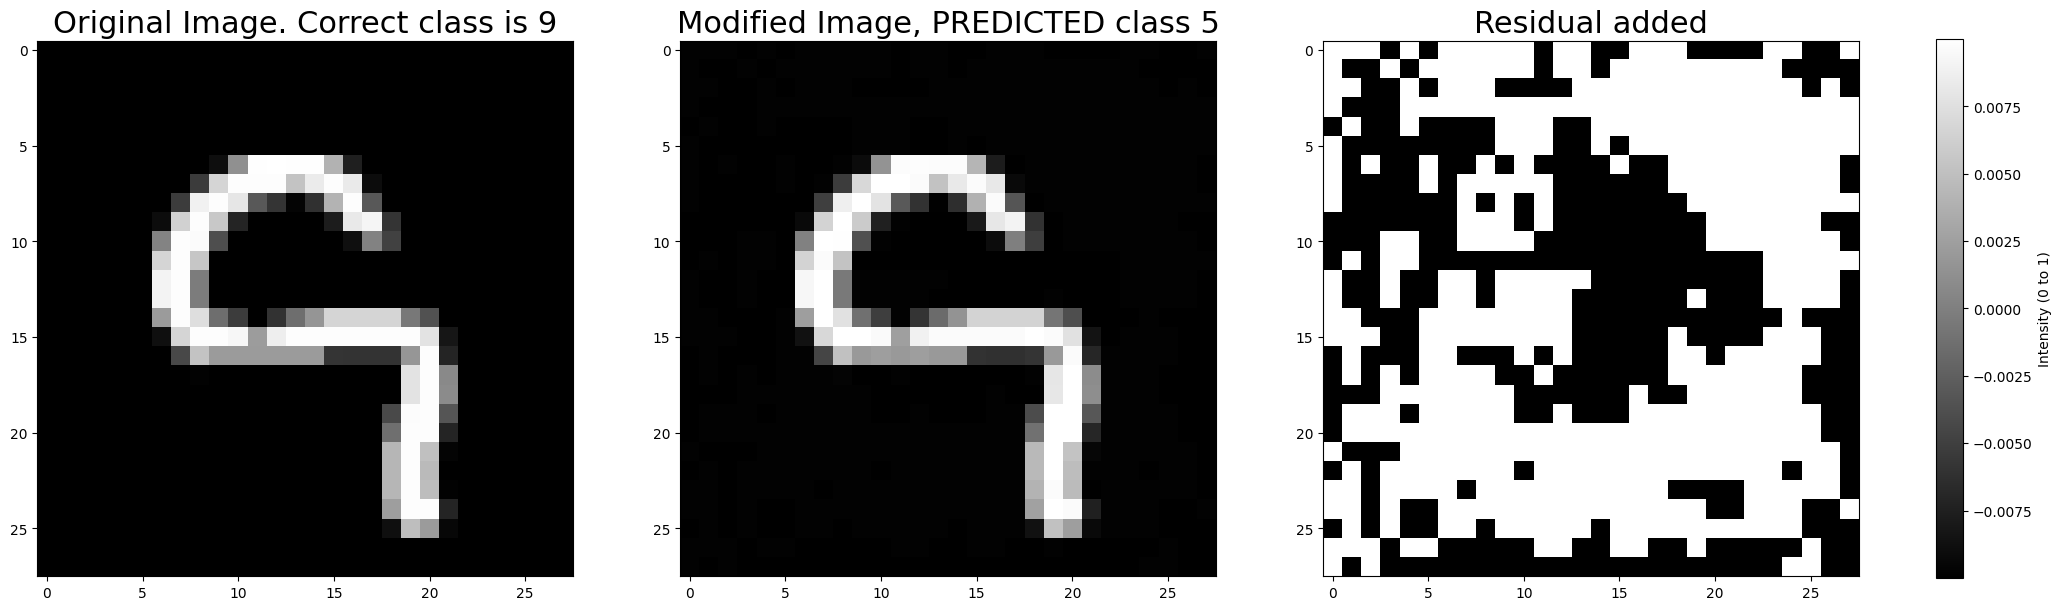

Success: 1542, total: 10000
Using epsilon: 0.035789473684210524 we successfully created 15.42% adversarial examples


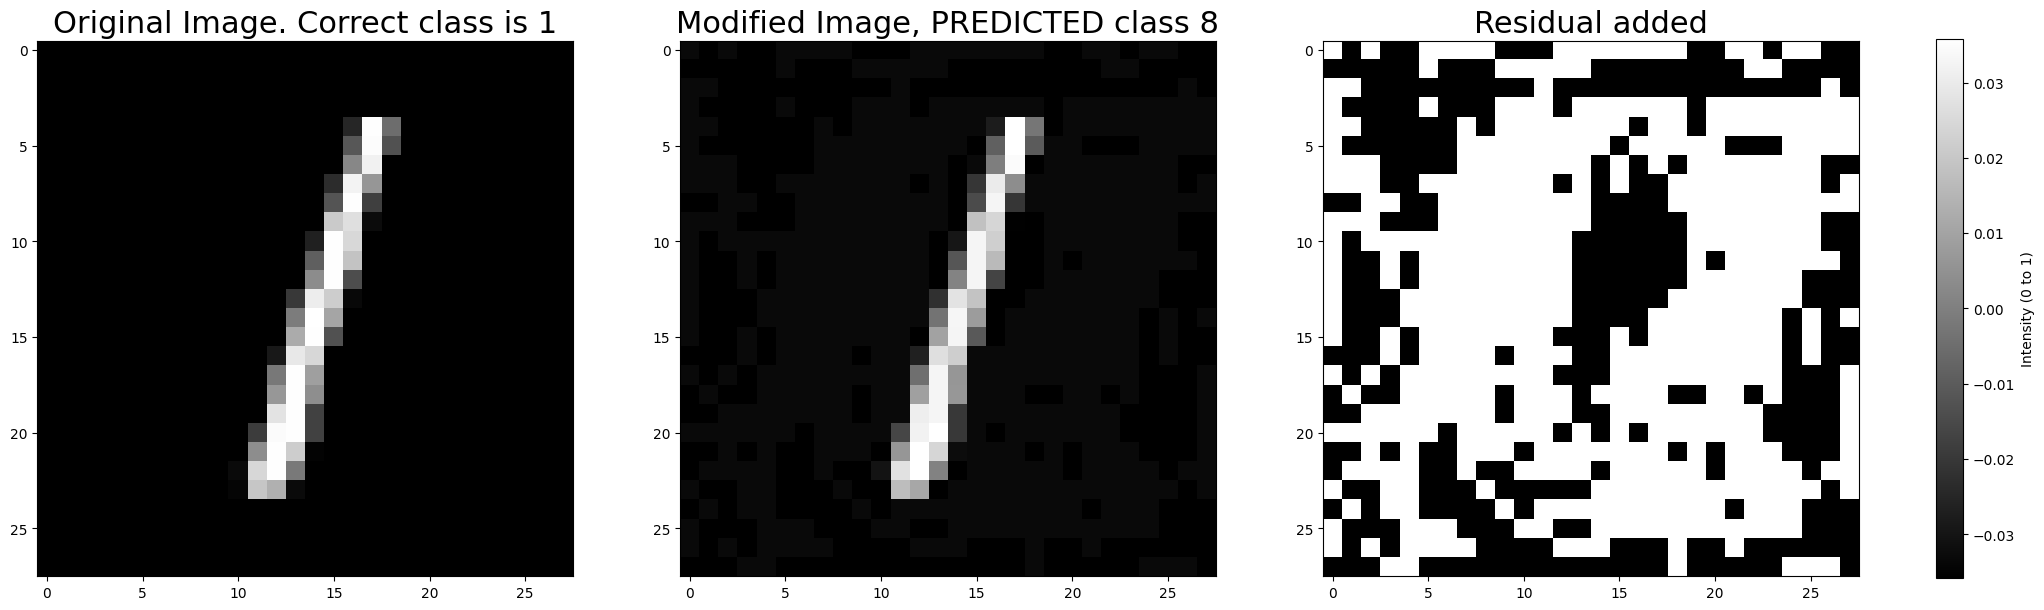

Success: 4754, total: 10000
Using epsilon: 0.06157894736842105 we successfully created 47.54% adversarial examples


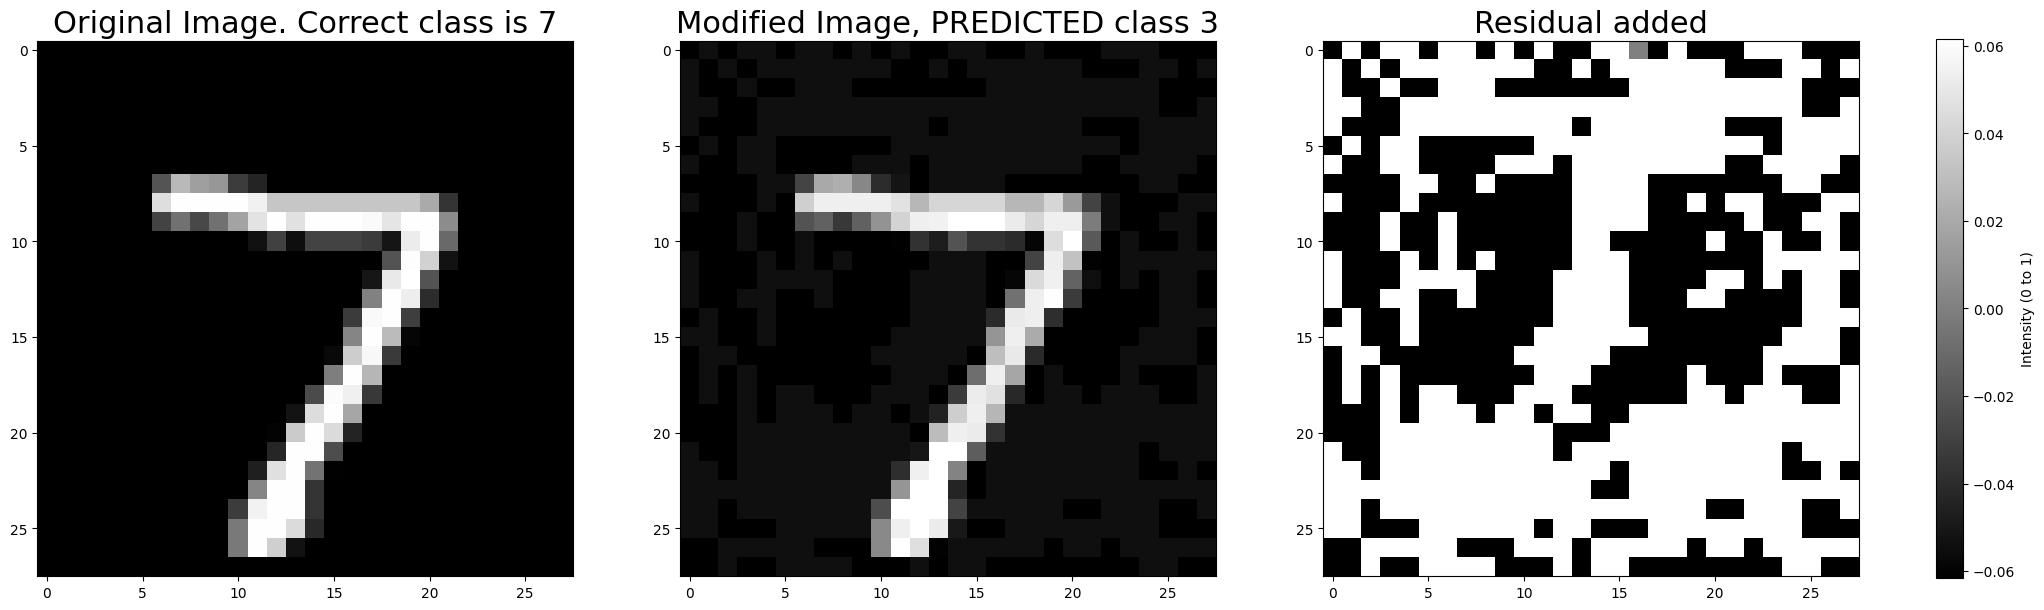

Success: 7213, total: 10000
Using epsilon: 0.08736842105263157 we successfully created 72.13% adversarial examples


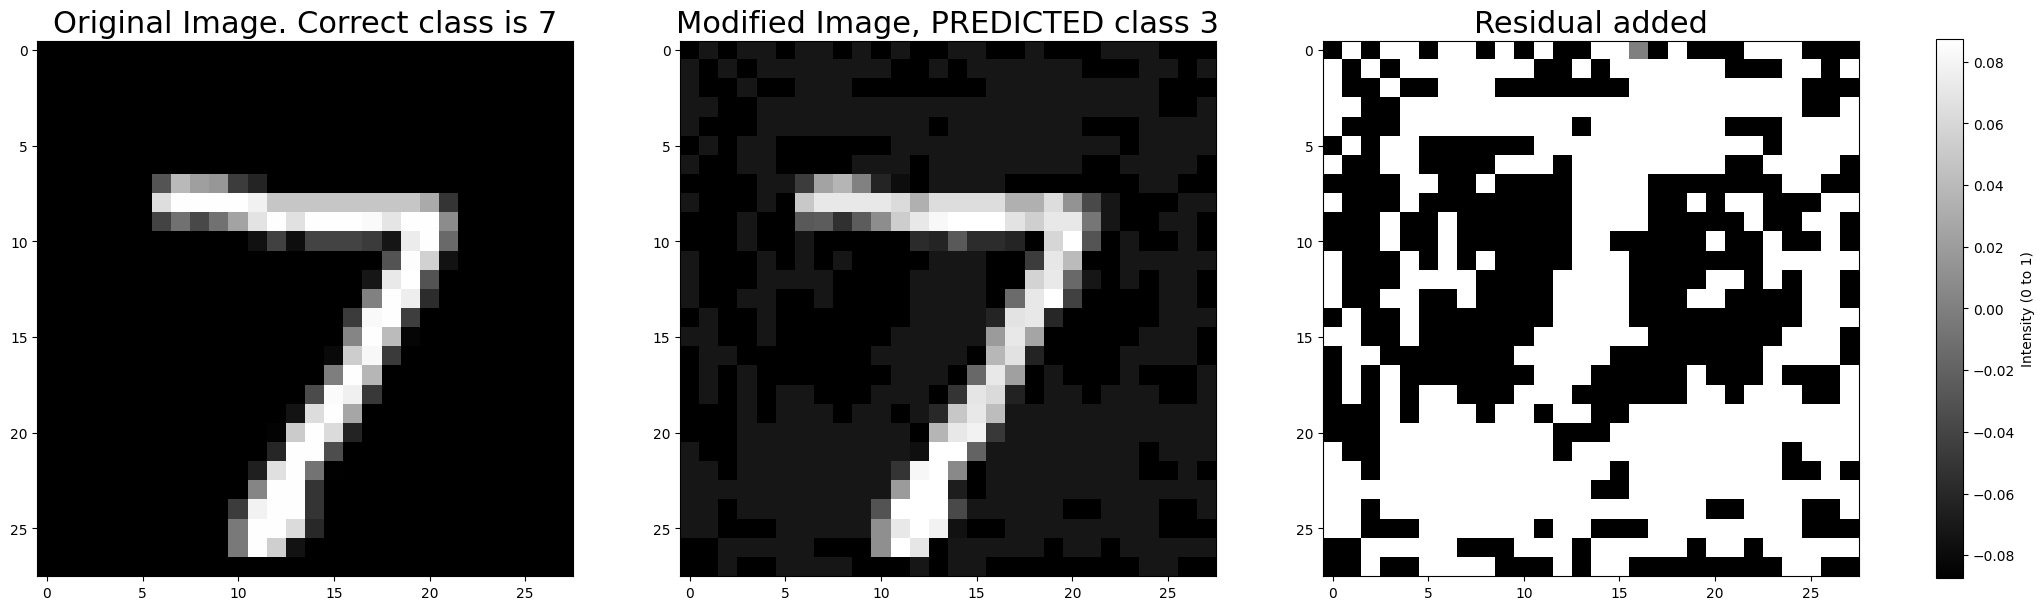

Success: 8659, total: 10000
Using epsilon: 0.1131578947368421 we successfully created 86.59% adversarial examples


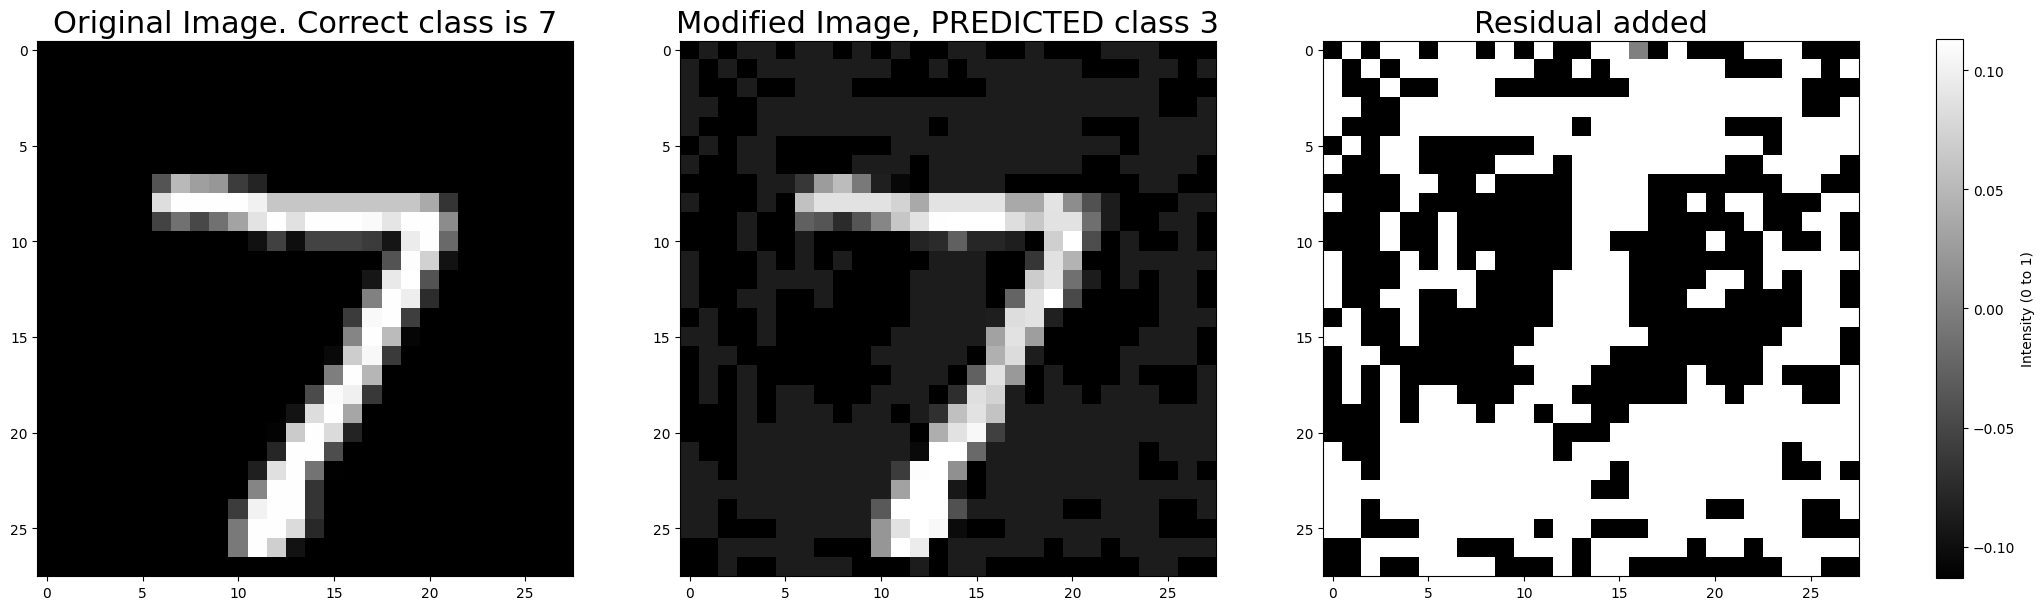

Success: 9322, total: 10000
Using epsilon: 0.13894736842105262 we successfully created 93.22% adversarial examples


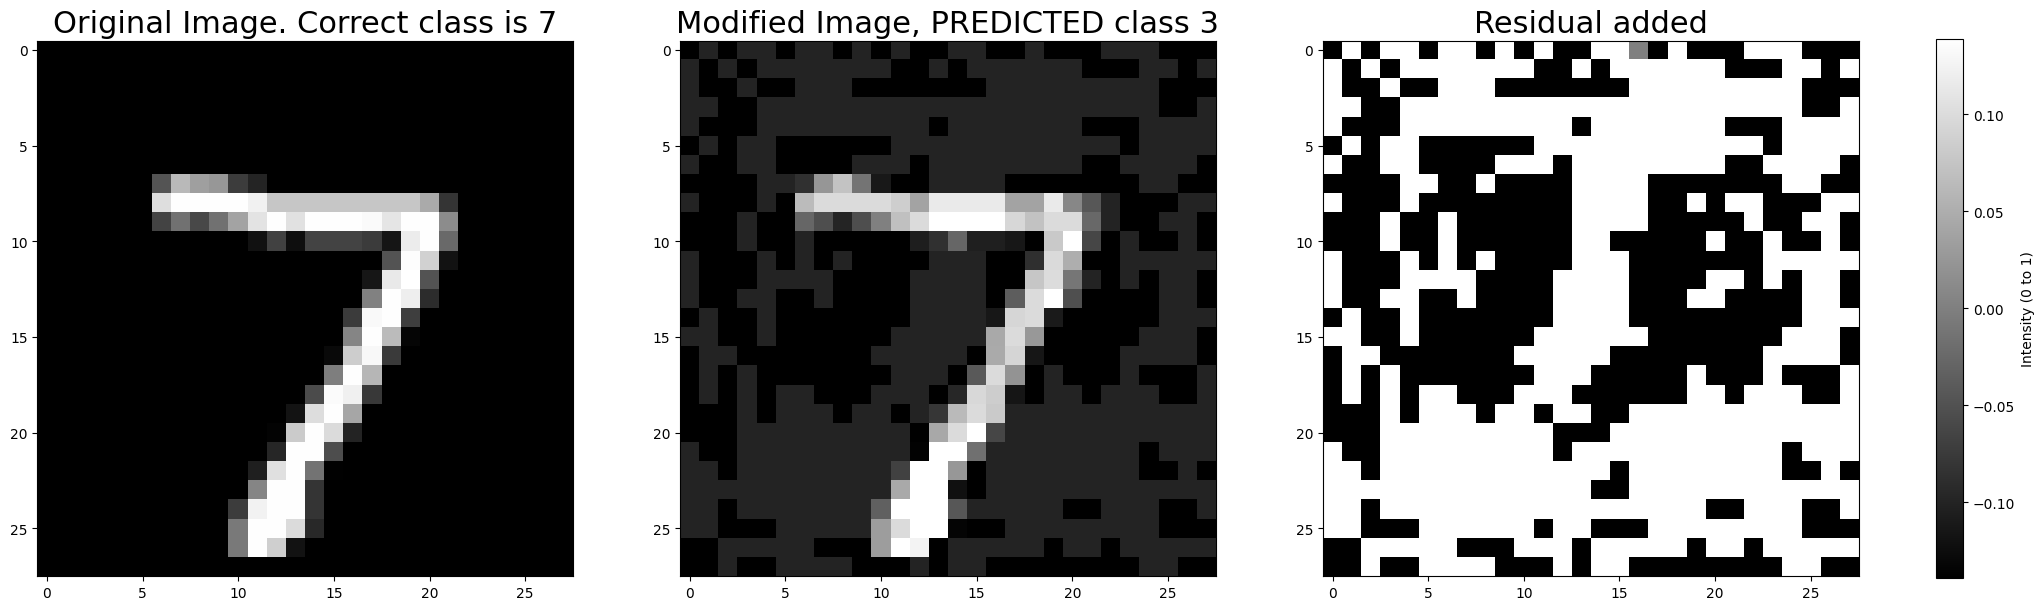

Success: 9602, total: 10000
Using epsilon: 0.16473684210526315 we successfully created 96.02% adversarial examples


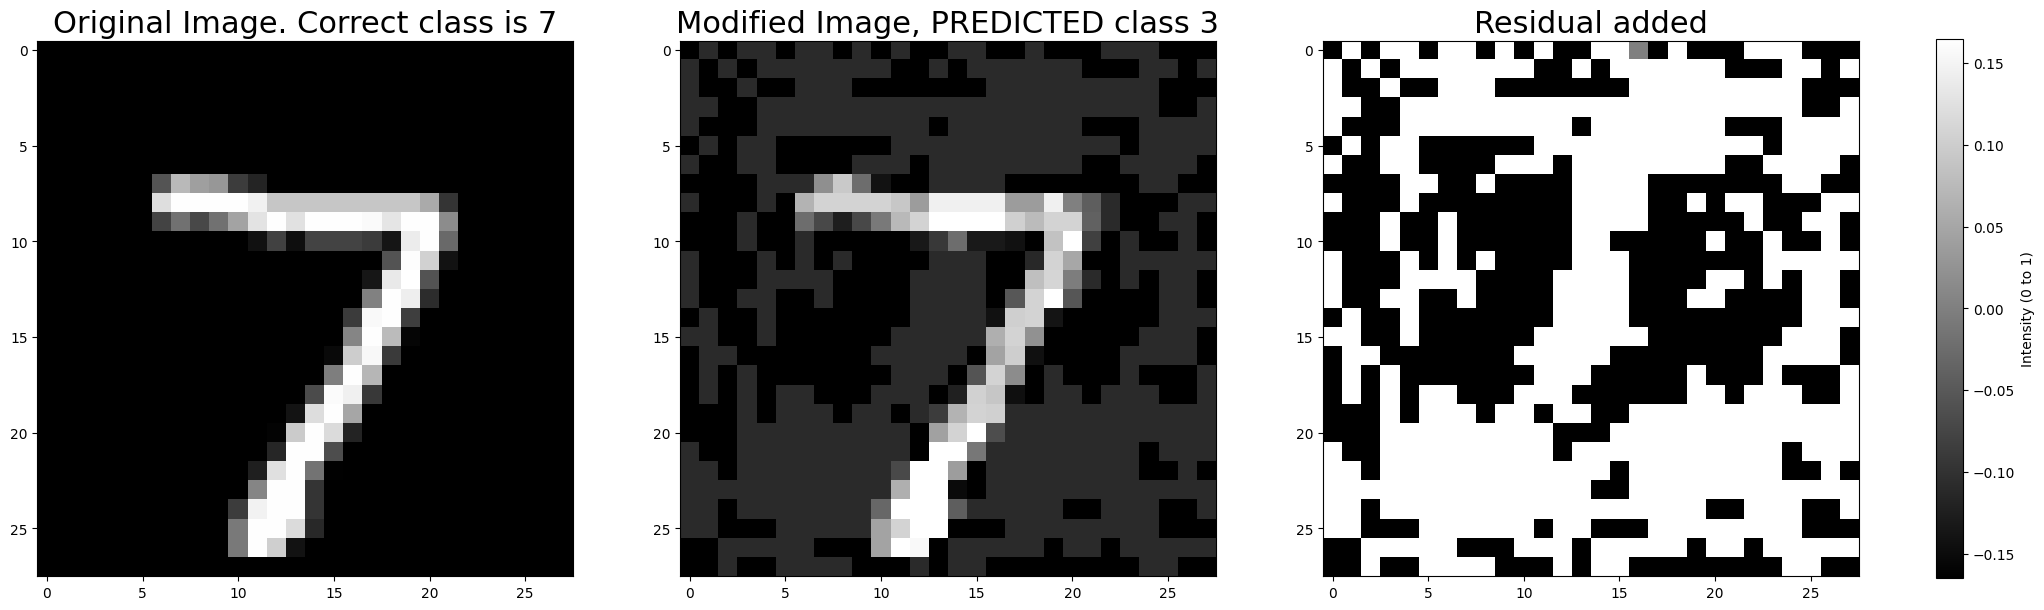

Success: 9705, total: 10000
Using epsilon: 0.19052631578947368 we successfully created 97.05% adversarial examples


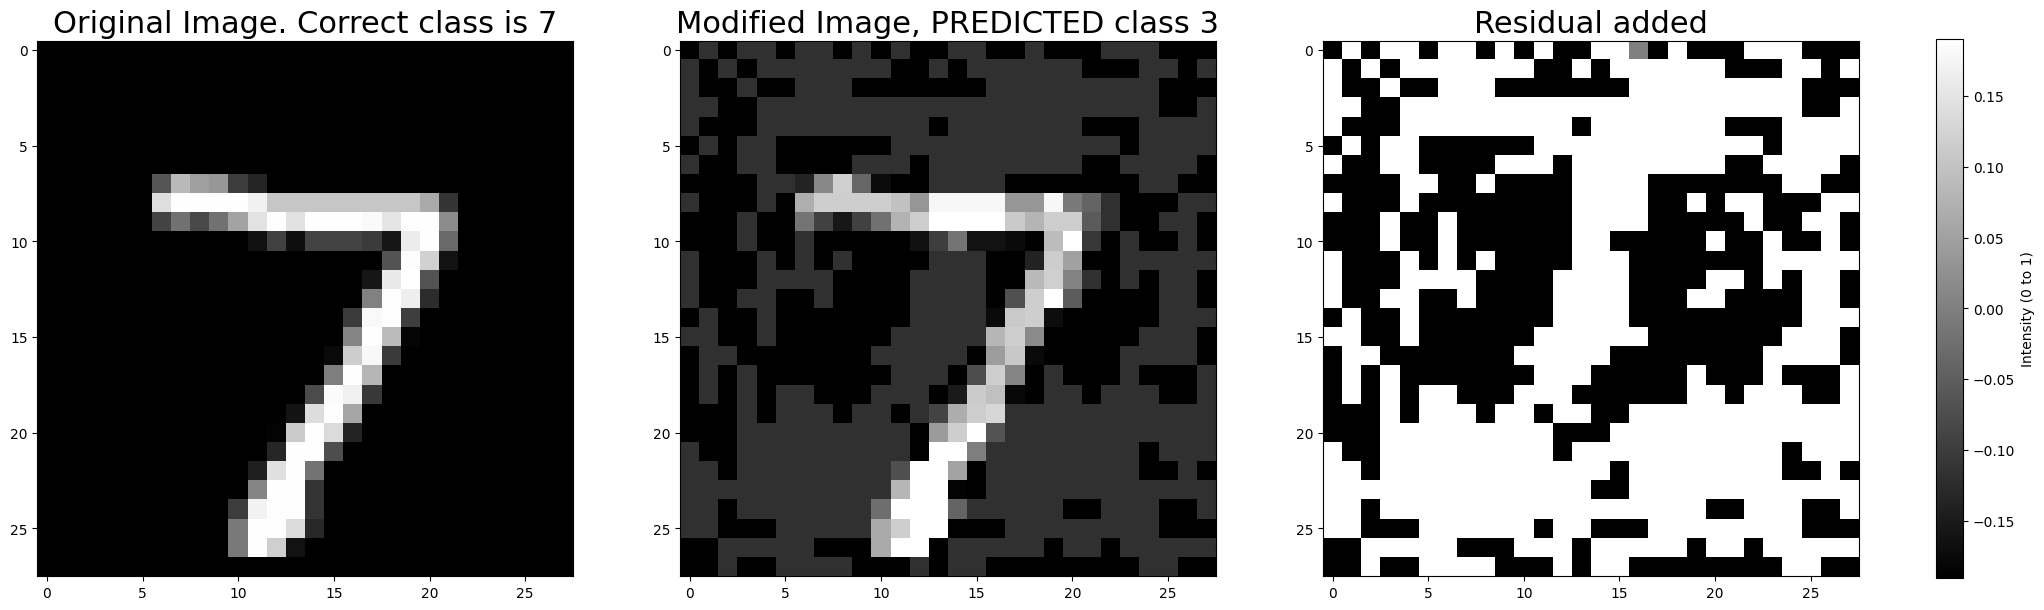

Success: 9753, total: 10000
Using epsilon: 0.2163157894736842 we successfully created 97.53% adversarial examples


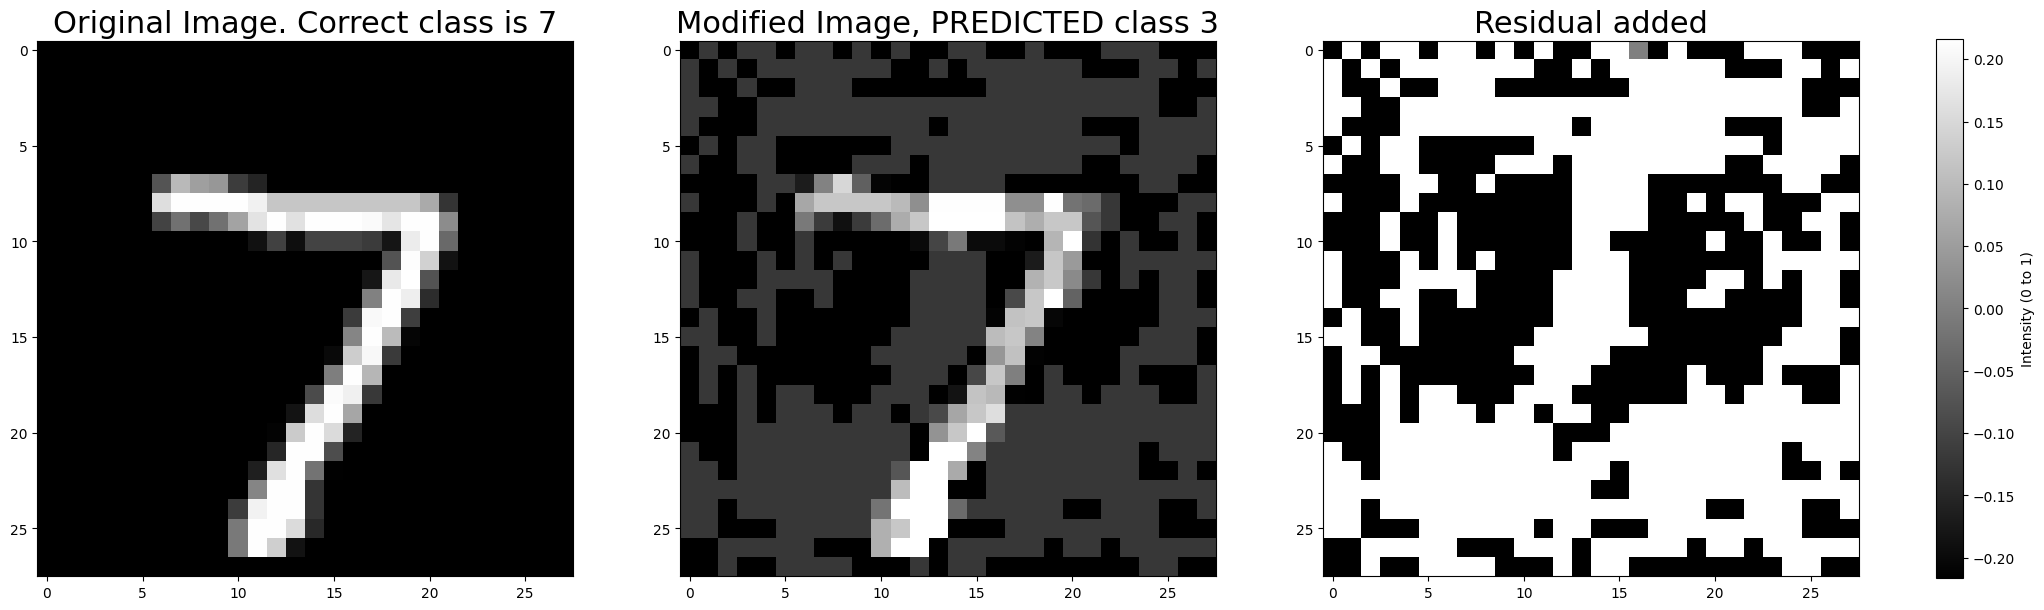

Success: 9767, total: 10000
Using epsilon: 0.24210526315789474 we successfully created 97.67% adversarial examples


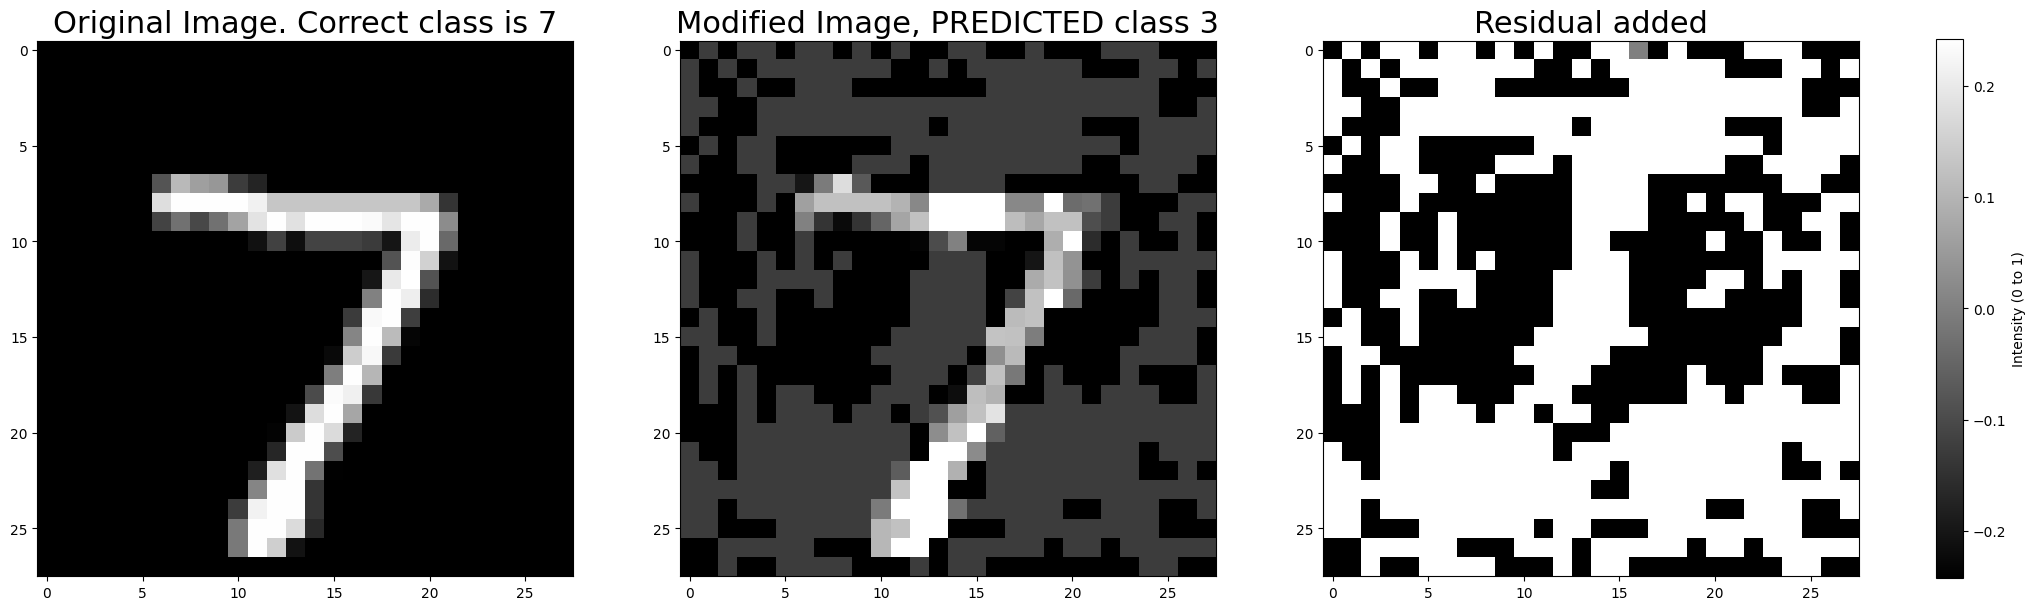

Success: 9777, total: 10000
Using epsilon: 0.26789473684210524 we successfully created 97.77% adversarial examples


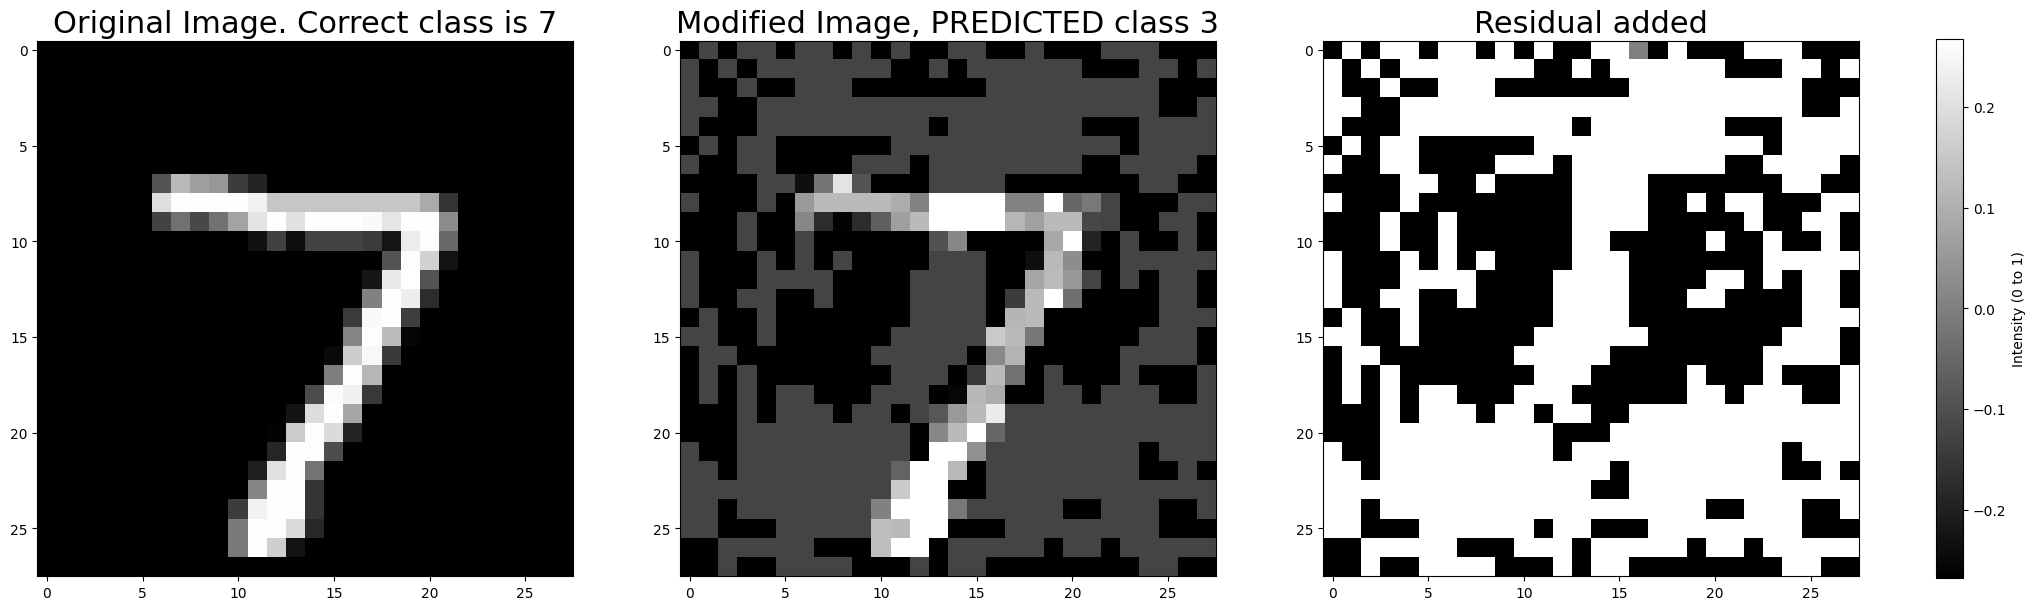

Success: 9785, total: 10000
Using epsilon: 0.29368421052631577 we successfully created 97.85% adversarial examples


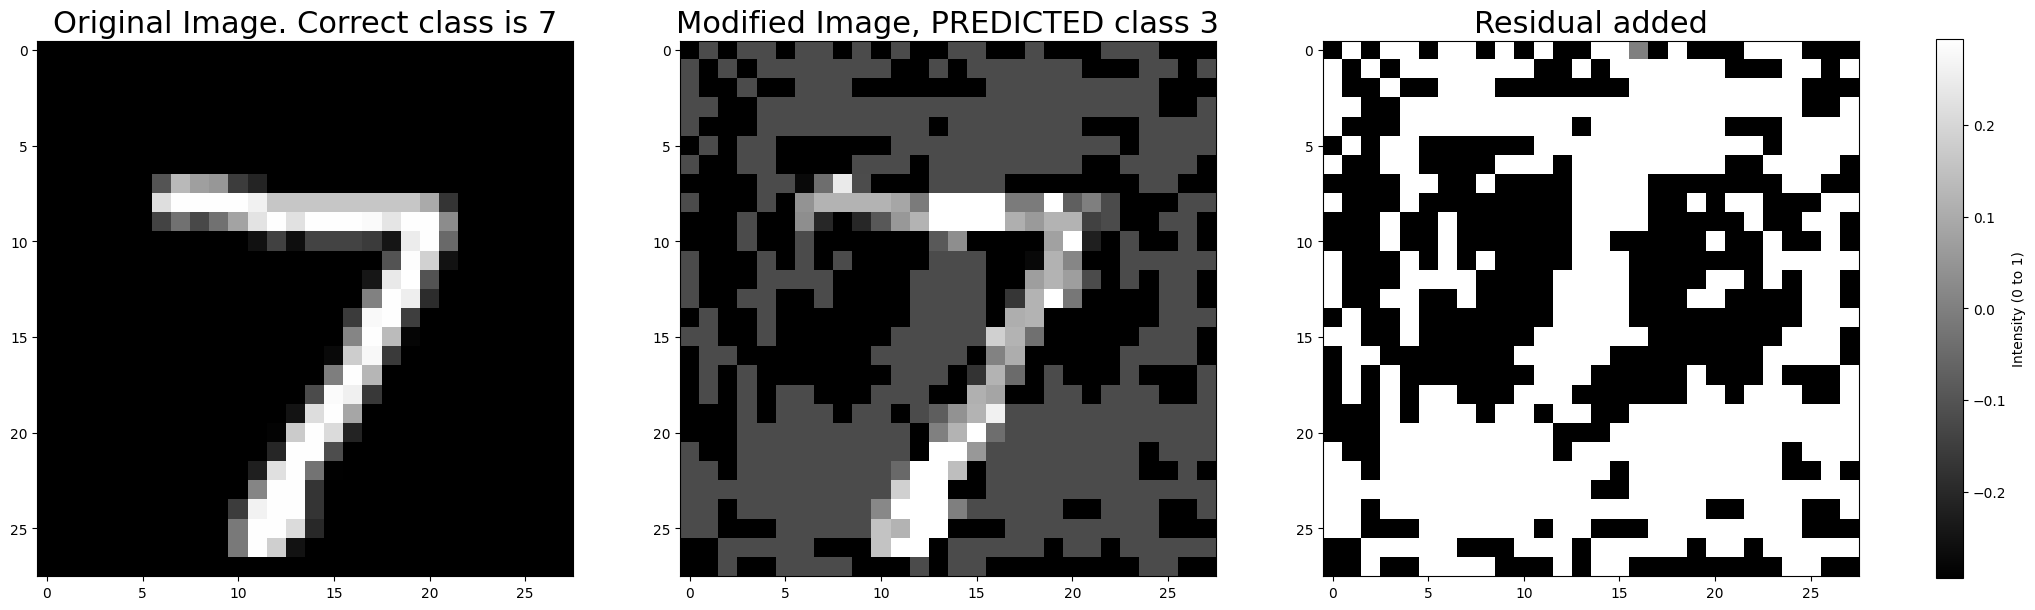

Success: 9794, total: 10000
Using epsilon: 0.3194736842105263 we successfully created 97.94% adversarial examples


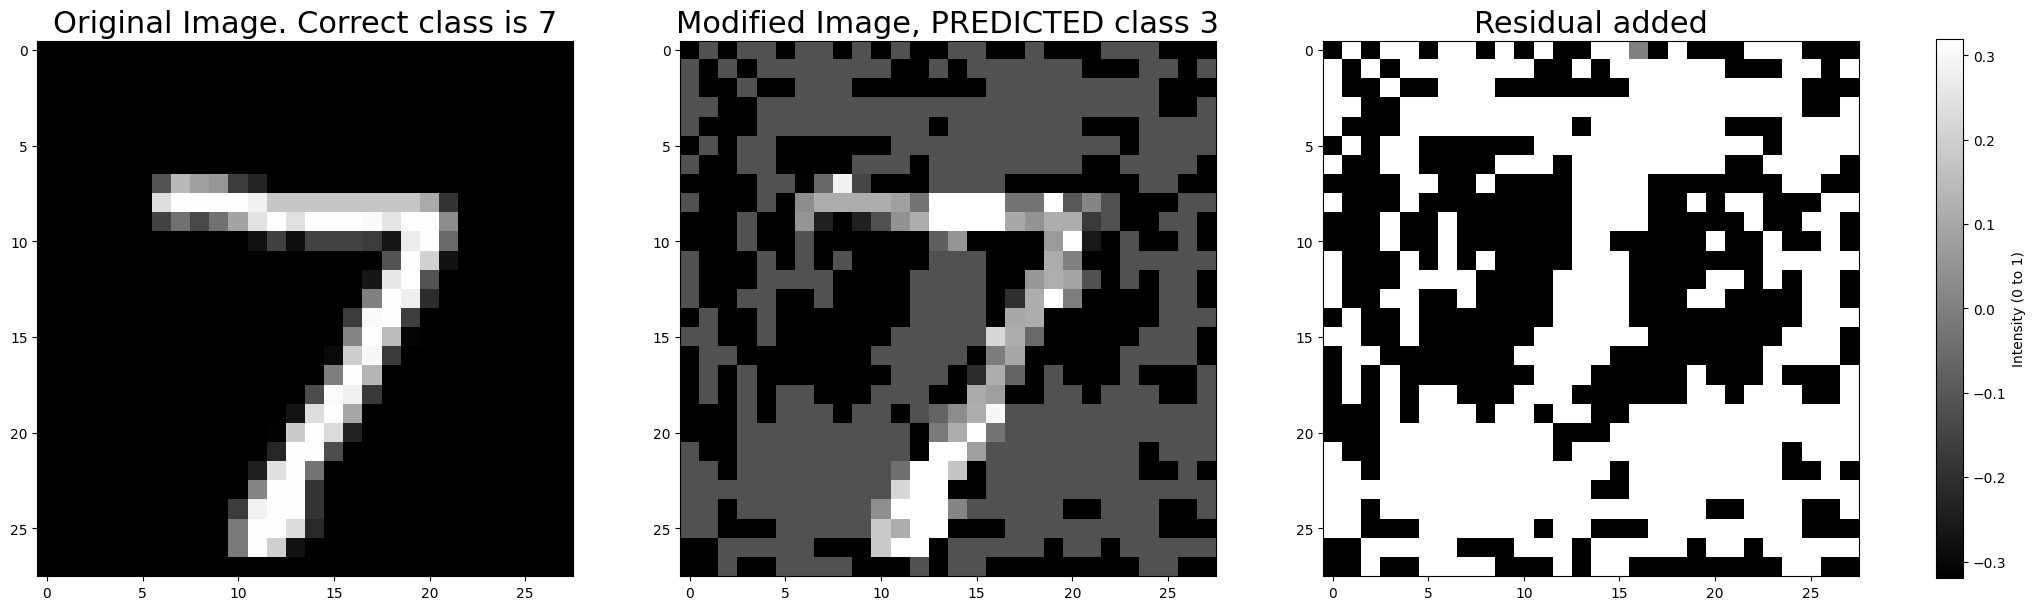

Success: 9804, total: 10000
Using epsilon: 0.3452631578947368 we successfully created 98.04% adversarial examples


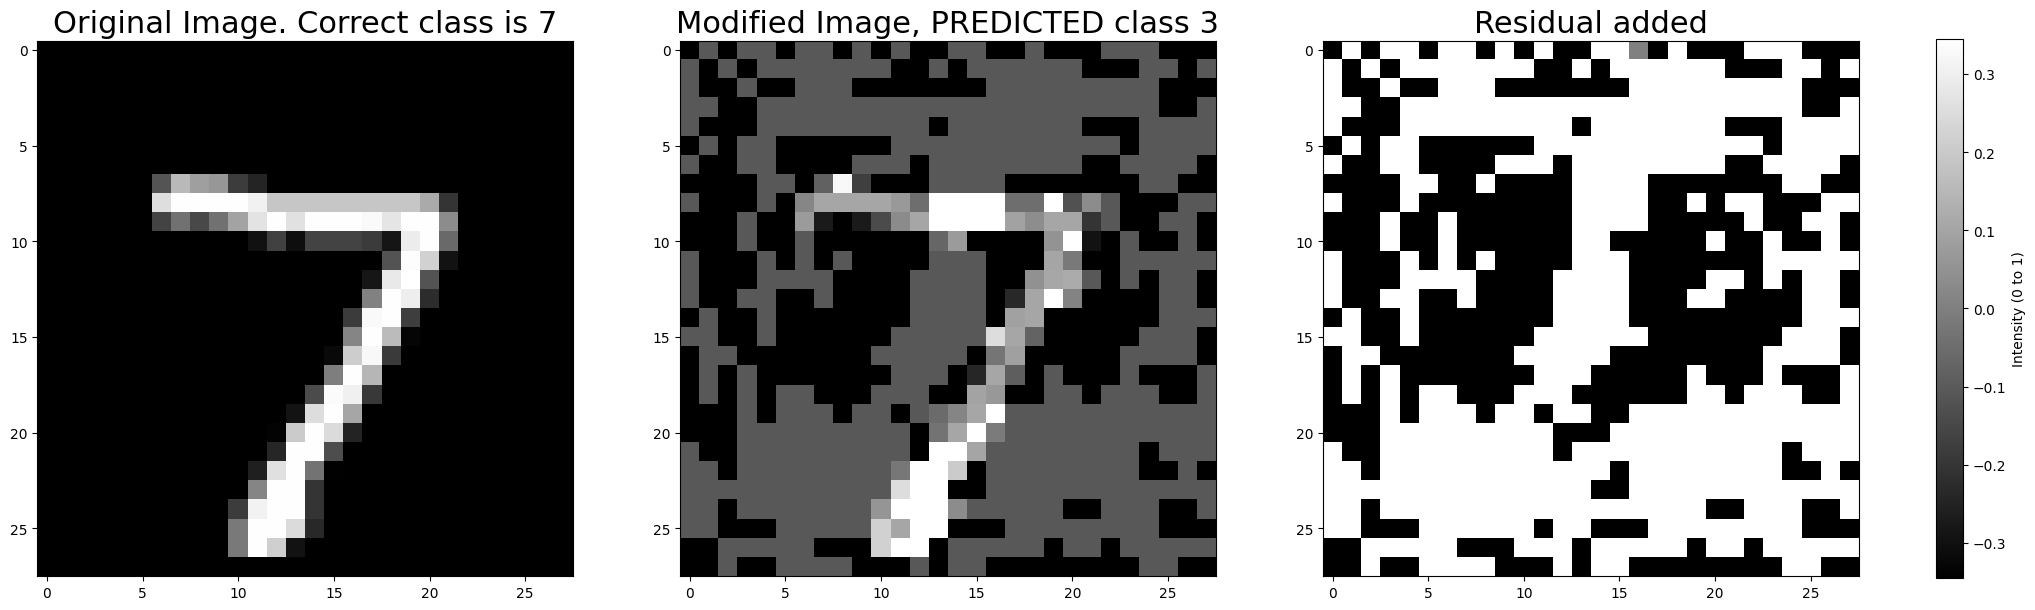

Success: 9809, total: 10000
Using epsilon: 0.37105263157894736 we successfully created 98.09% adversarial examples


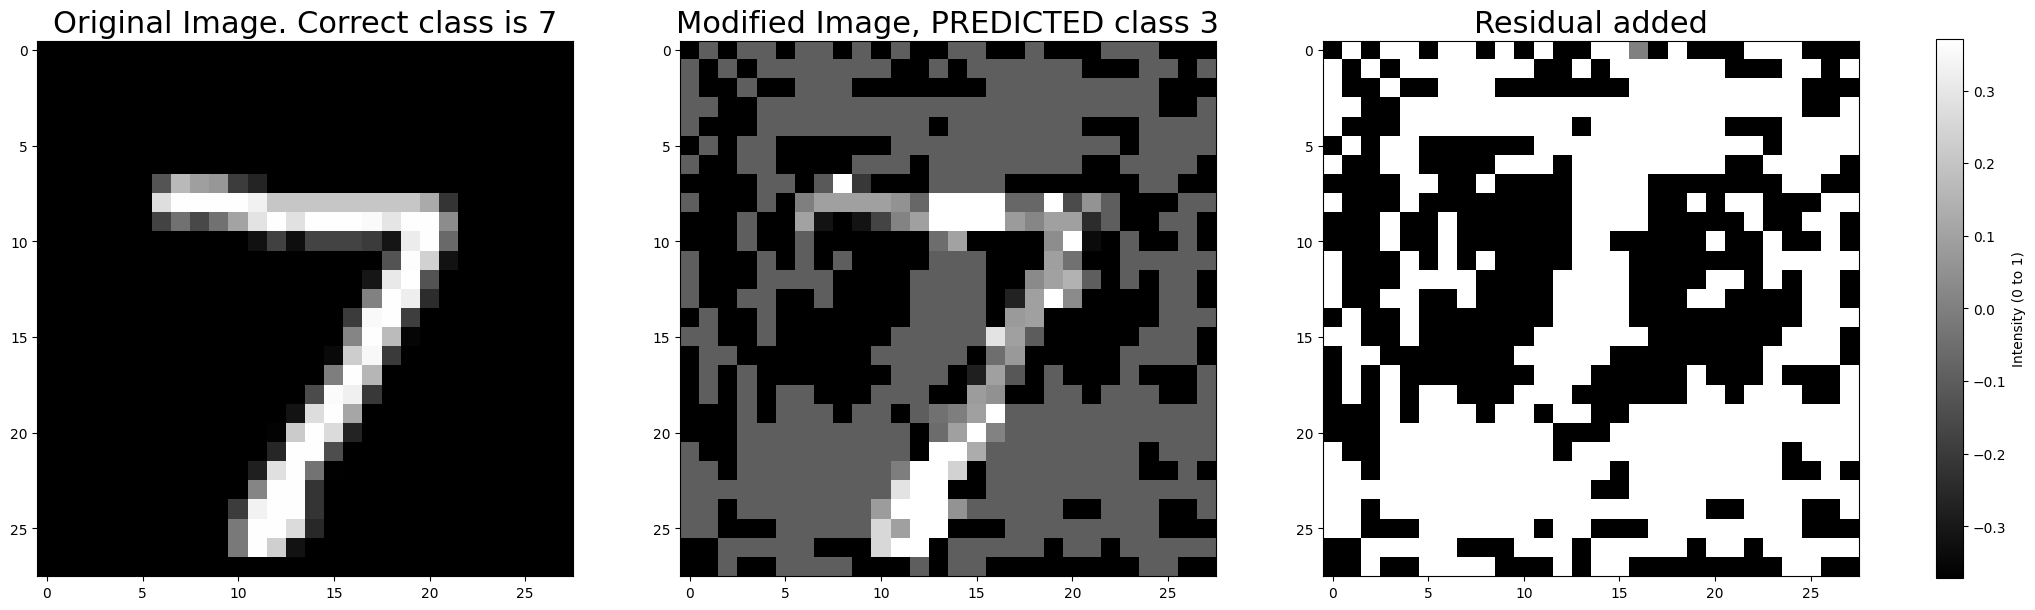

Success: 9815, total: 10000
Using epsilon: 0.3968421052631579 we successfully created 98.15% adversarial examples


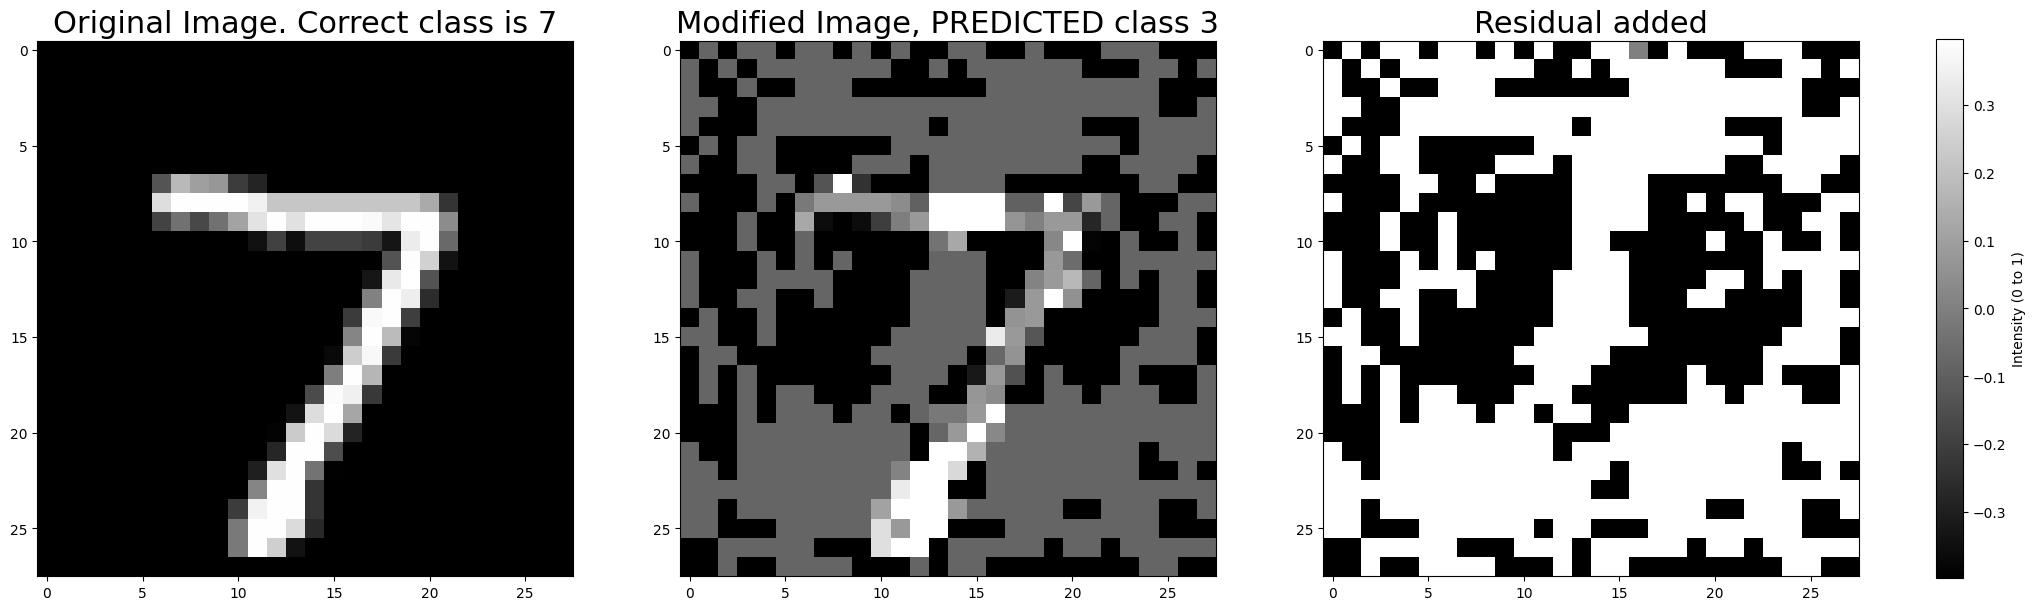

Success: 9818, total: 10000
Using epsilon: 0.4226315789473684 we successfully created 98.18% adversarial examples


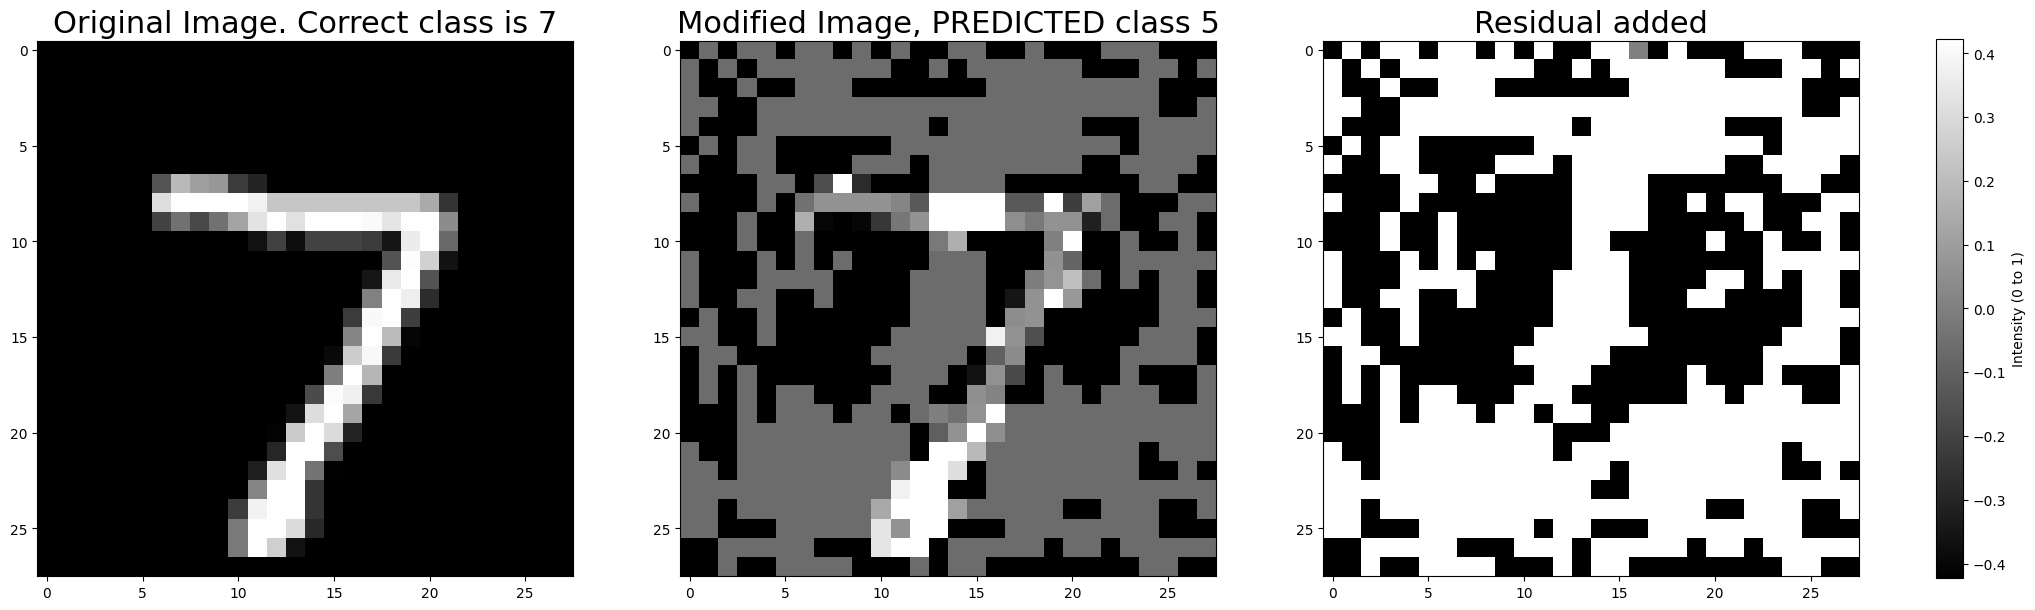

Success: 9820, total: 10000
Using epsilon: 0.44842105263157894 we successfully created 98.20% adversarial examples


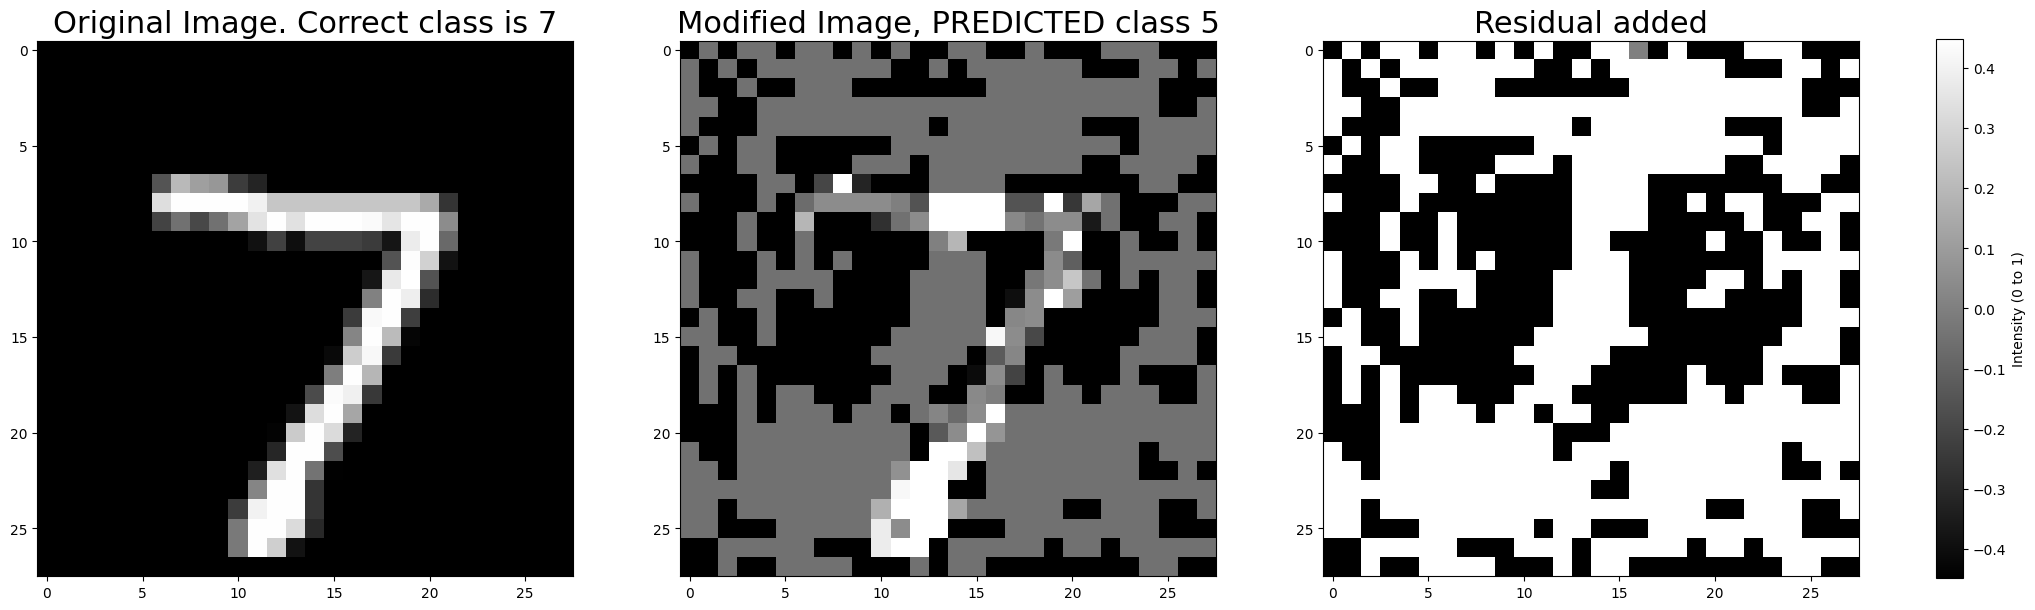

Success: 9828, total: 10000
Using epsilon: 0.47421052631578947 we successfully created 98.28% adversarial examples


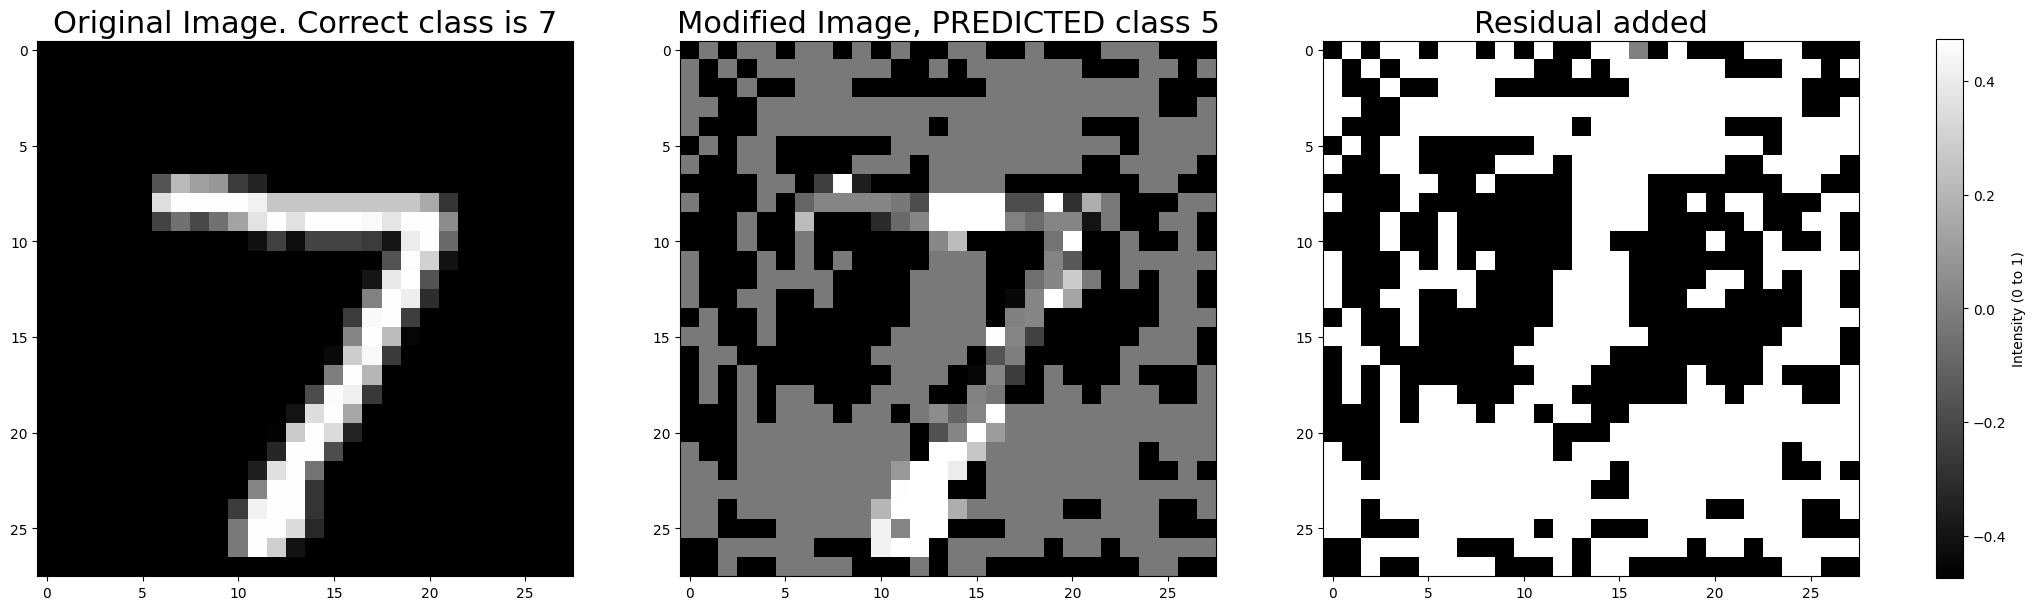

Success: 9829, total: 10000
Using epsilon: 0.5 we successfully created 98.29% adversarial examples


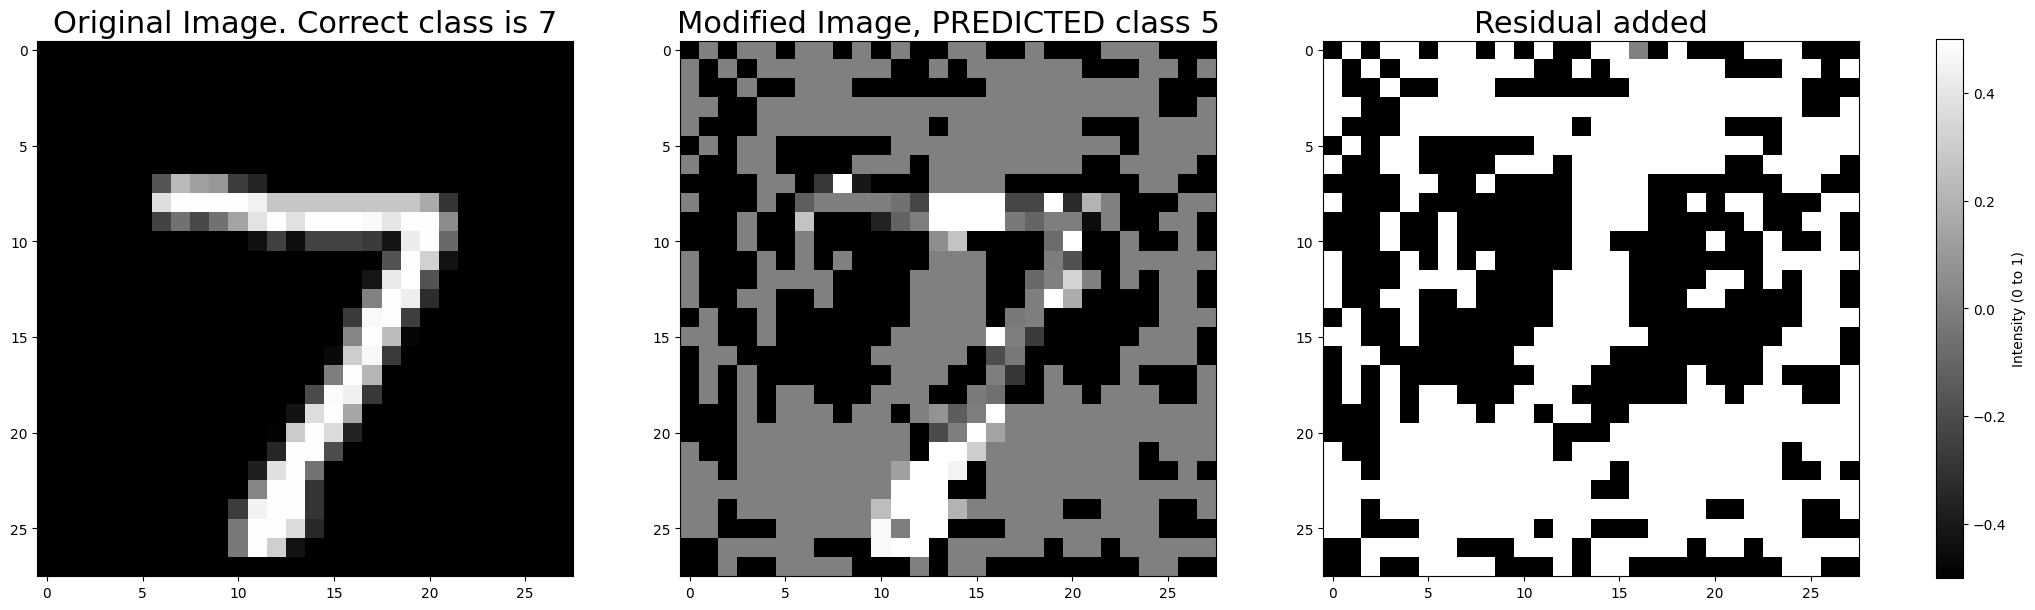

In [61]:
def fgsm_attack(X, Y, model, loss_model, eps):
    Y = Y.unsqueeze(0)
    X, Y = X.to(device), Y.to(device)

    X.requires_grad = True
    pred_original = model(X)
    original_class = torch.argmax(pred_original)

    # compute loss
    cost = loss_model(pred_original, Y)

    model.zero_grad()
    cost.backward()

    # FGSM pertubation
    r = eps * X.grad.data.sign()
    Xr = torch.clamp(X + r, 0, 1)

    pred_perturbed = model(Xr)
    perturbed_class = torch.argmax(pred_perturbed)

    return Xr, original_class, perturbed_class, r


eps_values = np.linspace(0.01, 0.5, 20)

model.to(device)

for eps in eps_values:
    successful_perturbations = 0
    total_images = 0
    adv_examples = []

    for X_batch, Y_batch in test_loader:
        for X, Y in zip(X_batch, Y_batch):
            # perform FGSM attack
            Xr, original_class, perturbed_class, r = fgsm_attack(
                X, Y, model, loss_model, eps
            )

            total_images += 1

            # check if the adversarial attack was successful
            if original_class != perturbed_class:
                successful_perturbations += 1
                adv_examples.append((X, Xr, original_class, perturbed_class, r))

    # calculate final accuracy for this epsilon
    Adv_acc = (successful_perturbations / total_images) * 100
    print(f"Success: {successful_perturbations}, total: {total_images}")
    print(
        f"Using epsilon: {eps} we successfully created {Adv_acc:.2f}% adversarial examples"
    )

    # plot one example
    if successful_perturbations > 0:
        index = 0  # Index of the first adversarial example
        X, Xr, original_class, perturbed_class, r = adv_examples[index]
        plot_results(X, r, Xr, original_class, perturbed_class, fail=False)

**Comment**

As mentioned in the paper, while MNIST data contains pixel values beyond just `0` or `1`, the images are effectively binary. Each pixel approximately represents either **"ink"** or **"no ink"**, making them suitable for perturbations. It is reasonable to expect the classifier to tolerate perturbations within a range of width `0.5`. Human observers can still easily recognize such images even with added noise.

In this experiment, I tested the impact of **20 different epsilon values** in the range `[0, 0.5]`. As epsilon increases (indicating more noise), the number of adversarial examples rises, illustrating the model's sensitivity to adversarial perturbations.

The best-case performance achieved was approximately **98%**, matching the results reported in the original paper.
